# In the scope of the evaluation 
 
* full * Annotated_BTC_English_UAM_2_4/Annotation_OE1clean.ctpr
* full * Annotation_OE_clean_gold_UAM_1_33_new_segments/Annotation_OE1clean.ctpr
* only BeatOCD.txt from OCD_Annotation_Ela/OCD_Annotation.ctpr.

# Notes:

* for segmentation evaluation use https://www.nltk.org/_modules/nltk/metrics/segmentation.html implementation
* wider variety of metrics implemented here: https://www.nltk.org/api/nltk.metrics.html?highlight=metrics#module-nltk.metrics


# General Function definition

In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import division
from notebook_functions import *
# import nltk
from scipy import stats

# setting up the matplot lib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 300
# pd.options.display.float_format = '{:,.2f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Corpus general statistics

In [3]:
corpus_segment_count(OE1_const_file_list, "OE1_const_file_list")
corpus_segment_count(BTC_const_file_list, "BTC_const_file_list")

corpus_segment_count(OE1_trans_file_list, "OE1_trans_file_list")
corpus_segment_count(BTC_trans_file_list, "BTC_trans_file_list")

corpus_segment_count(OCD_odd_const_file_list, "OCD_odd_const_file_list")
corpus_segment_count(OCD1_const_file_list, "OCD1_const_file_list")
corpus_segment_count(OCD2_const_file_list, "OCD2_const_file_list")

corpus_segment_count(OCD_odd_mood_file_list, "OCD_odd_mood_file_list")
corpus_segment_count(OCD1_mood_file_list, "OCD1_mood_file_list")
corpus_segment_count(OCD2_mood_file_list, "OCD2_mood_file_list")


# Segmentation evaluation

In [4]:
# ---------
matches, manual_nm, parse_nm = read_batch( OCD_const_file_list + OE1_const_file_list + BTC_const_file_list)
matches[MAN_TEXT] = matches[MAN_TEXT].astype(str)
matches[AUTO_TEXT] = matches[AUTO_TEXT].astype(str)
# --------- 


## Correlations

In [41]:
matches_with_distances = make_distances(matches)
correlation_matrix = matches_with_distances[DISTANCES].corr()
ltx(correlation_matrix, filename="correlation_matrix_distances", caption="Distances correlation matrix", to_display=True)

## Distributions

total:11073
exact:6665(60.1914566965)
close:4408(39.8085433035)


<Figure size 2400x1200 with 0 Axes>

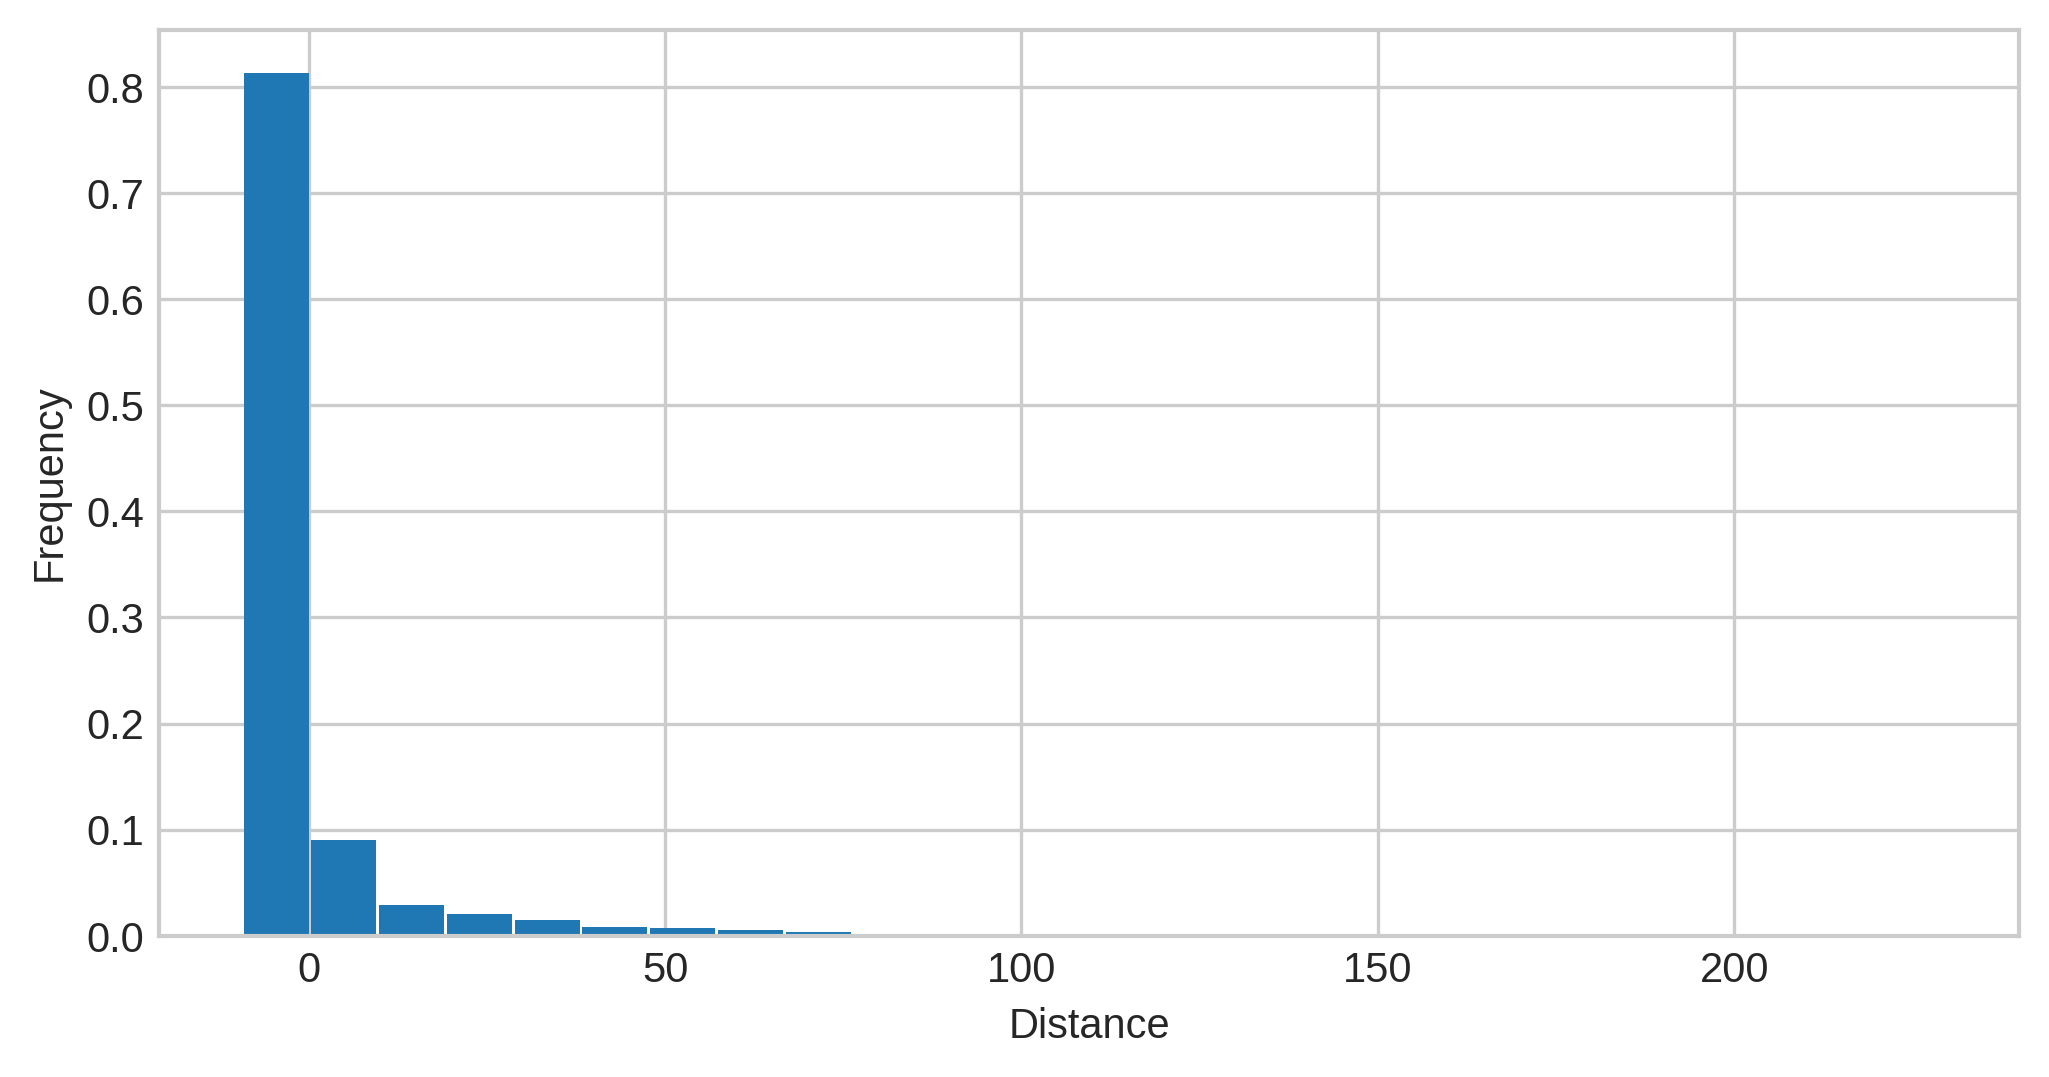

<Figure size 2400x1200 with 0 Axes>

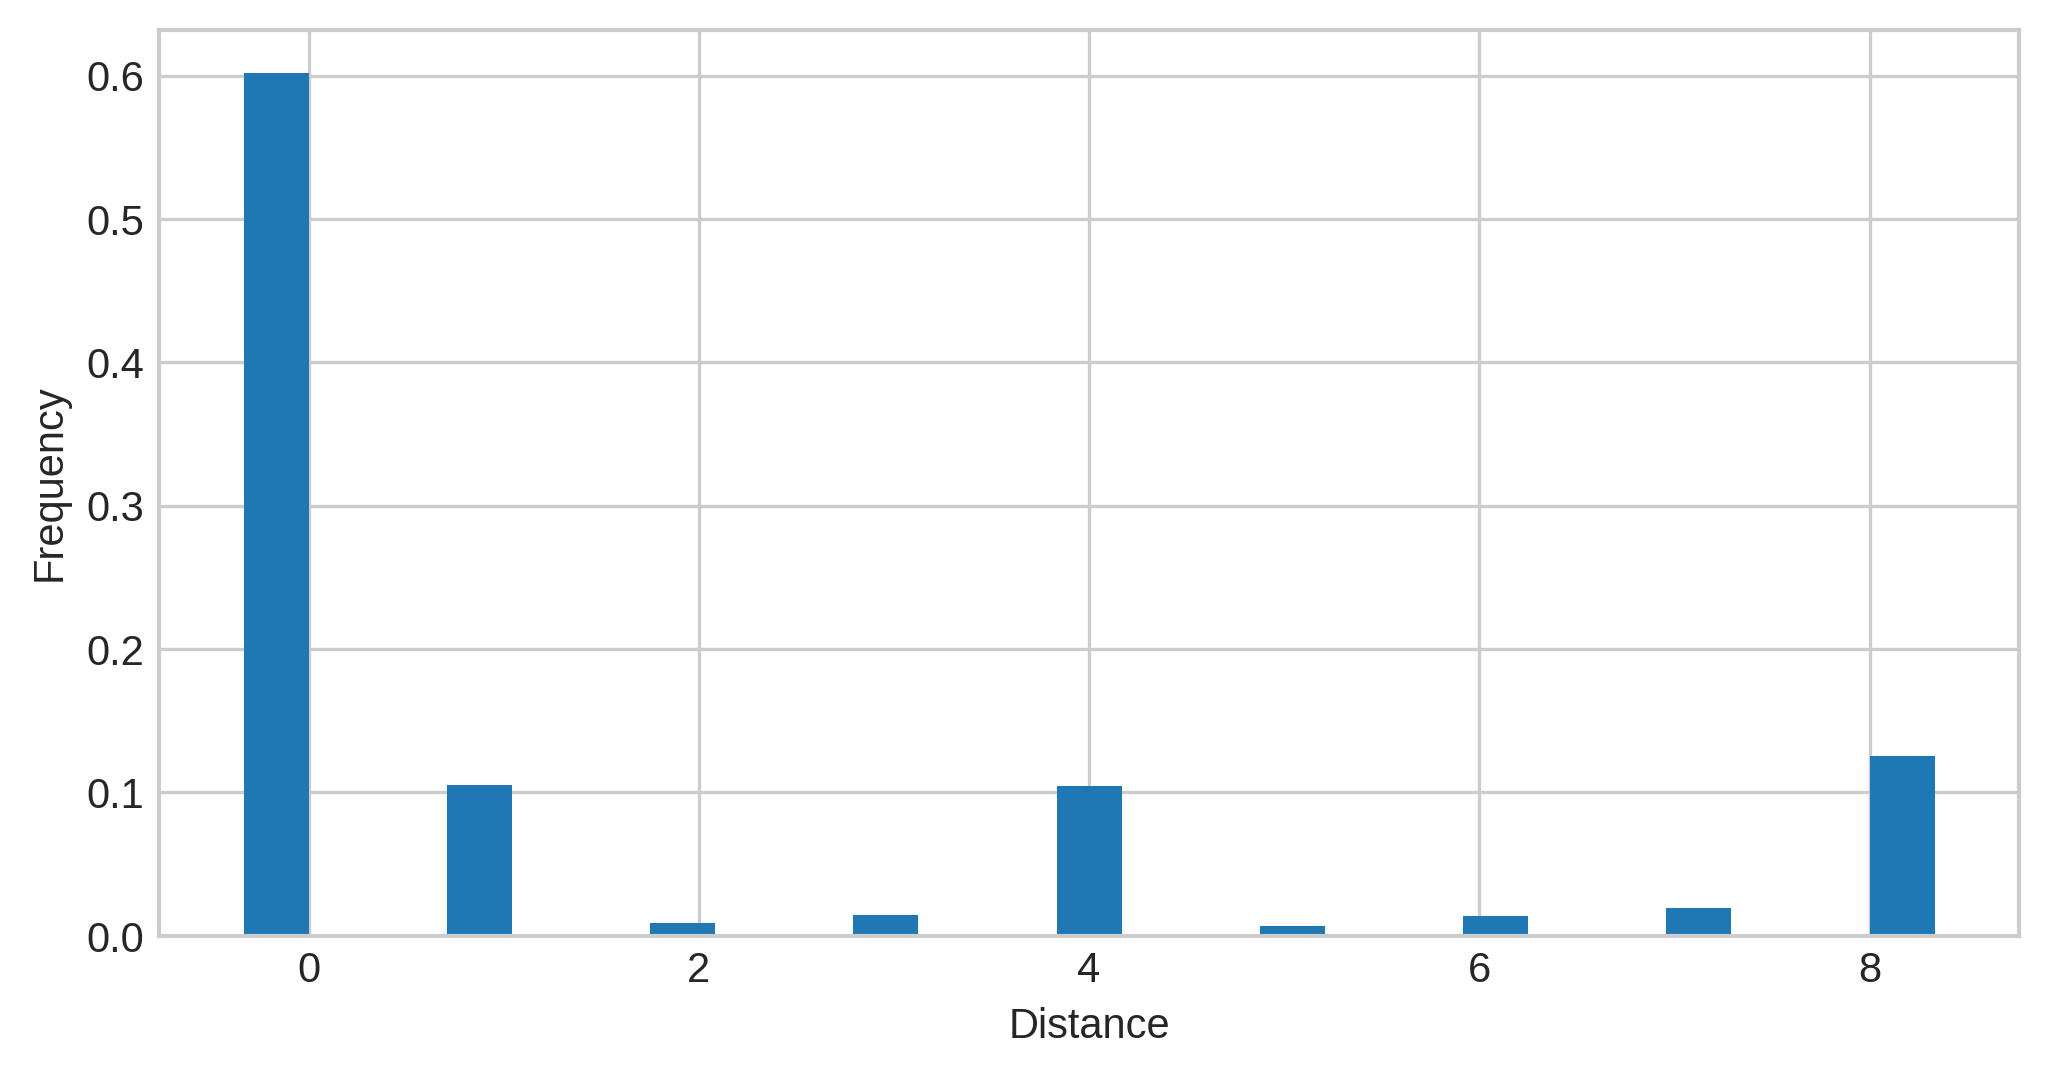

<Figure size 2400x1200 with 0 Axes>

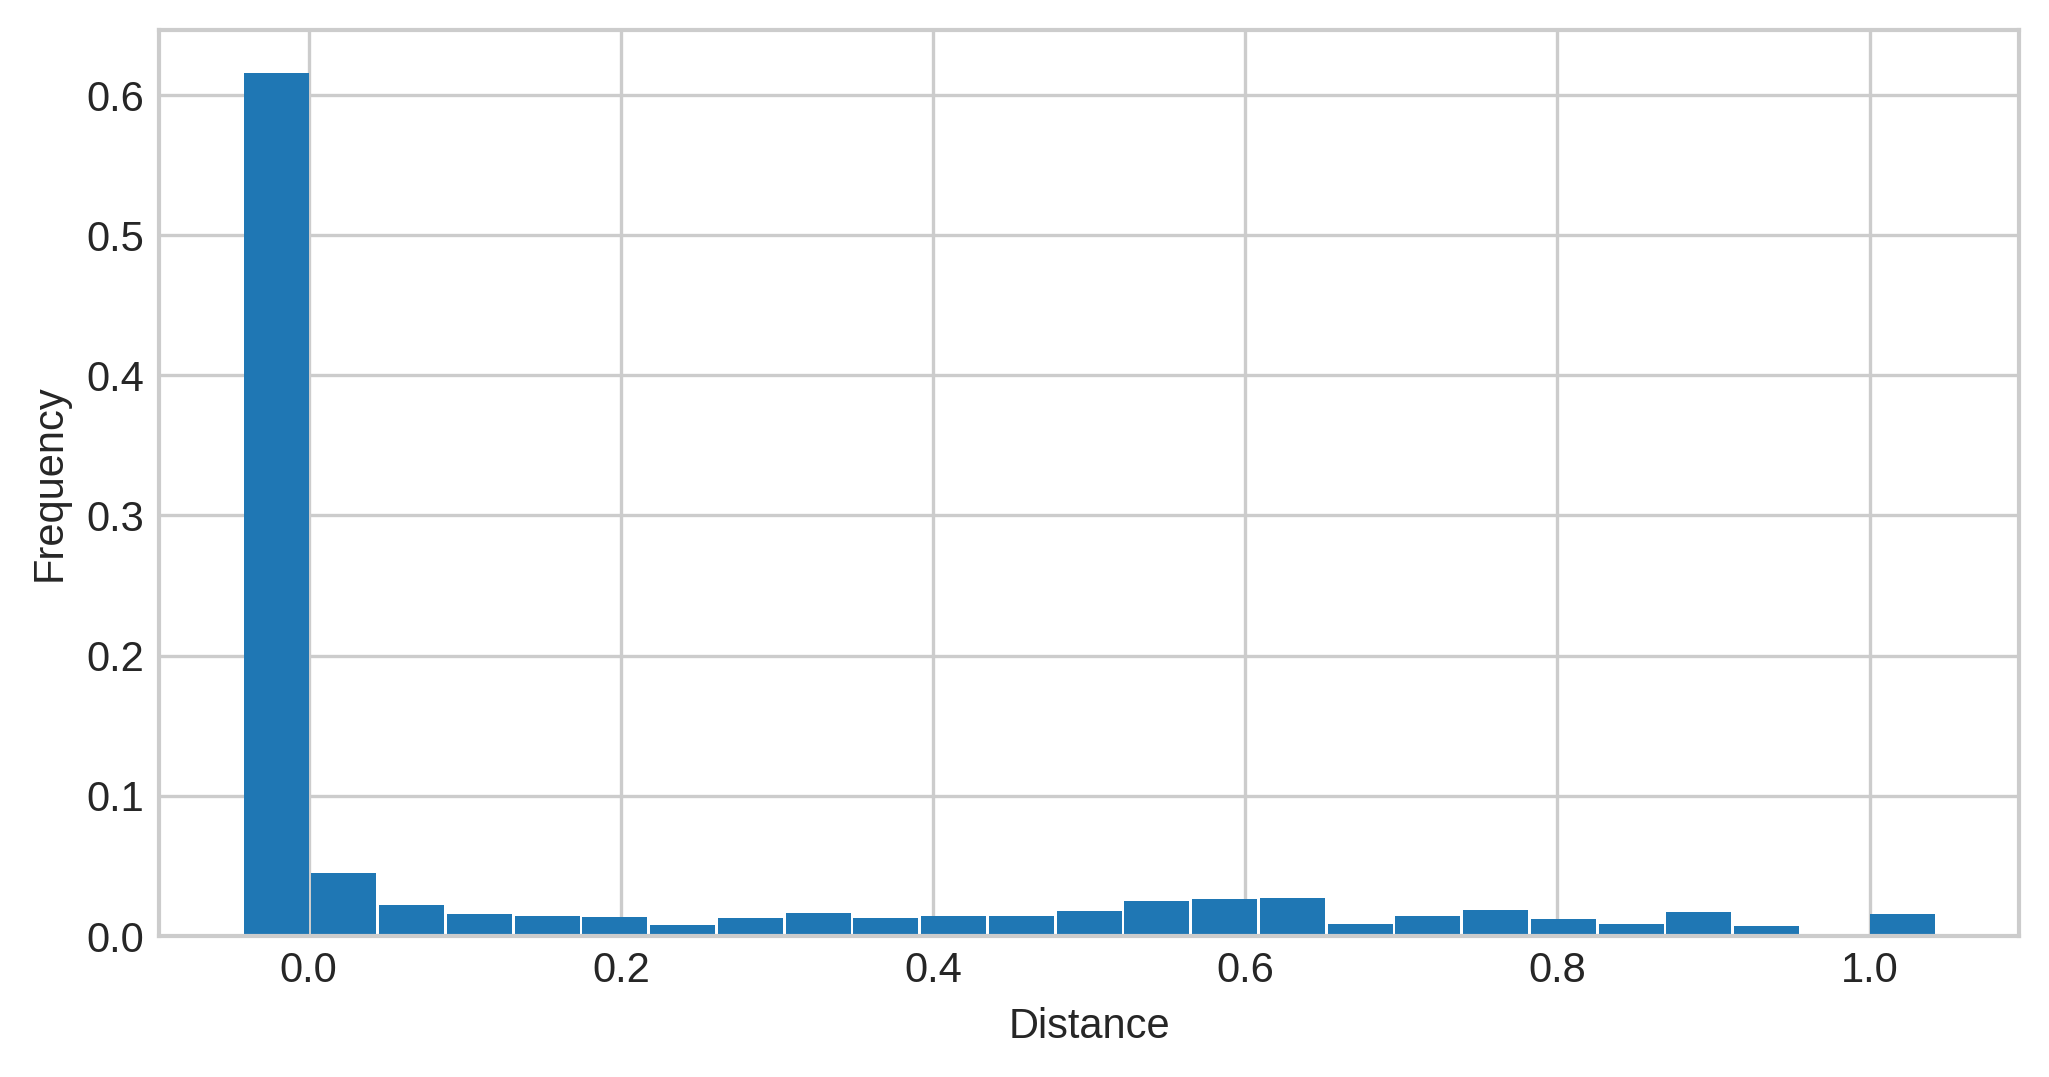

<Figure size 2400x1200 with 0 Axes>

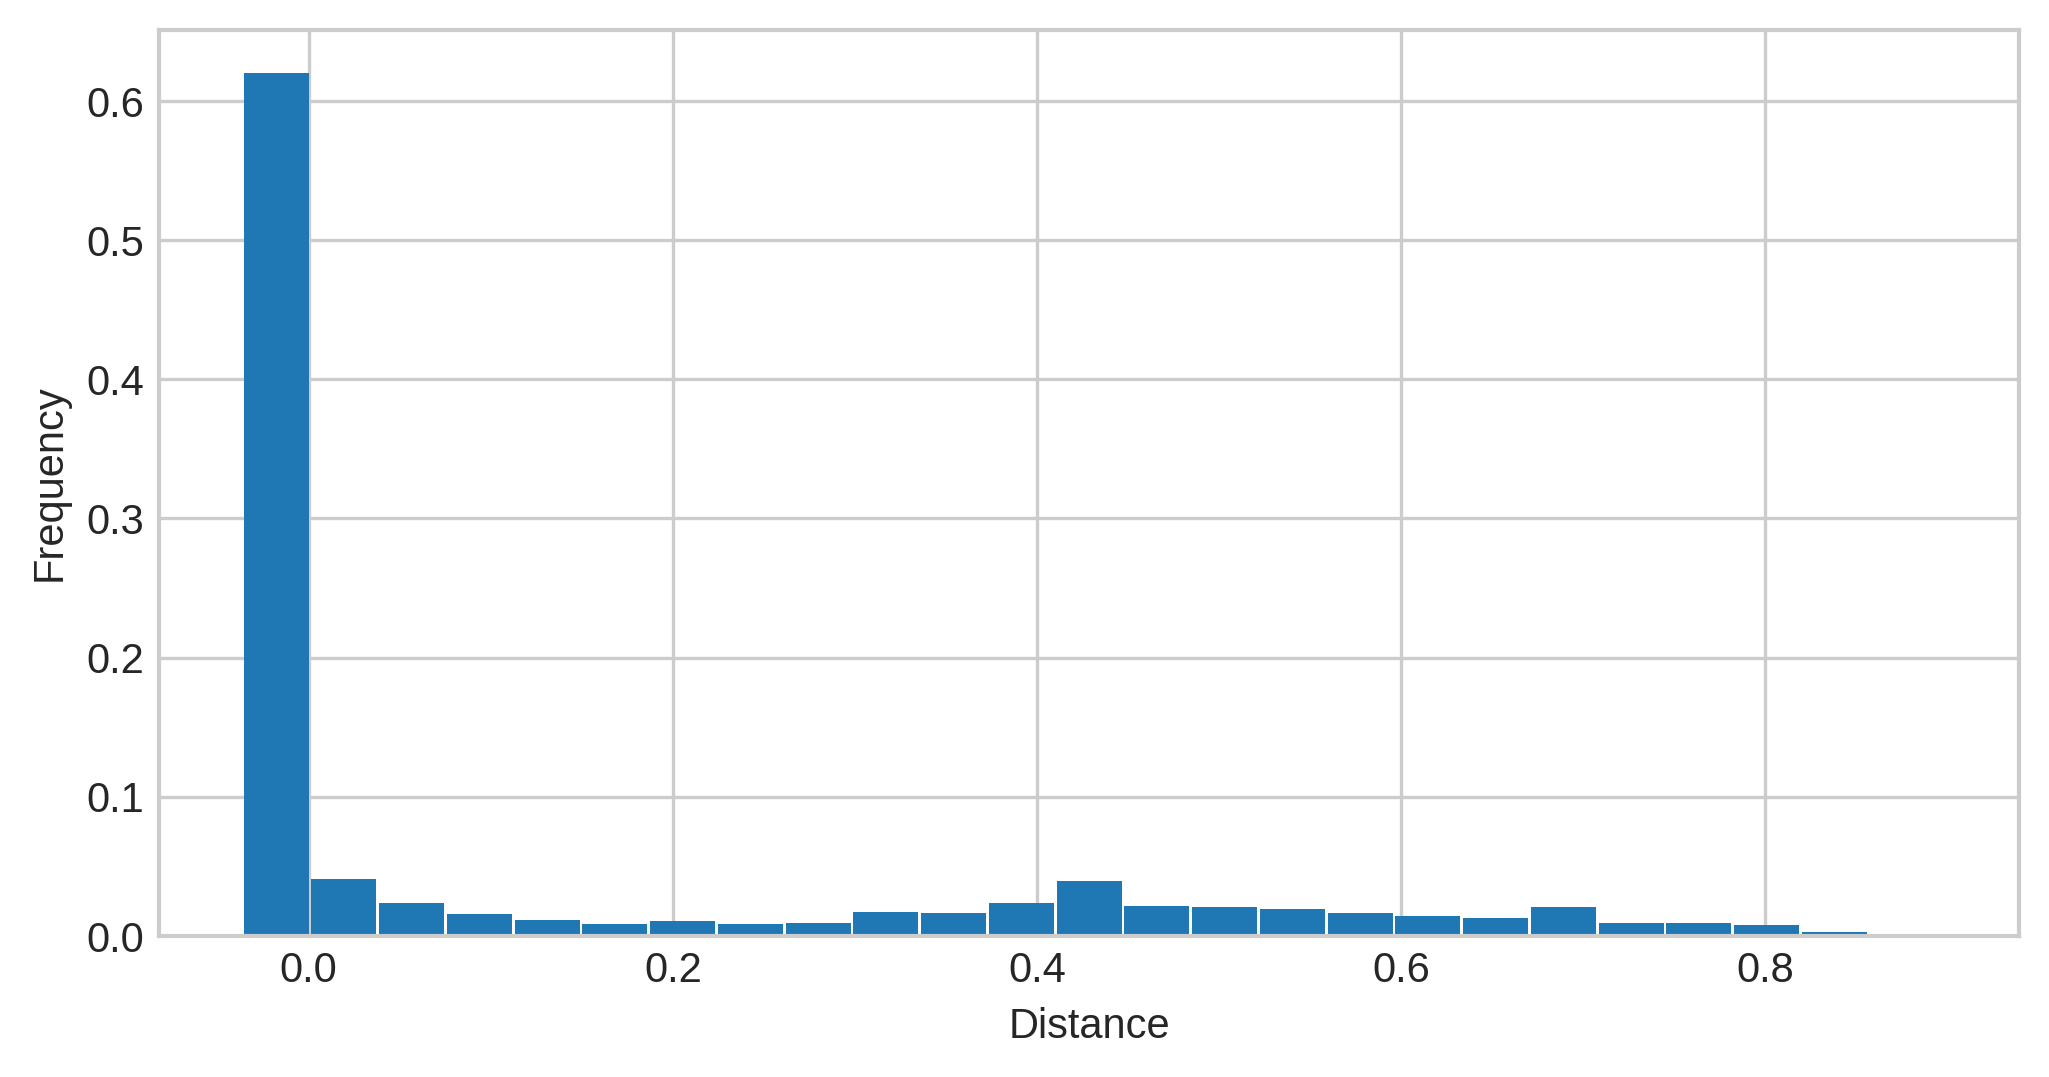

<Figure size 2400x1200 with 0 Axes>

In [42]:

HISTOGRAM_XLABEL = "Distance"
HISTOGRAM_YLABEL = "Frequency"


def histogram(distance_data, column=DISTANCE_GEOMETRIC, bins=25, save_fig=True):
    f = plt.figure()
    ax = f.add_subplot(111)
#     ax=distance_data[column].plot.hist(cumulative=False, density=10,alpha=.6, bins=300, normed=1)
    res = stats.relfreq(distance_data[column], numbins=bins)
    
    x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,res.frequency.size)
    ax.bar(x, res.frequency, width=res.binsize)
#     ax.set_xlim([x.min()*0.9, x.max()*1.05])
    plt.xlabel(HISTOGRAM_XLABEL)
    plt.ylabel(HISTOGRAM_YLABEL)

    if save_fig:
        f.savefig(FIGURE_PATH+"distance-distribution-histogram-"+column+"-"+str(bins)+".pdf", bbox_inches='tight')

    # a bit of cleanup
    plt.show()
    plt.clf()

def make_distance_descriptions(df):    
    descriprions = pd.DataFrame( [df[c].describe() for c in DISTANCES ] )
    descriprions["Relative std"] = descriprions.apply(lambda x: x['std']/x['mean'] , axis=1)
    descriprions["Variance"] = [df[c].var() for c in DISTANCES ]
    descriprions["Kurtosis"] = [df[c].kurtosis() for c in DISTANCES ]
    descriprions["Skew"] = [df[c].skew() for c in DISTANCES ]
    del descriprions["25%"]
    del descriprions["50%"]
    del descriprions["75%"]
    del descriprions["count"]
    
    return descriprions[ ['min','max','mean','std','Relative std','Skew','Kurtosis'] ]

exact_matches_count = len(matches_with_distances.loc[matches['Dist. Geometric'] == 0])
close_matches_count = len(matches_with_distances.loc[matches['Dist. Geometric'] != 0])

display(HTML("<h3>Exact to close match ratios</h3>") )
print ("total:" + str(exact_matches_count+close_matches_count) ) 
print ("exact:" + str(exact_matches_count) + "("+ str (exact_matches_count/(exact_matches_count+close_matches_count)*100 )+")")
print ("close:" + str(close_matches_count) + "("+ str (close_matches_count/(exact_matches_count+close_matches_count)*100 )+")")

# dsp(make_distance_descriptions(matches_with_distances))    
ltx(df=make_distance_descriptions(matches_with_distances), filename="distance-descriptions", to_display=True)

for col in DISTANCES:
    display(HTML("<h3>"+col+"</h3>"))
    histogram(matches_with_distances,col)   

## Segmentation accuracy

In [43]:
# aggregate not by feature but all, not all but only those features that are in matched daytaset
# filters = matches_with_distances
filter = matches["Man Features"].unique()

exact_matches_count = len(matches_with_distances.loc[matches['Dist. Geometric'] == 0])
close_matches_count = len(matches_with_distances.loc[matches['Dist. Geometric'] != 0])
combined_matches_count = exact_matches_count + close_matches_count
# filterign the 

manual_nm_count = len(manual_nm)
parse_nm_count = len(parse_nm)

manual_nm_count_filtered = len(manual_nm.loc[manual_nm["Features"].isin(filter) ]  )
parse_nm_count_filtered = len(parse_nm.loc[parse_nm["Features"].isin(filter) ]  )

not_covered_manual = manual_nm.loc[~manual_nm["Features"].isin(filter)]["Features"].unique()
not_covered_parse = parse_nm.loc[~parse_nm["Features"].isin(filter)]["Features"].unique()

print "Not covered manual",not_covered_manual
print "Manual all/filtered", manual_nm_count, manual_nm_count_filtered

print "Not covered parse",not_covered_parse
print "Parse all/filtered", parse_nm_count, parse_nm_count_filtered

cols = ["Item",EXACT_MATCH_COLUMN, 
       CLOSE_MATCH_COLUMN, 
       COMBINED_MATCH_COLUMN,
       MANUAL_COLUMN, PARSE_COLUMN]

totals = pd.DataFrame(
[
 {
 COMBINED_MATCH_COLUMN: exact_matches_count, 
#  CLOSE_MATCH_COLUMN:close_matches_count,
#  COMBINED_MATCH_COLUMN:combined_matches_count,
 MANUAL_COLUMN:manual_nm_count_filtered,
 PARSE_COLUMN:parse_nm_count_filtered,
 },
 {
# EXACT_MATCH_COLUMN: exact_matches_count, 
#  CLOSE_MATCH_COLUMN:close_matches_count, 
 COMBINED_MATCH_COLUMN:combined_matches_count,
 MANUAL_COLUMN:manual_nm_count_filtered,
 PARSE_COLUMN:parse_nm_count_filtered                                
}],index=pd.Index([EXACT_MATCH_COLUMN,COMBINED_MATCH_COLUMN]), 
    columns = [COMBINED_MATCH_COLUMN, MANUAL_COLUMN, PARSE_COLUMN]) # , 
 
ltx(totals, filename="segmentation-stats",caption="Segmentation statistics", to_display=True)

# make_stats2(totals,"segmentation-accuracy", filters=filters, make_exact_also=True)

f1_stats = [ (
              precission(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered),
              recall(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered),
              f1(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)),
             (
              precission(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered),
              recall(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered),
              f1(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)),
           ]
f1_stats_df = pd.DataFrame(f1_stats, 
                           columns=[PRECISSION_COLUMN,RECALL_COLUMN,F1_COLUMN],
                           index=[EXACT_MATCH_COLUMN,COMBINED_MATCH_COLUMN,])

ltx(f1_stats_df, filename="segmentation-accuracy",caption="Segmentation accuracy", to_display=True)

display(HTML("<h3> Segmentation accuracy statistics (non-filtered, exact matches) </h3>"))
print "Precision:", precission(exact_matches_count,manual_nm_count, parse_nm_count)
print "Recall:", recall(exact_matches_count,manual_nm_count, parse_nm_count)
print "F1:", f1(exact_matches_count,manual_nm_count, parse_nm_count)

display(HTML("<h3> Segmentation accuracy statistics (non-filtered, combined matches) </h3>"))
print "Precision:", precission(combined_matches_count,manual_nm_count, parse_nm_count)
print "Recall:", recall(combined_matches_count,manual_nm_count, parse_nm_count)
print "F1:", f1(combined_matches_count,manual_nm_count, parse_nm_count)

display(HTML("<h3> Segmentation accuracy statistics (filtered, exact matches) </h3>"))
print "Precision:", precission(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)
print "Recall:", recall(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)
print "F1:", f1(exact_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)

display(HTML("<h3> Segmentation accuracy statistics (filtered, combined matches) </h3>"))
print "Precision:", precission(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)
print "Recall:", recall(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)
print "F1:", f1(combined_matches_count,manual_nm_count_filtered, parse_nm_count_filtered)


Not covered manual ['constituent' 'conjunction' 'coordinating-conjunction' 'comment-adjunct'
 'conjunctive-adjunct' 'subordinating-conjunction' 'other-adjunct'
 'usuality' 'verb-particle' 'complement-indirect' 'participant' 'process'
 'preposition' 'word' 'polarity-marker' 'preposition-of-location'
 'expectancy-limiting' 'nominal-clause']
Manual all/filtered 4393 1319
Not covered parse ['posessor' 'word' 'circumstance' 'ordinal-numerative' 'epithet'
 'classifier' 'thing' 'cardinal-numerative' 'process' 'deictic'
 'qualifier' 'pre-deictic' 'apposition' 'modal' 'total' 'expletive'
 'complement-indirect']
Parse all/filtered 8318 4332


Precision: 0.44483748248
Recall: 0.60273105444
F1: 0.511885104259


Precision: 0.571038110464
Recall: 0.715957584379
F1: 0.635338669421


Precision: 0.606074383923
Recall: 0.834794589178
F1: 0.702281228597


Precision: 0.718792599805
Recall: 0.893560361524
F1: 0.796704680361


# Constituency evaluation

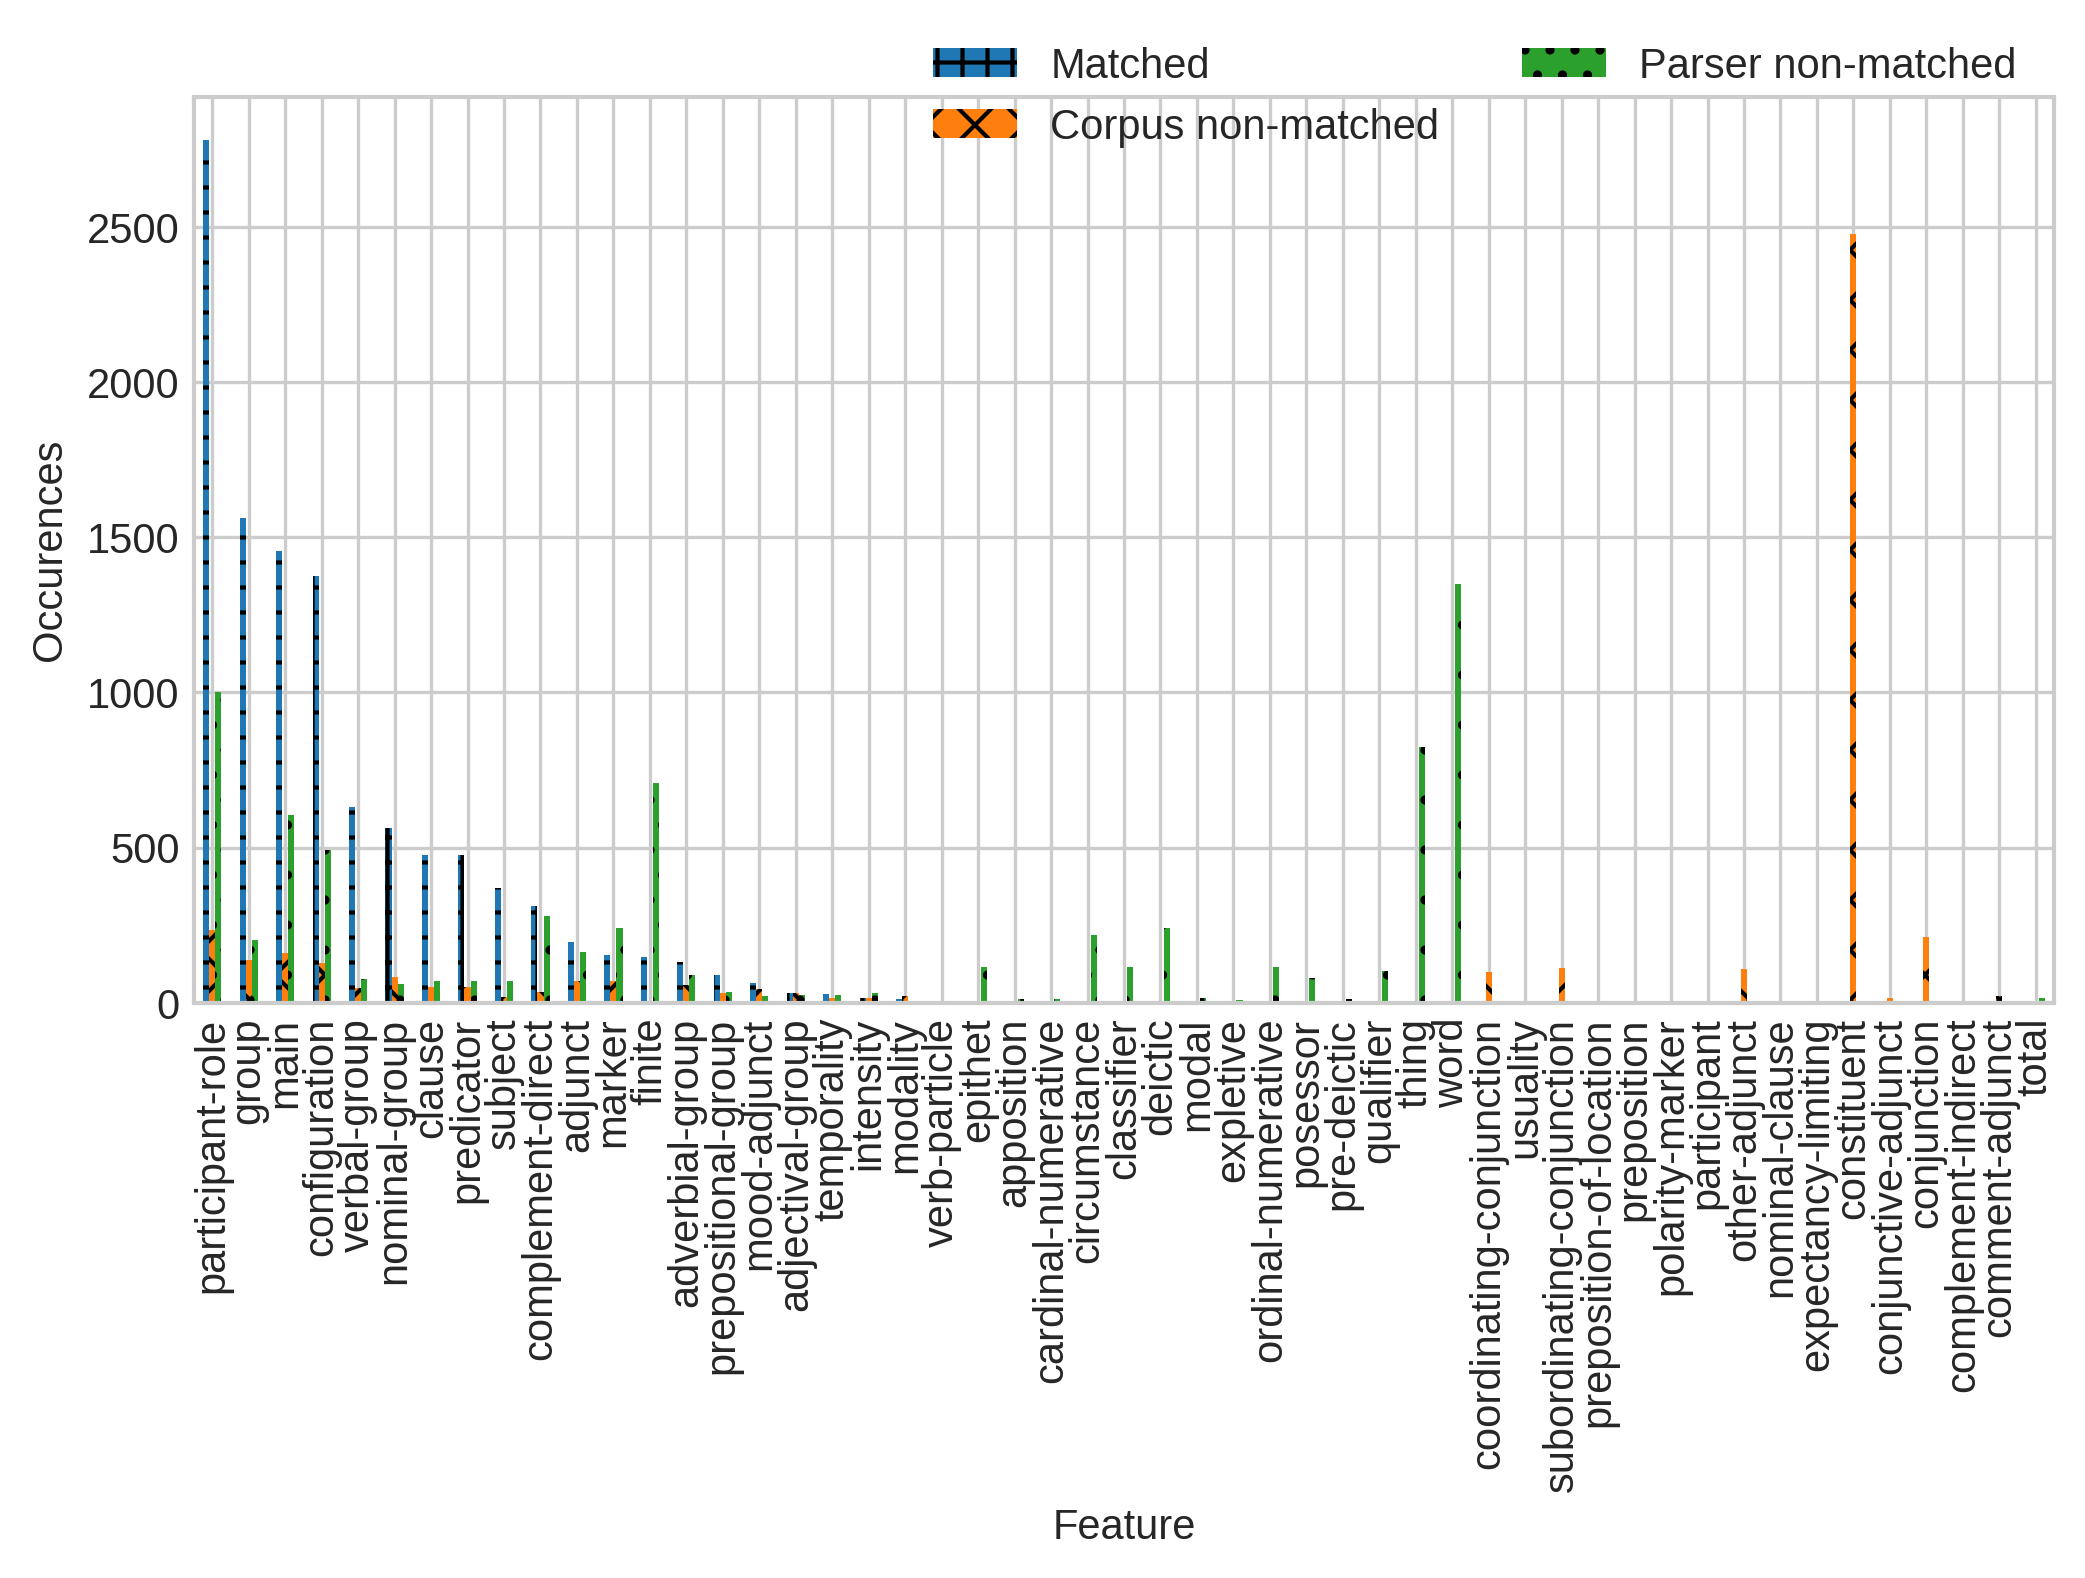

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

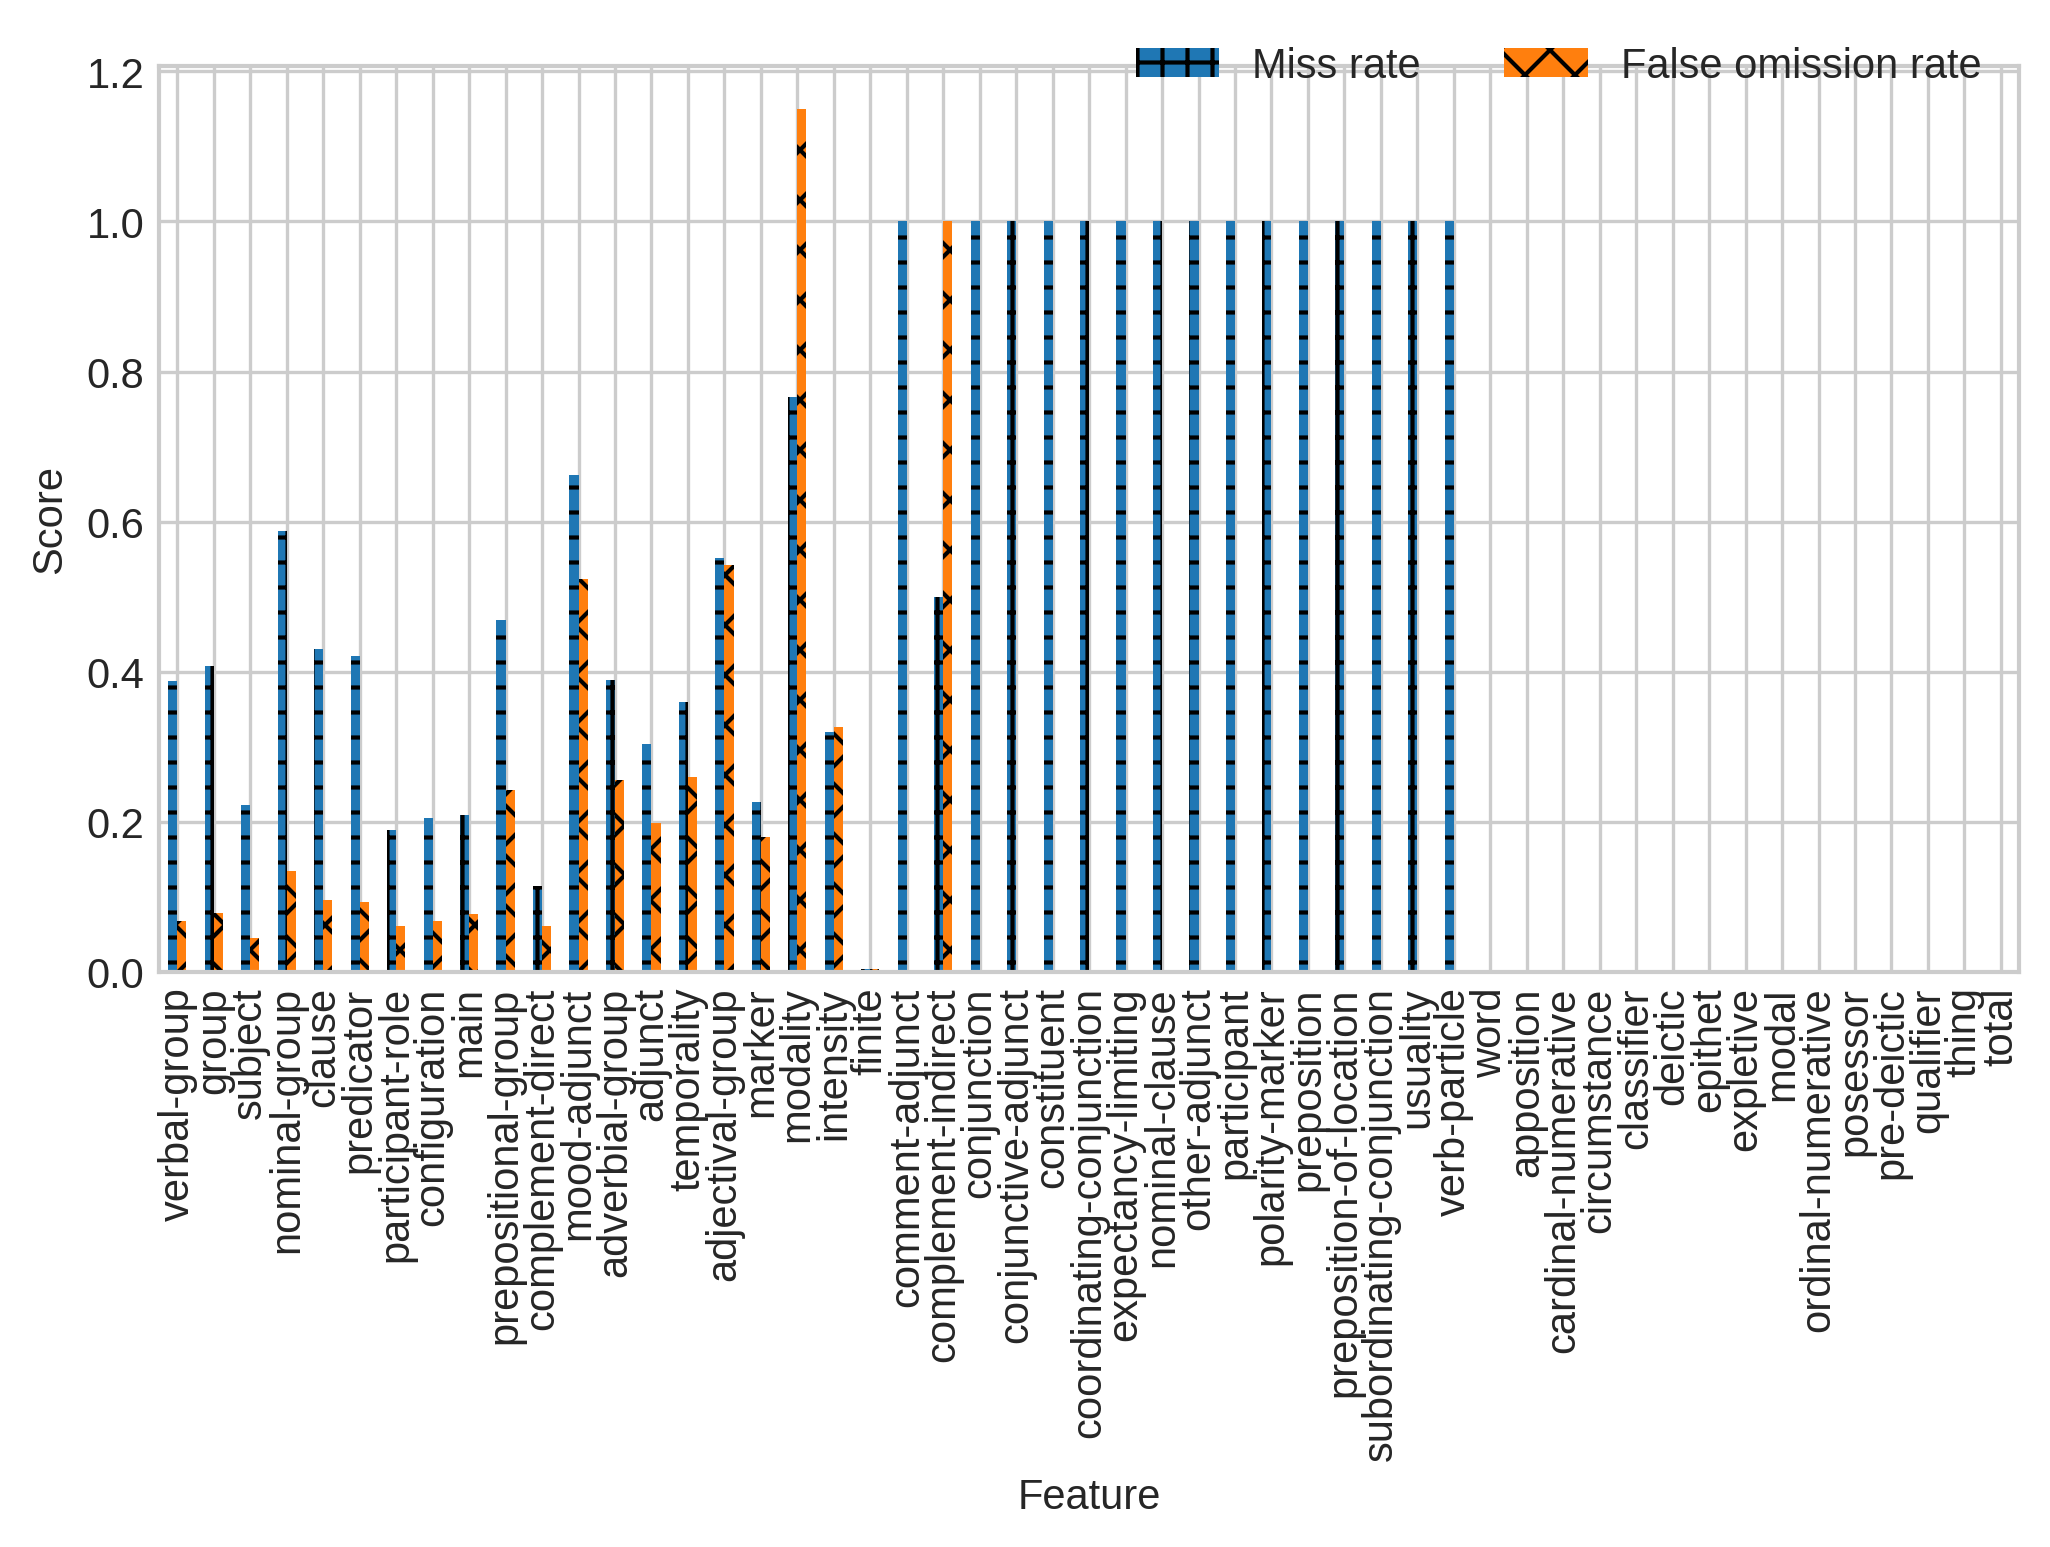

<Figure size 2400x1200 with 0 Axes>

In [29]:
# ---------
# matches, manual_nm, parse_nm = read_batch( OCD_const_file_list)
matches, manual_nm, parse_nm = read_batch( OCD_const_file_list + OE1_const_file_list + BTC_const_file_list)
aggregate = aggregate_data_by_feature( *drop_features(matches, manual_nm, parse_nm, drops=["verb","process"]) )
# matches, manual_nm, parse_nm = filter_batch(matches, manual_nm, parse_nm)
# ---------


# aggregate = aggregate.join(relative_statistics_combined(aggregate) )

# dsp(aggregate[:10])

# make_stats2(aggregate, "constituency-general")

## Unit types 

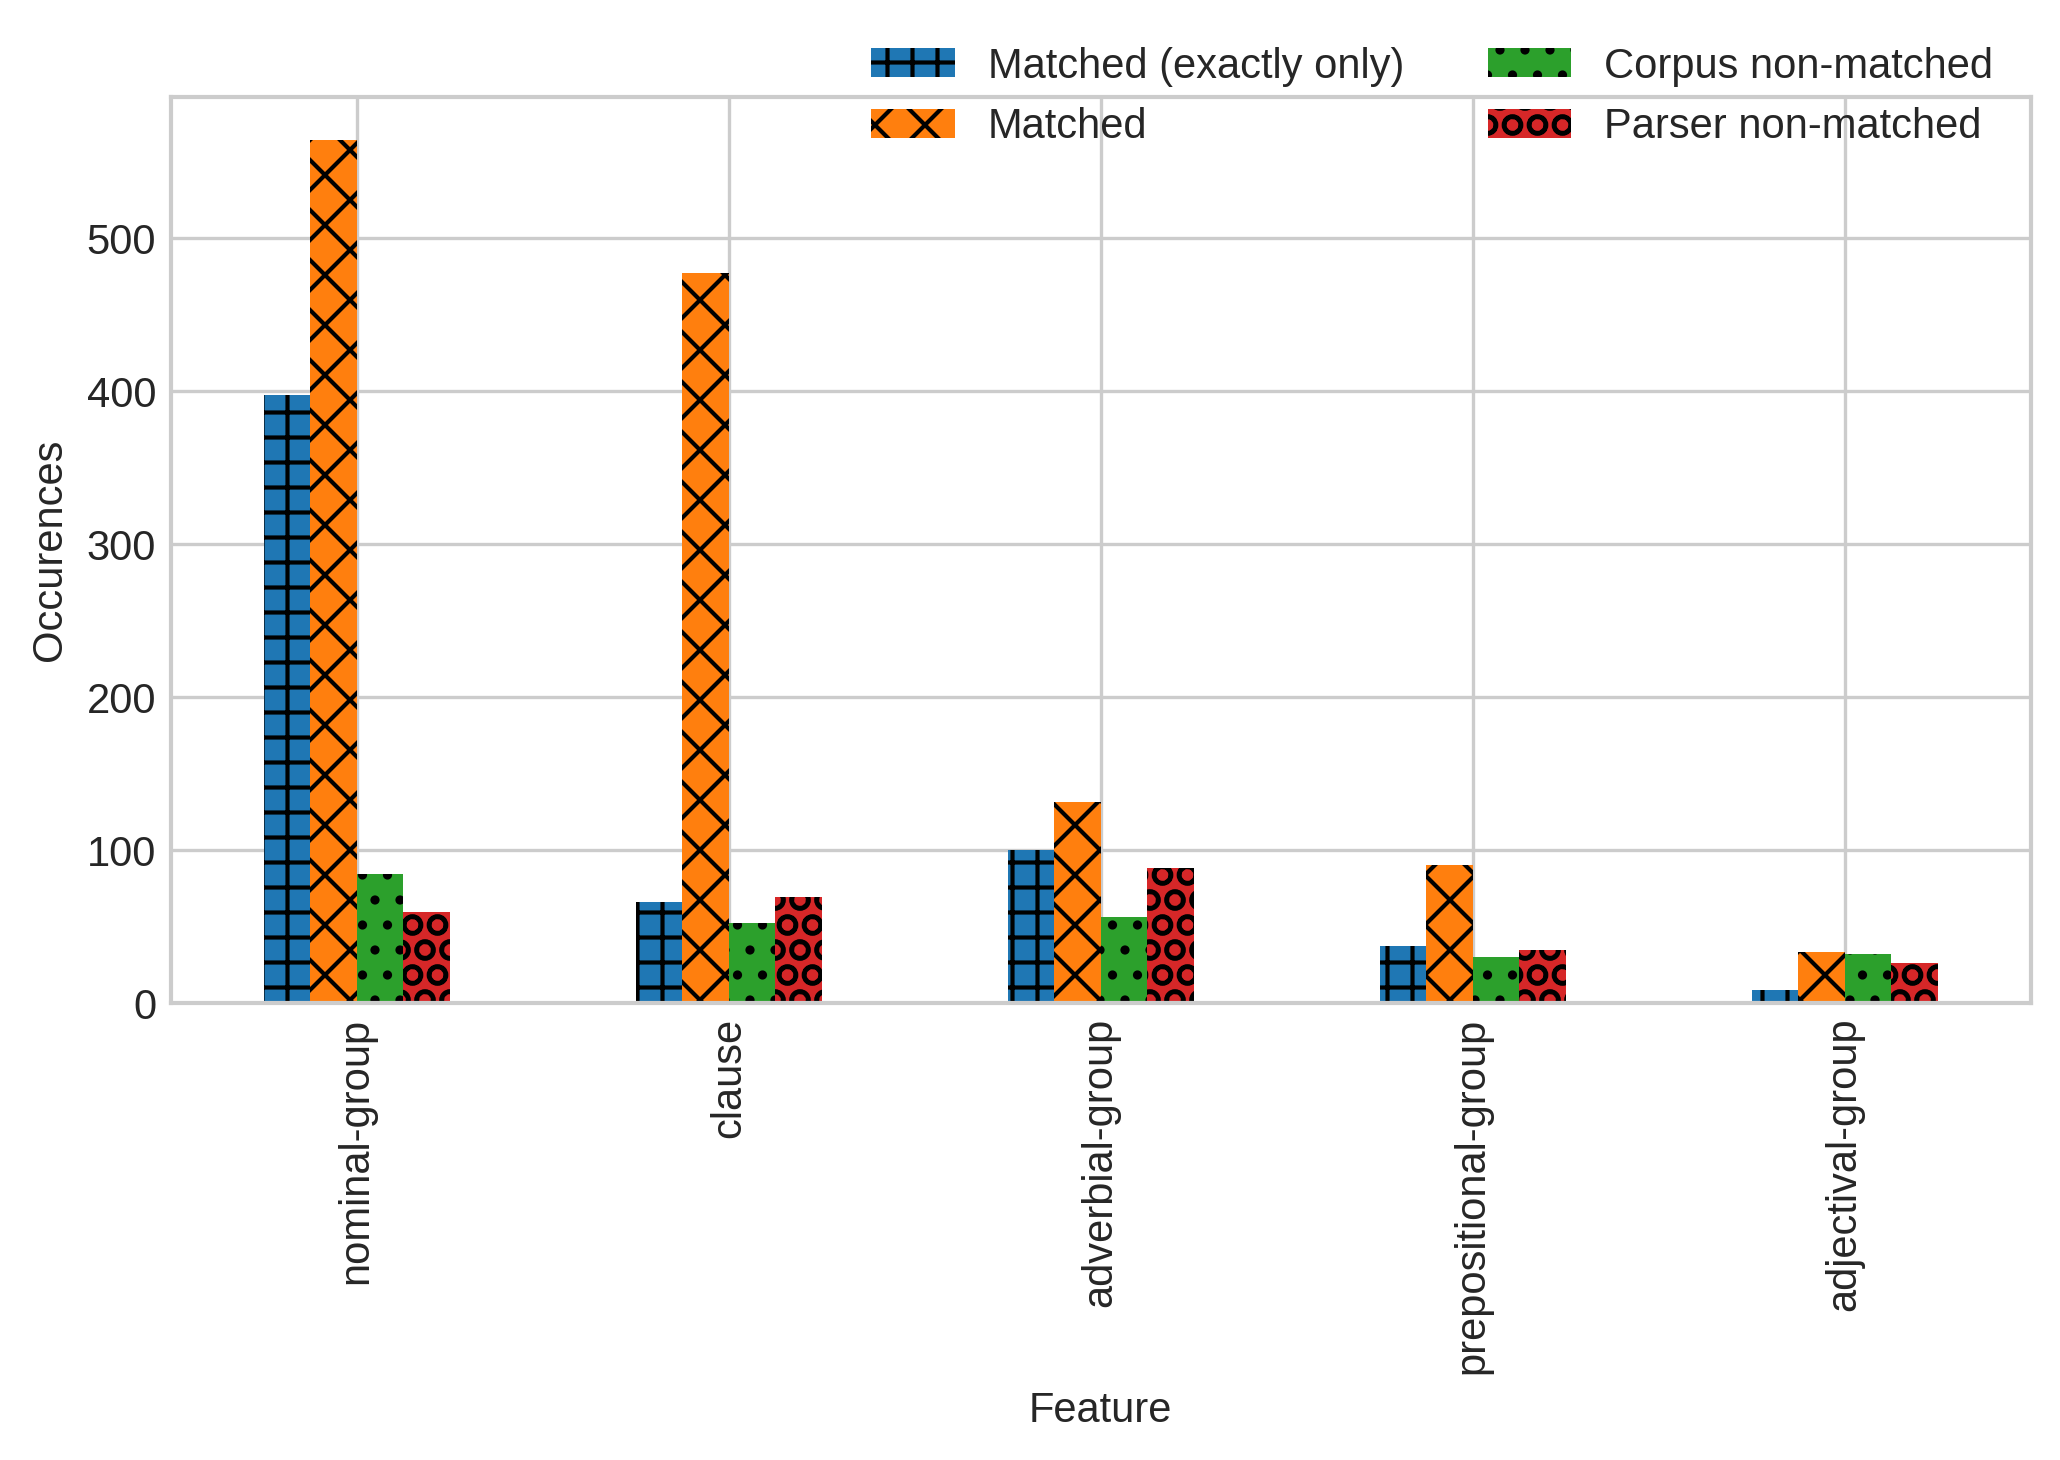

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

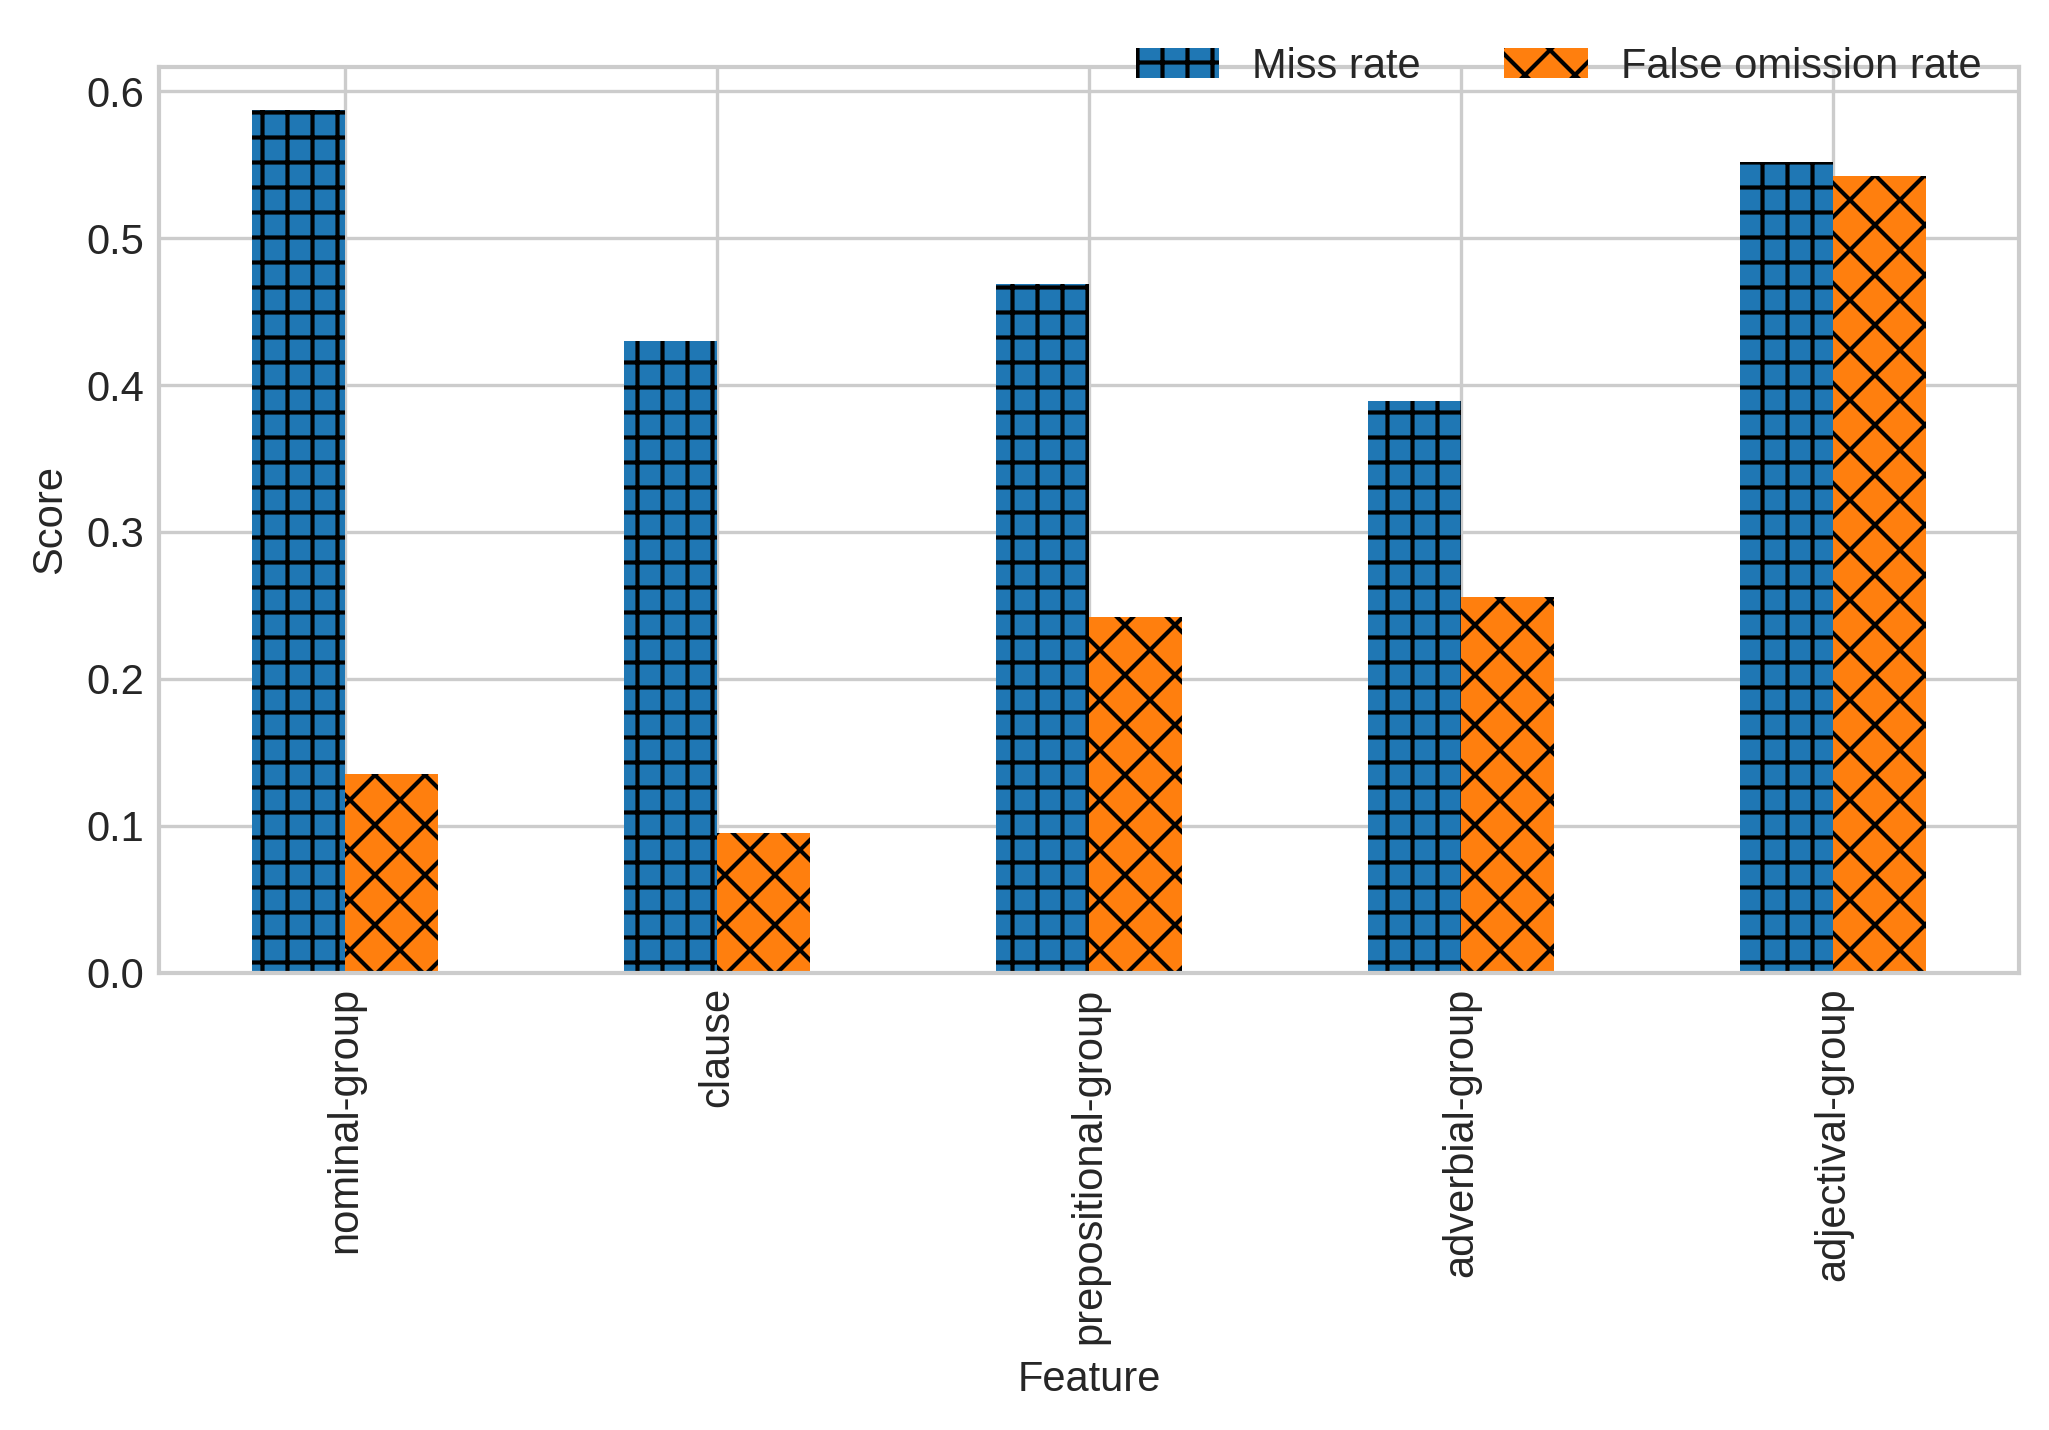

<Figure size 2400x1200 with 0 Axes>

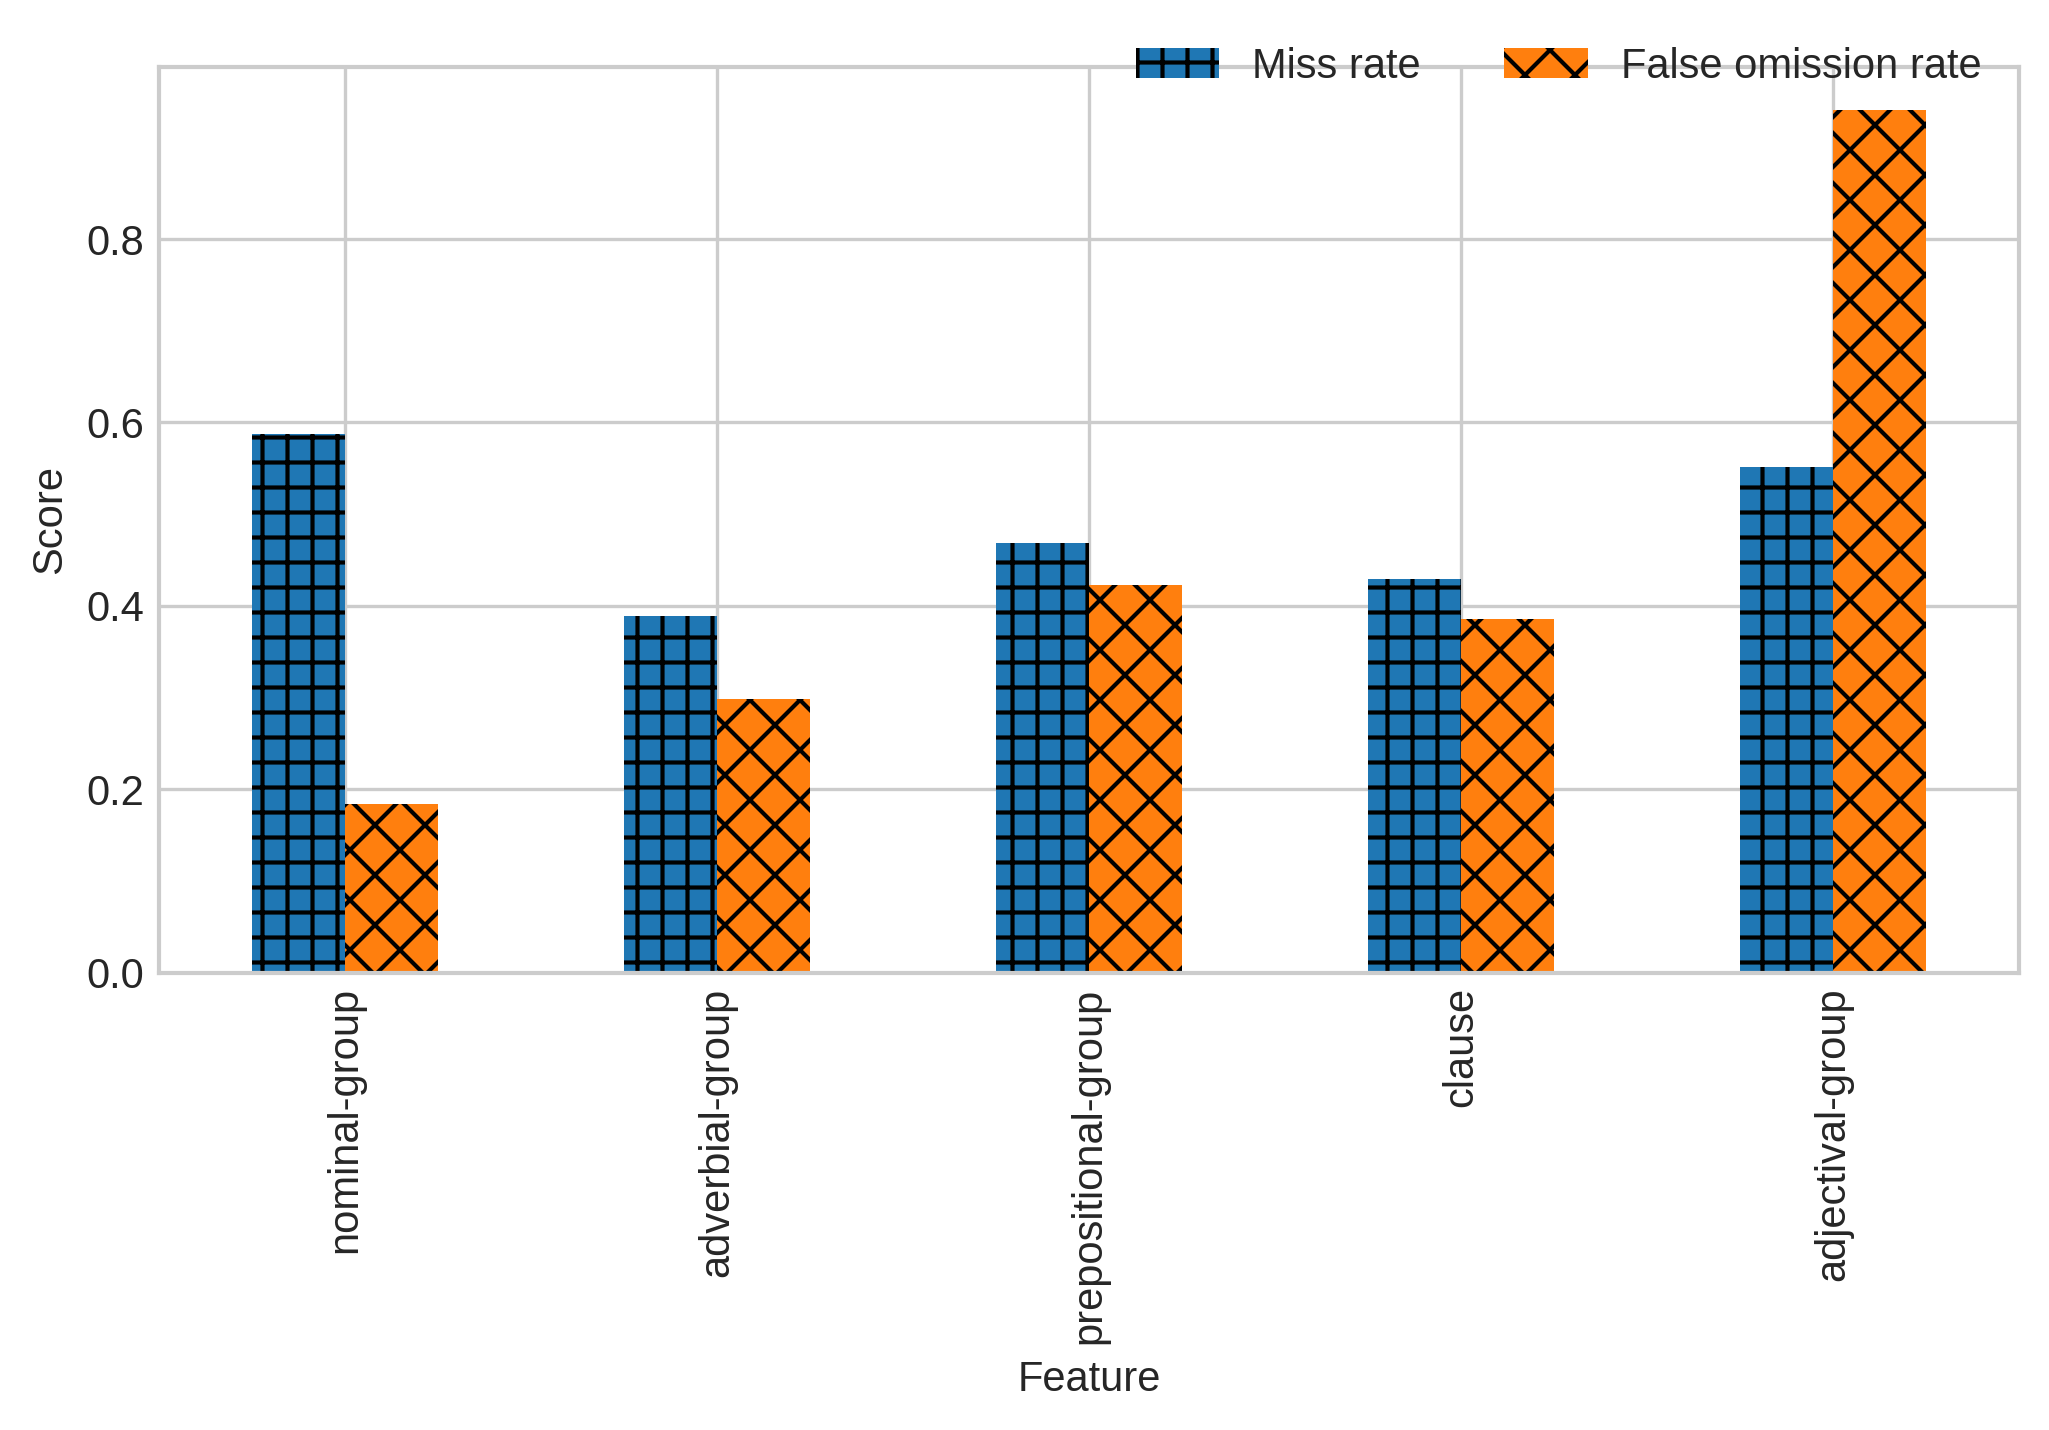

<Figure size 2400x1200 with 0 Axes>

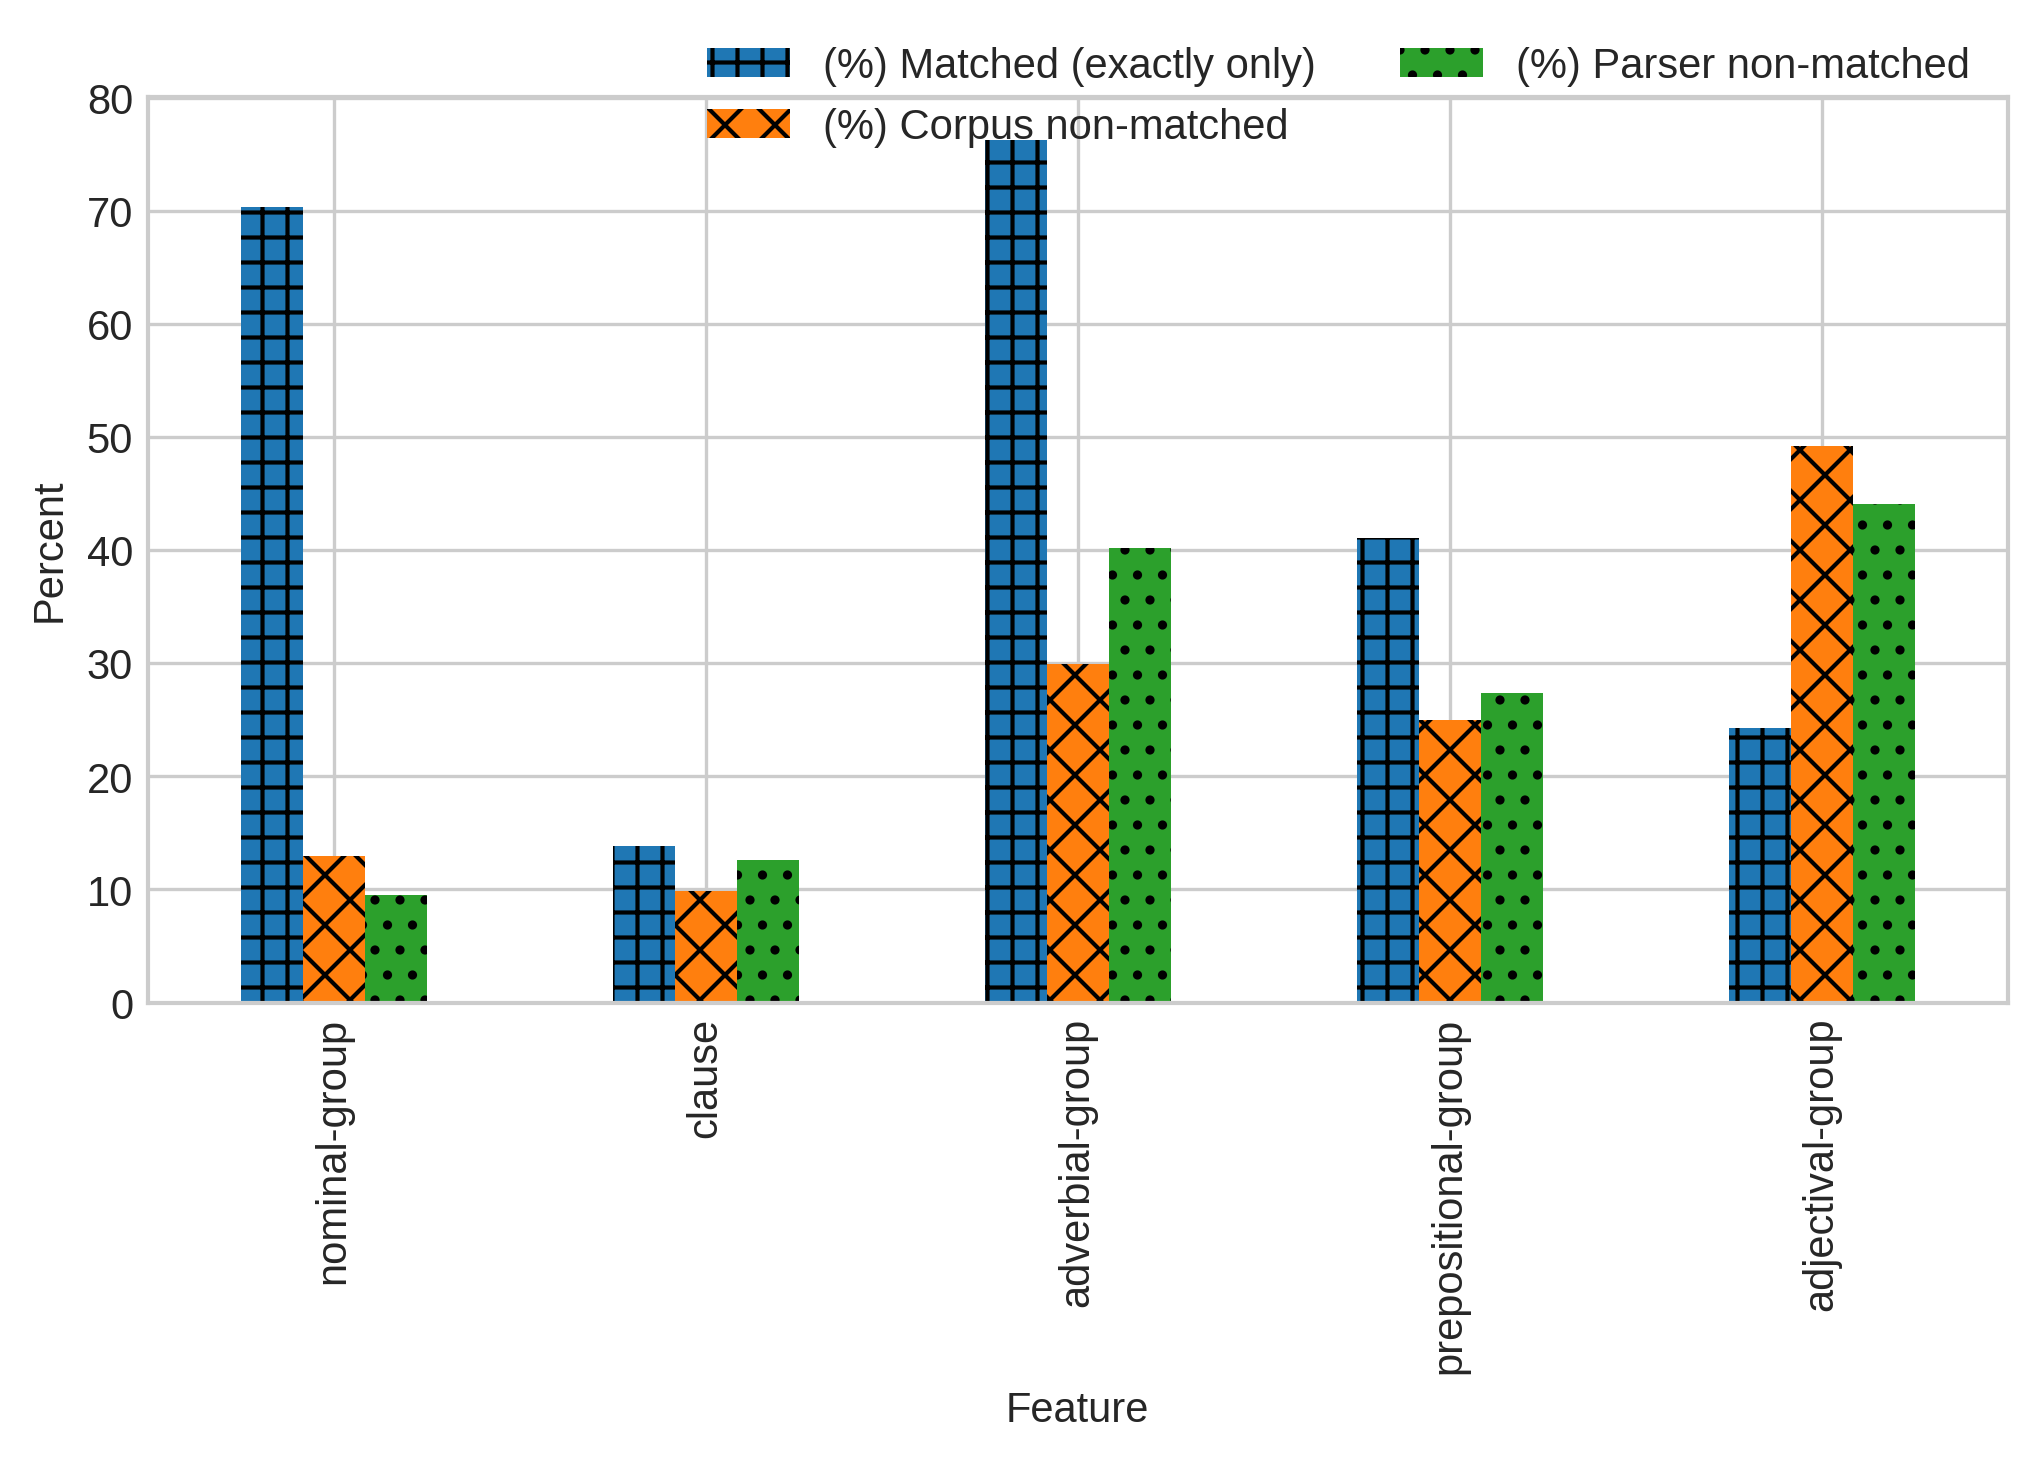

KeyError: ('(%) Matched (exactly only)', '(%) Corpus non-matched', '(%) Parser non-matched')

<Figure size 2400x1200 with 0 Axes>

In [26]:
aggregate = aggregate_data_by_feature(matches, manual_nm, parse_nm)
filters=["clause","prepositional-group","nominal-group",
                            "nominal-group","adjectival-group","adverbial-group",
#                            "verbal-group",
                           ]

# print relative_statistics_exact(aggregate)

make_stats2(aggregate, "unit-types", filters=filters, make_exact_also=True, make_relative=True)

## Unit elements - Mood 

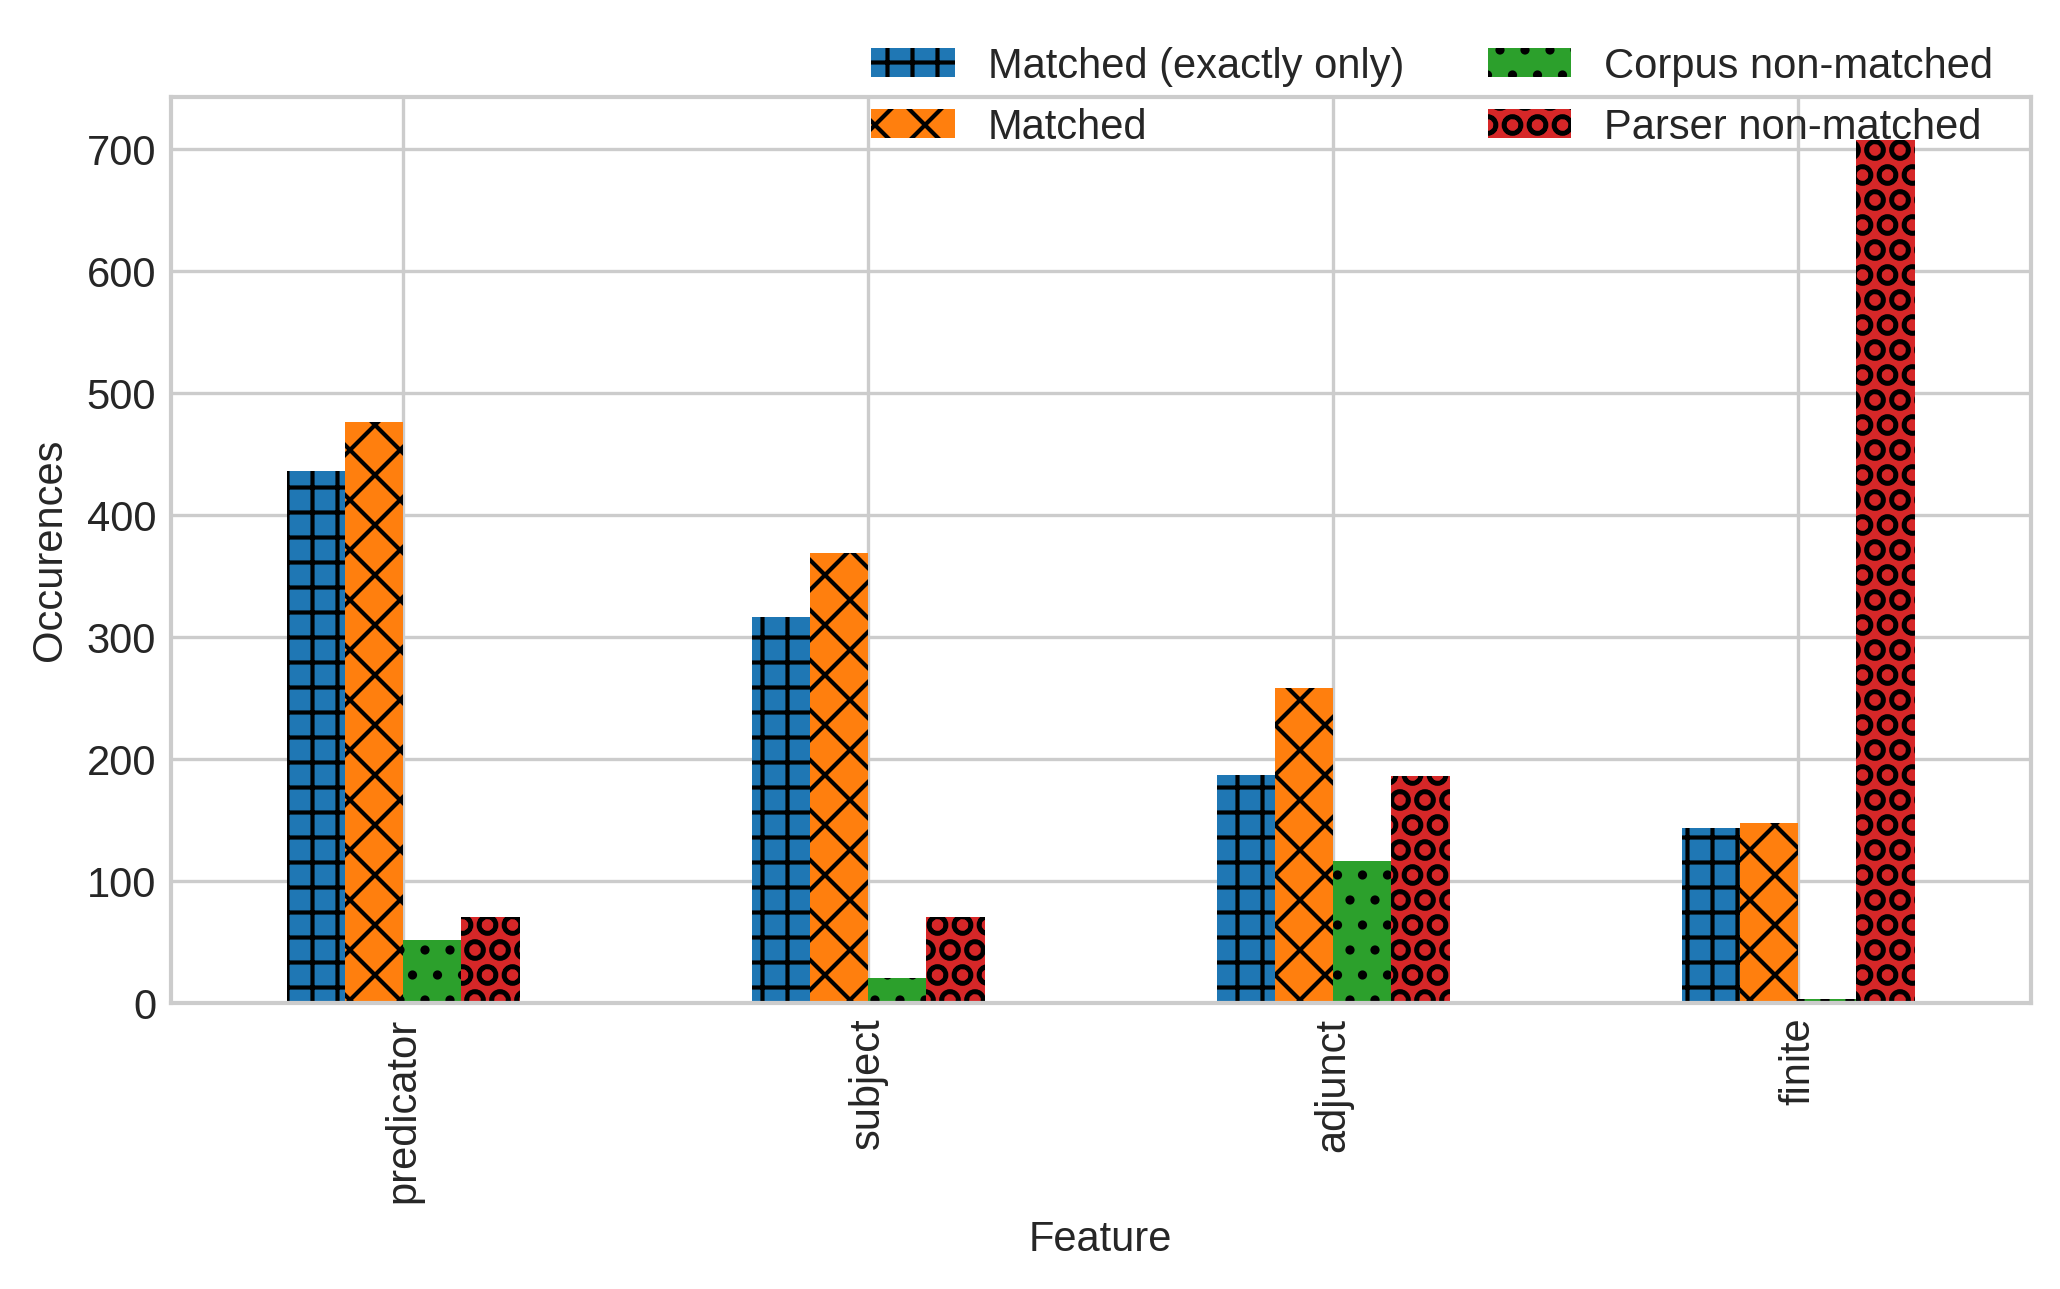

<Figure size 2400x1200 with 0 Axes>

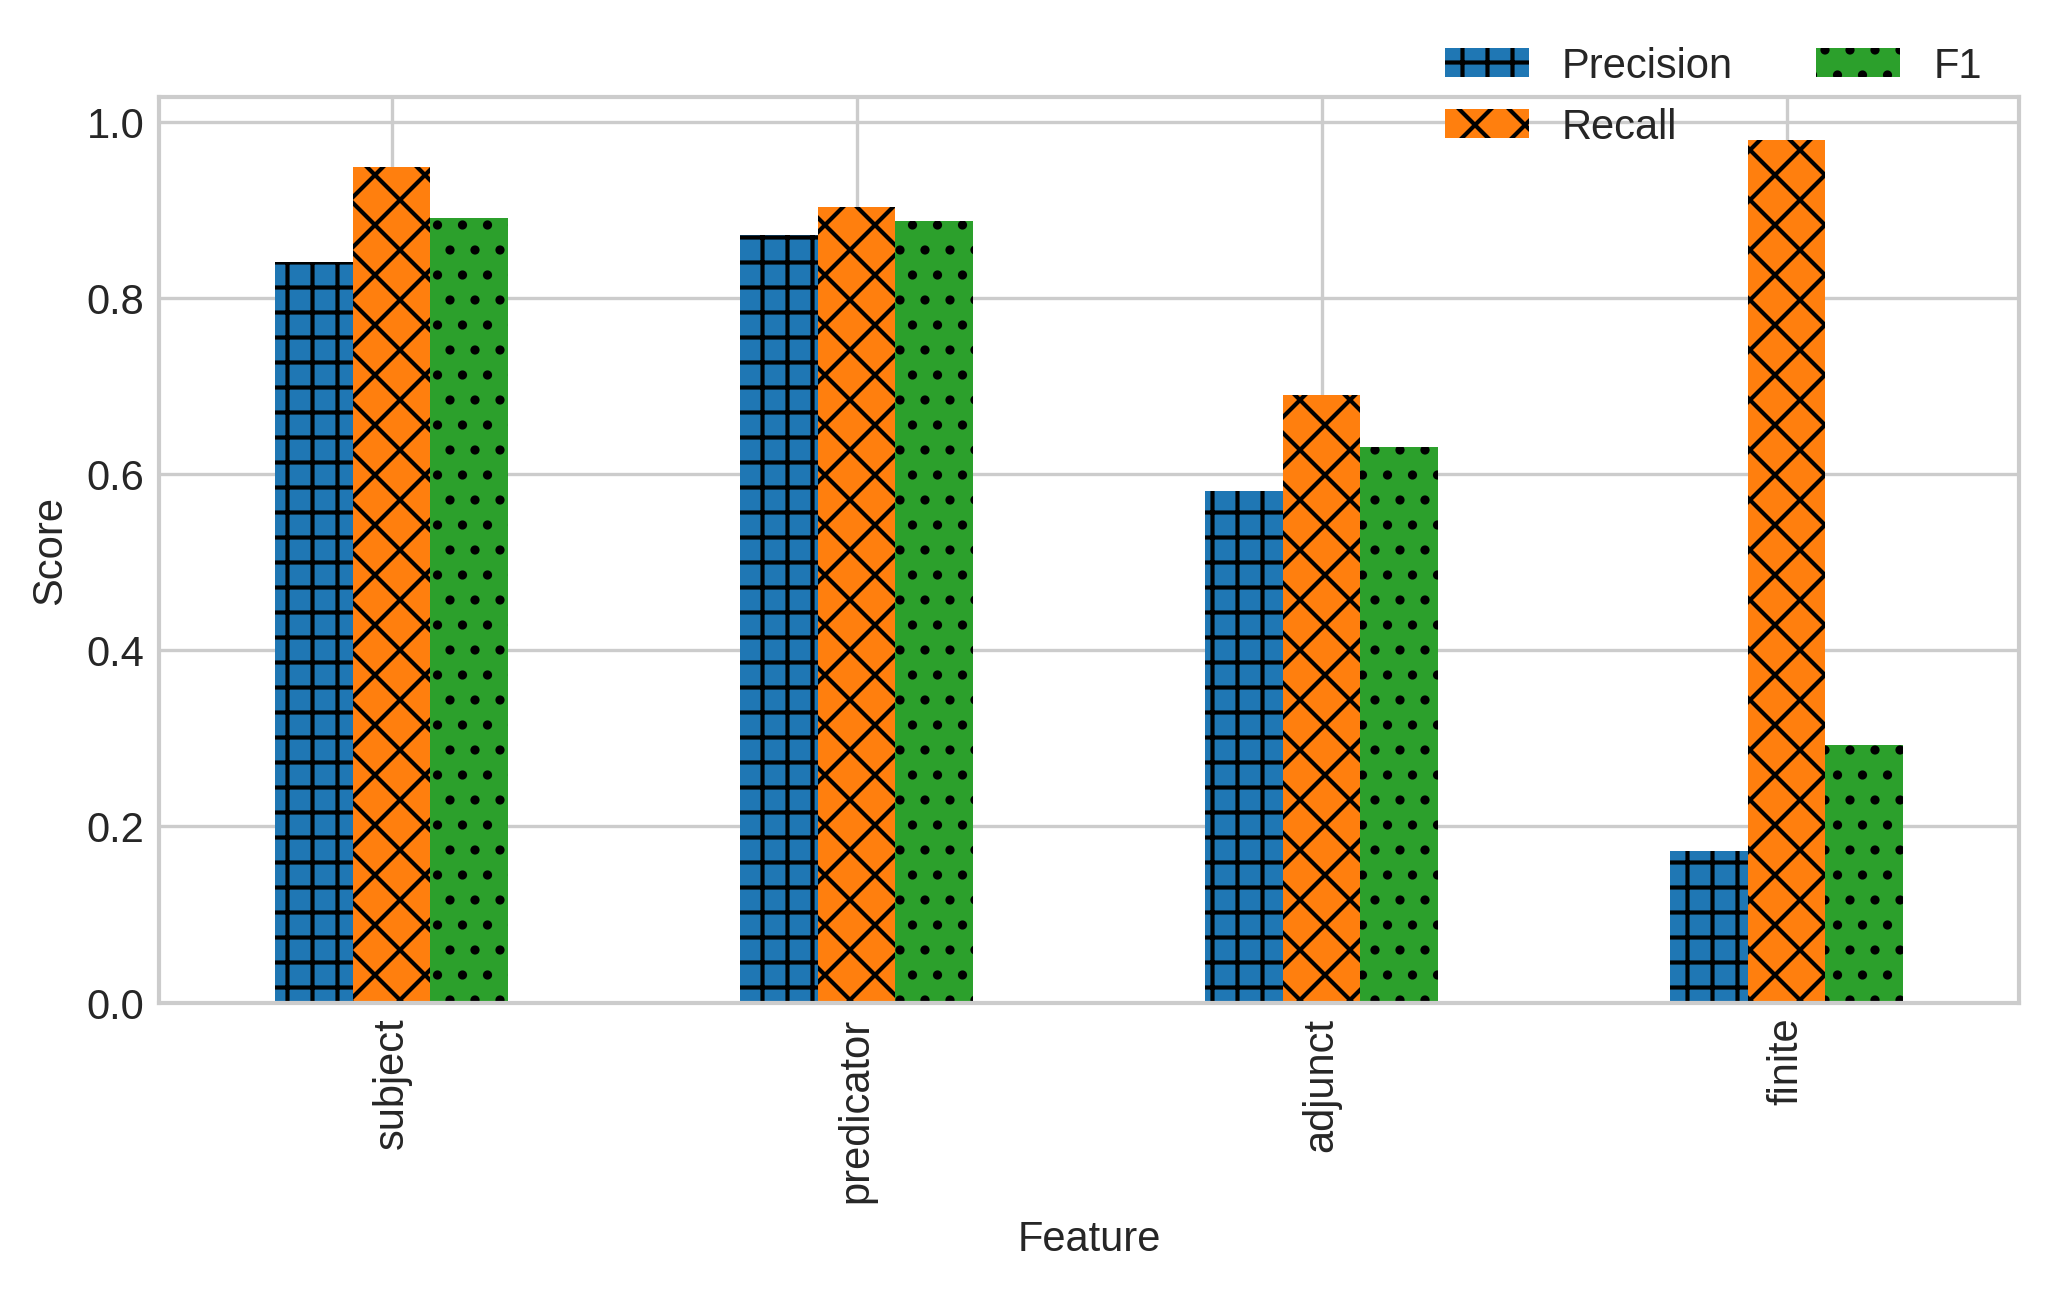

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

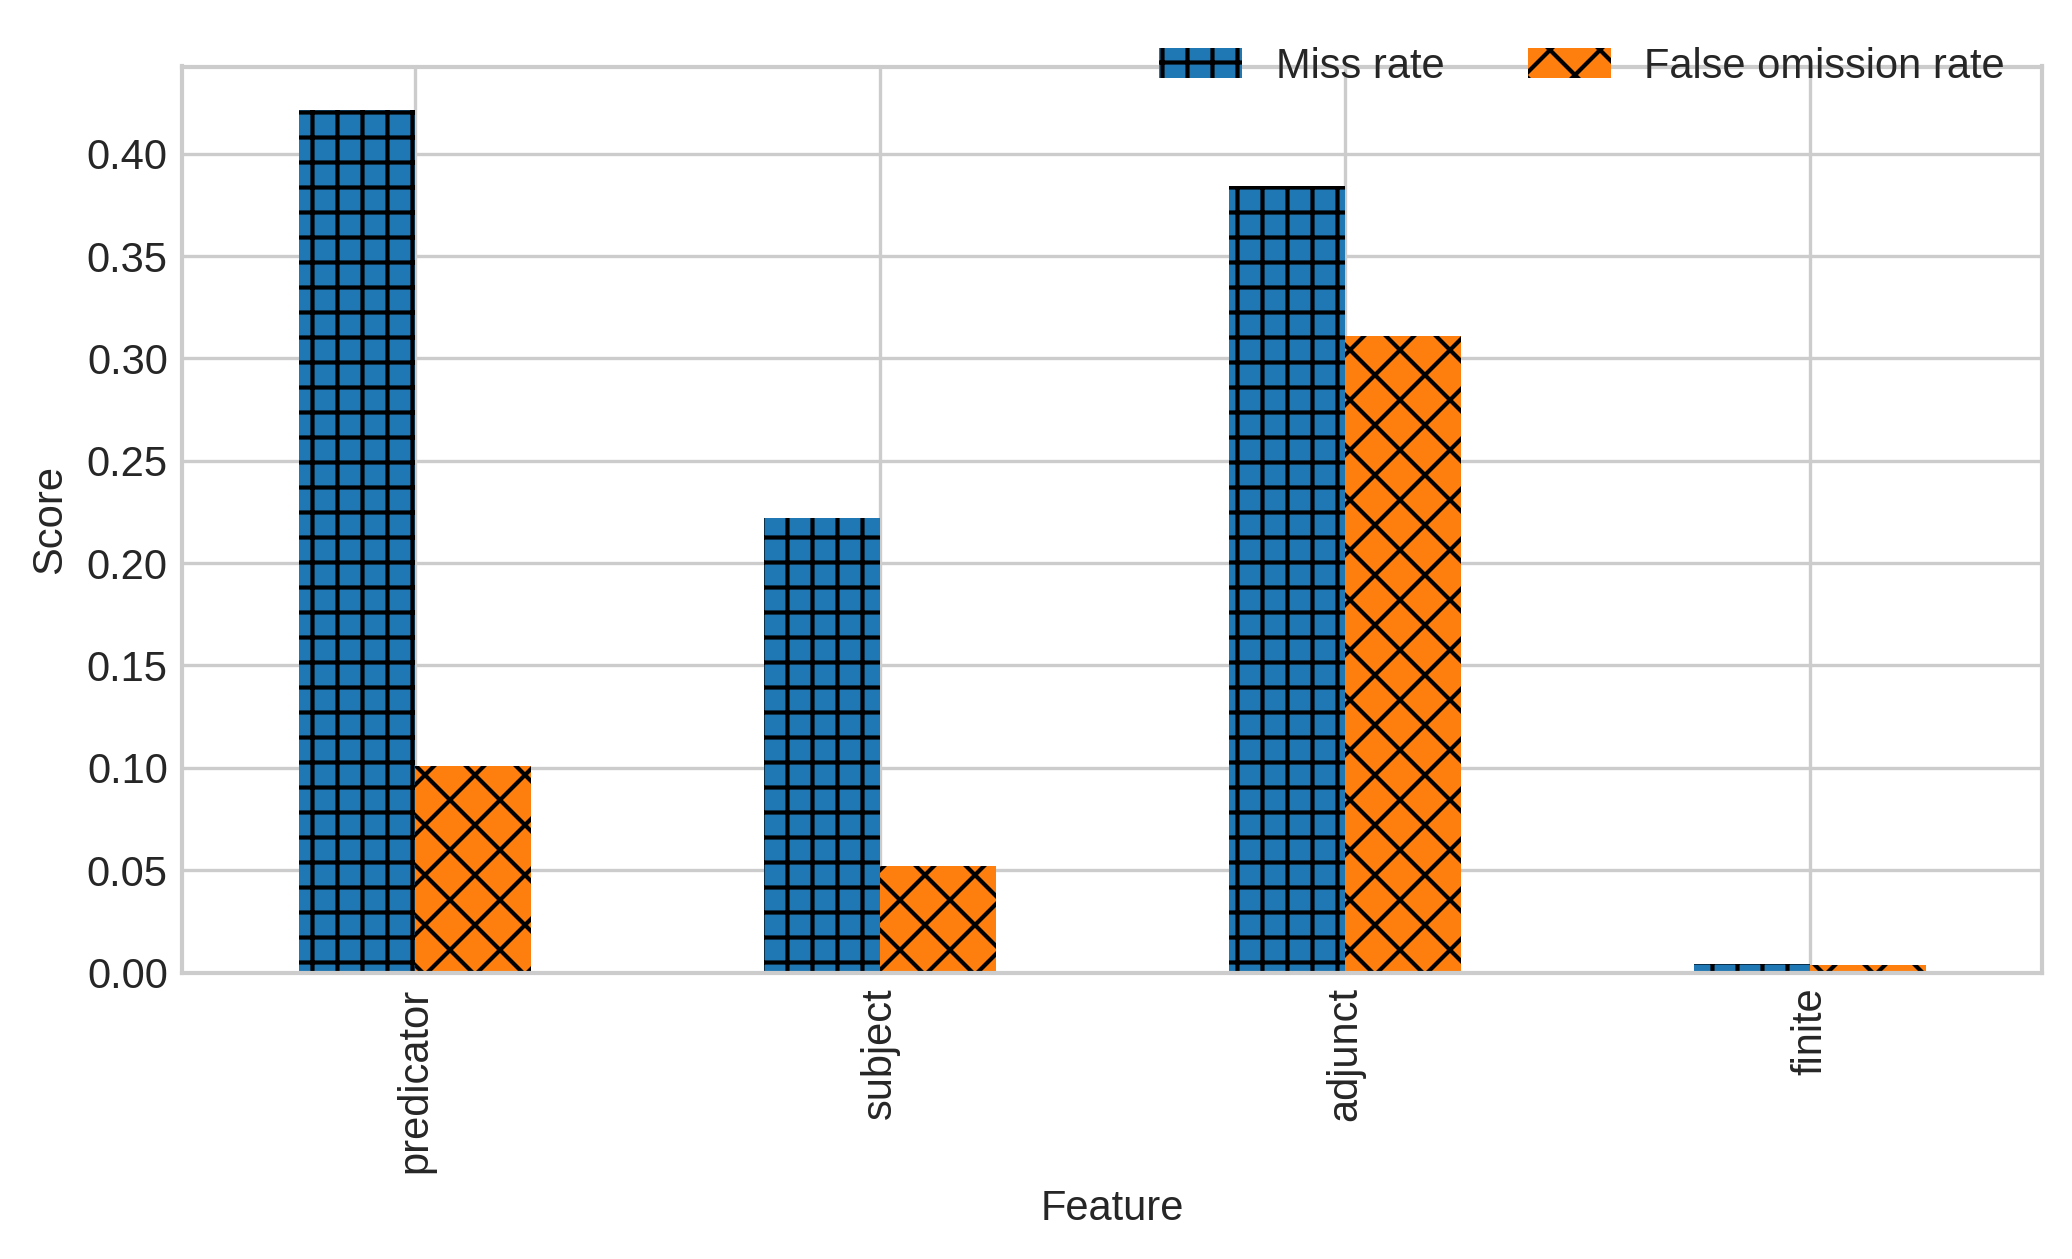

<Figure size 2400x1200 with 0 Axes>

In [53]:
# aggregate = aggregate_data_by_feature(matches, manual_nm, parse_nm)

filters=["predicator","subject","adjunct","complement-direct","complement"
                                       "complement-indirect","mood-adjunct", "finite"
                           ]
#  rename complement-direct into complement, and mood-ajunct into adjunct
feature_replacement={"complement-direct":"complement",
                    "complement-indirect":"complement",
                    "mood-adjunct":"adjunct",
                    "complement-direct":"complement",
                    "complement-indirect":"complement",
                    "mood-adjunct":"adjunct",
                    "complement-direct":"complement",
                    "complement-indirect":"complement",
                    "mood-adjunct":"adjunct",}

aggregate = aggregate_data_by_feature( *rename_features(matches, manual_nm, parse_nm, feature_replacement) )

# making stats with renamed features
make_stats2(aggregate, "unit-elements-mood", filters=filters, make_exact_also=True)

## Unit elements - Transitivity 

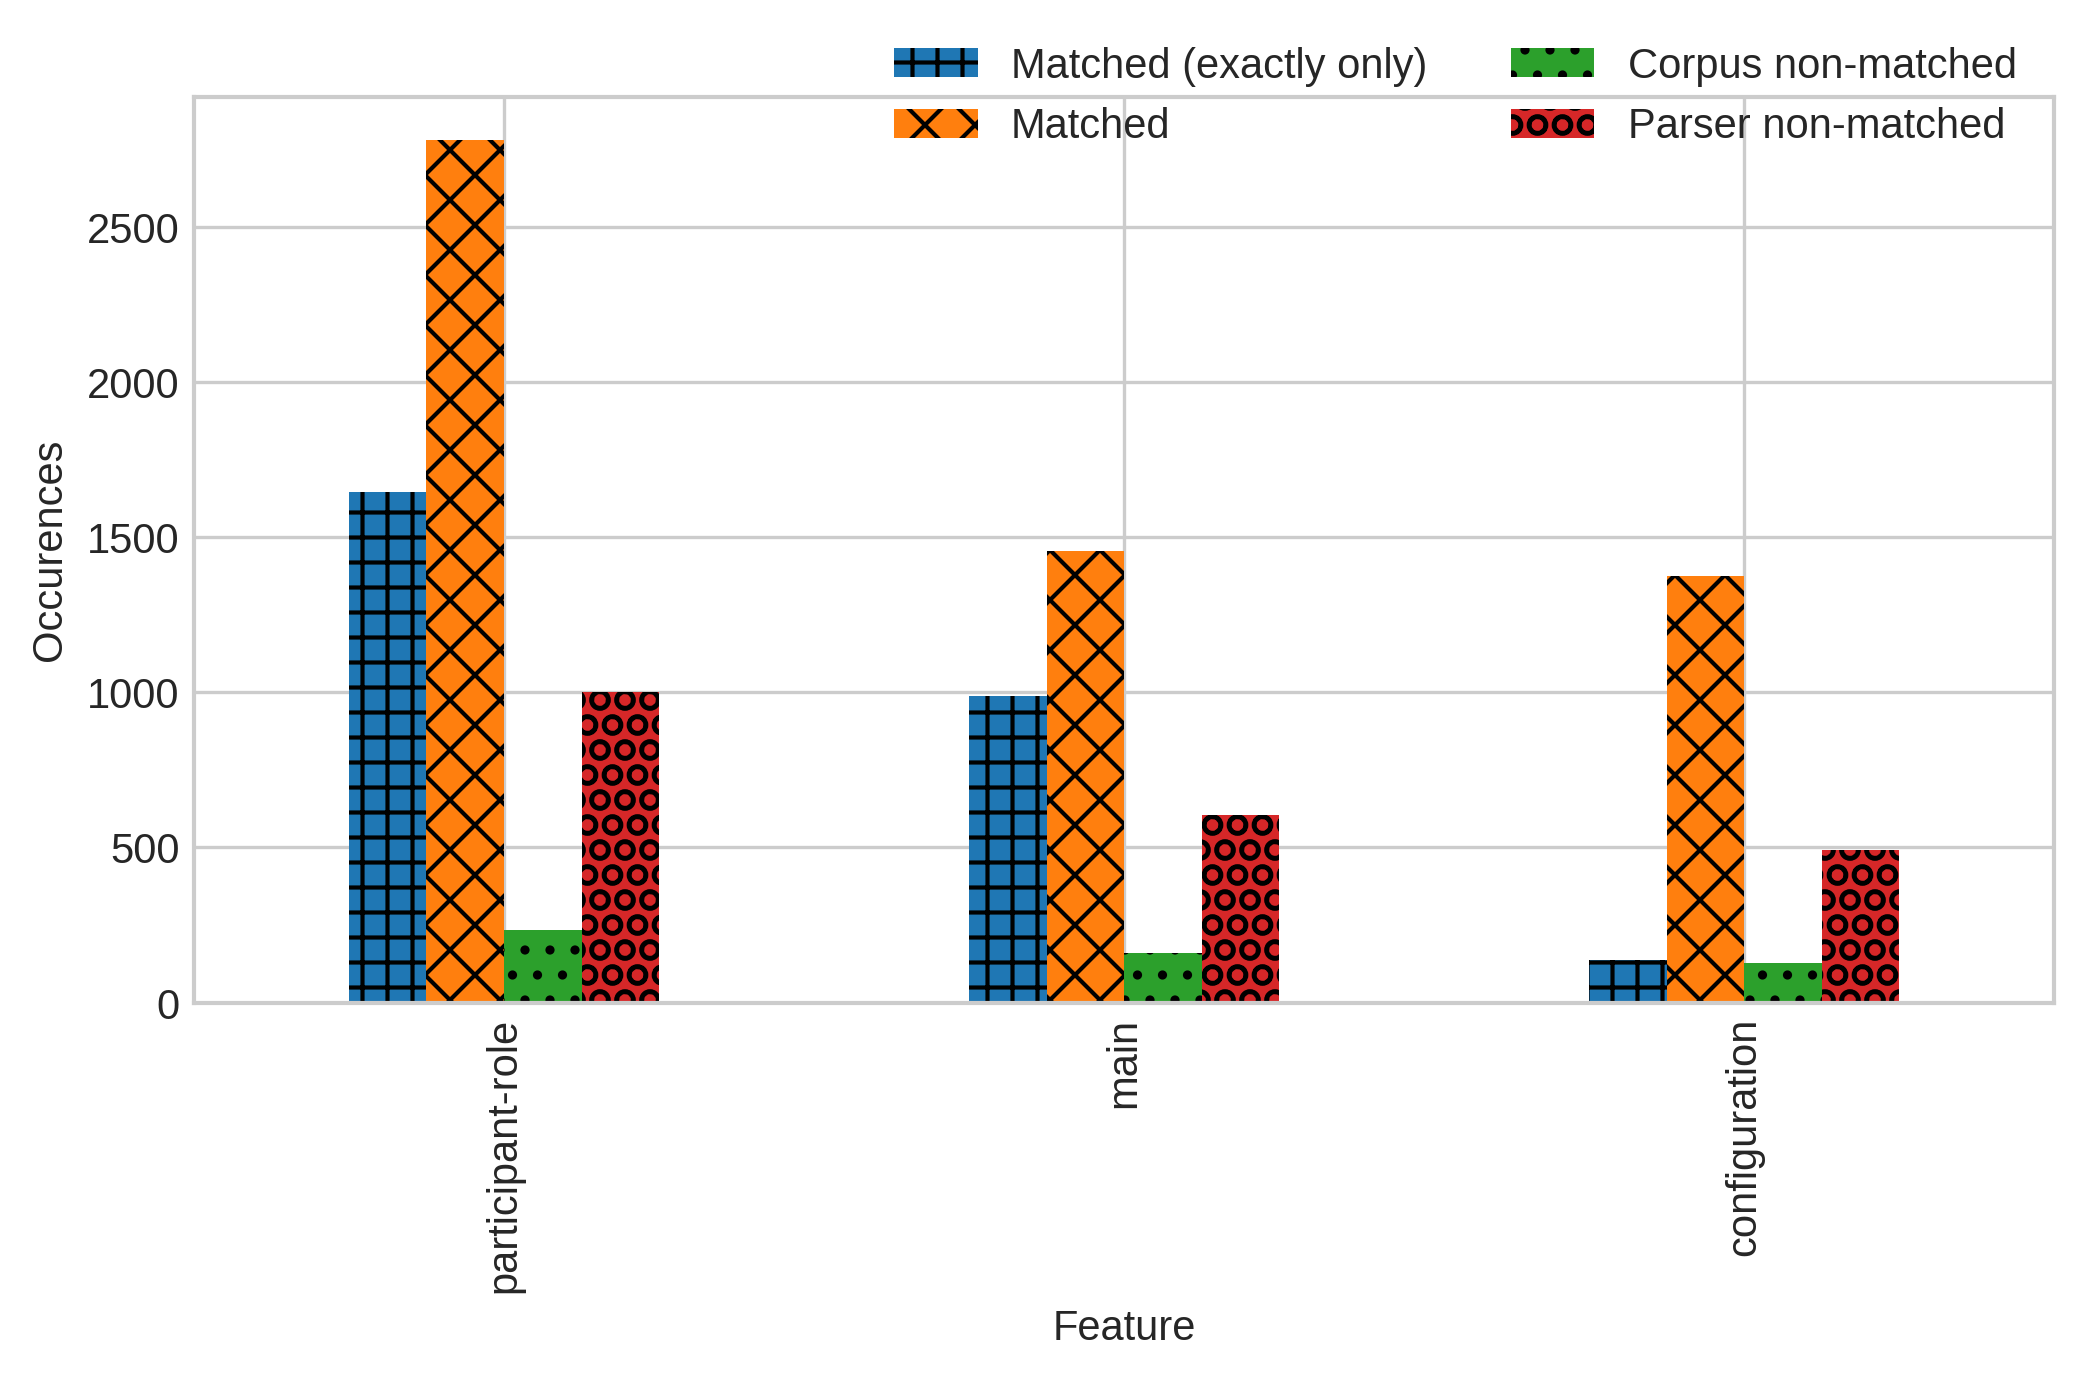

<Figure size 2400x1200 with 0 Axes>

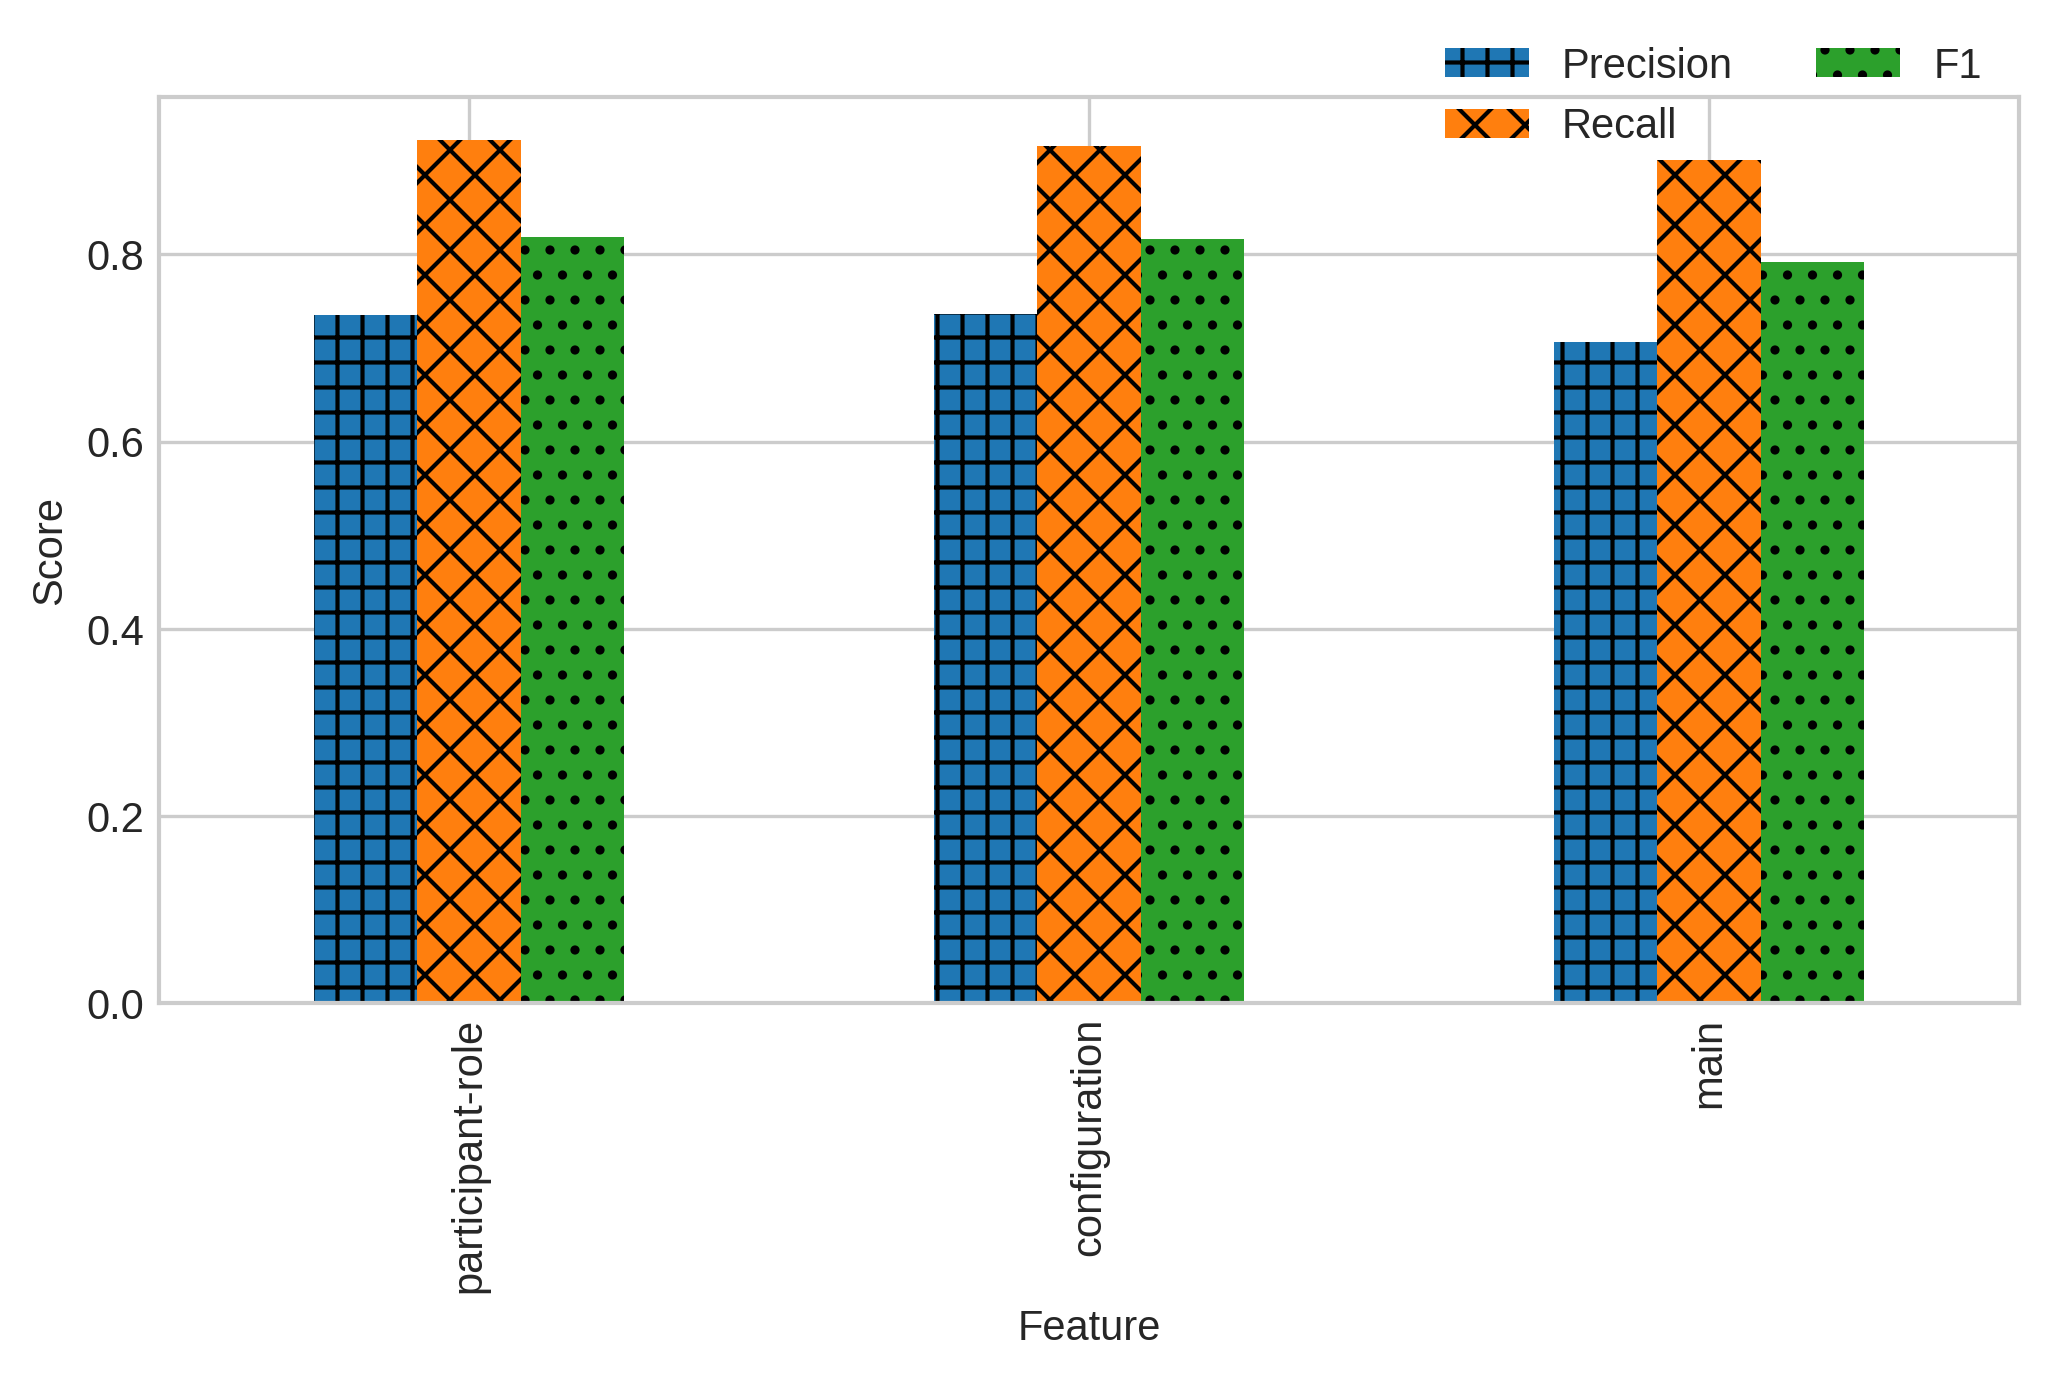

<Figure size 2400x1200 with 0 Axes>

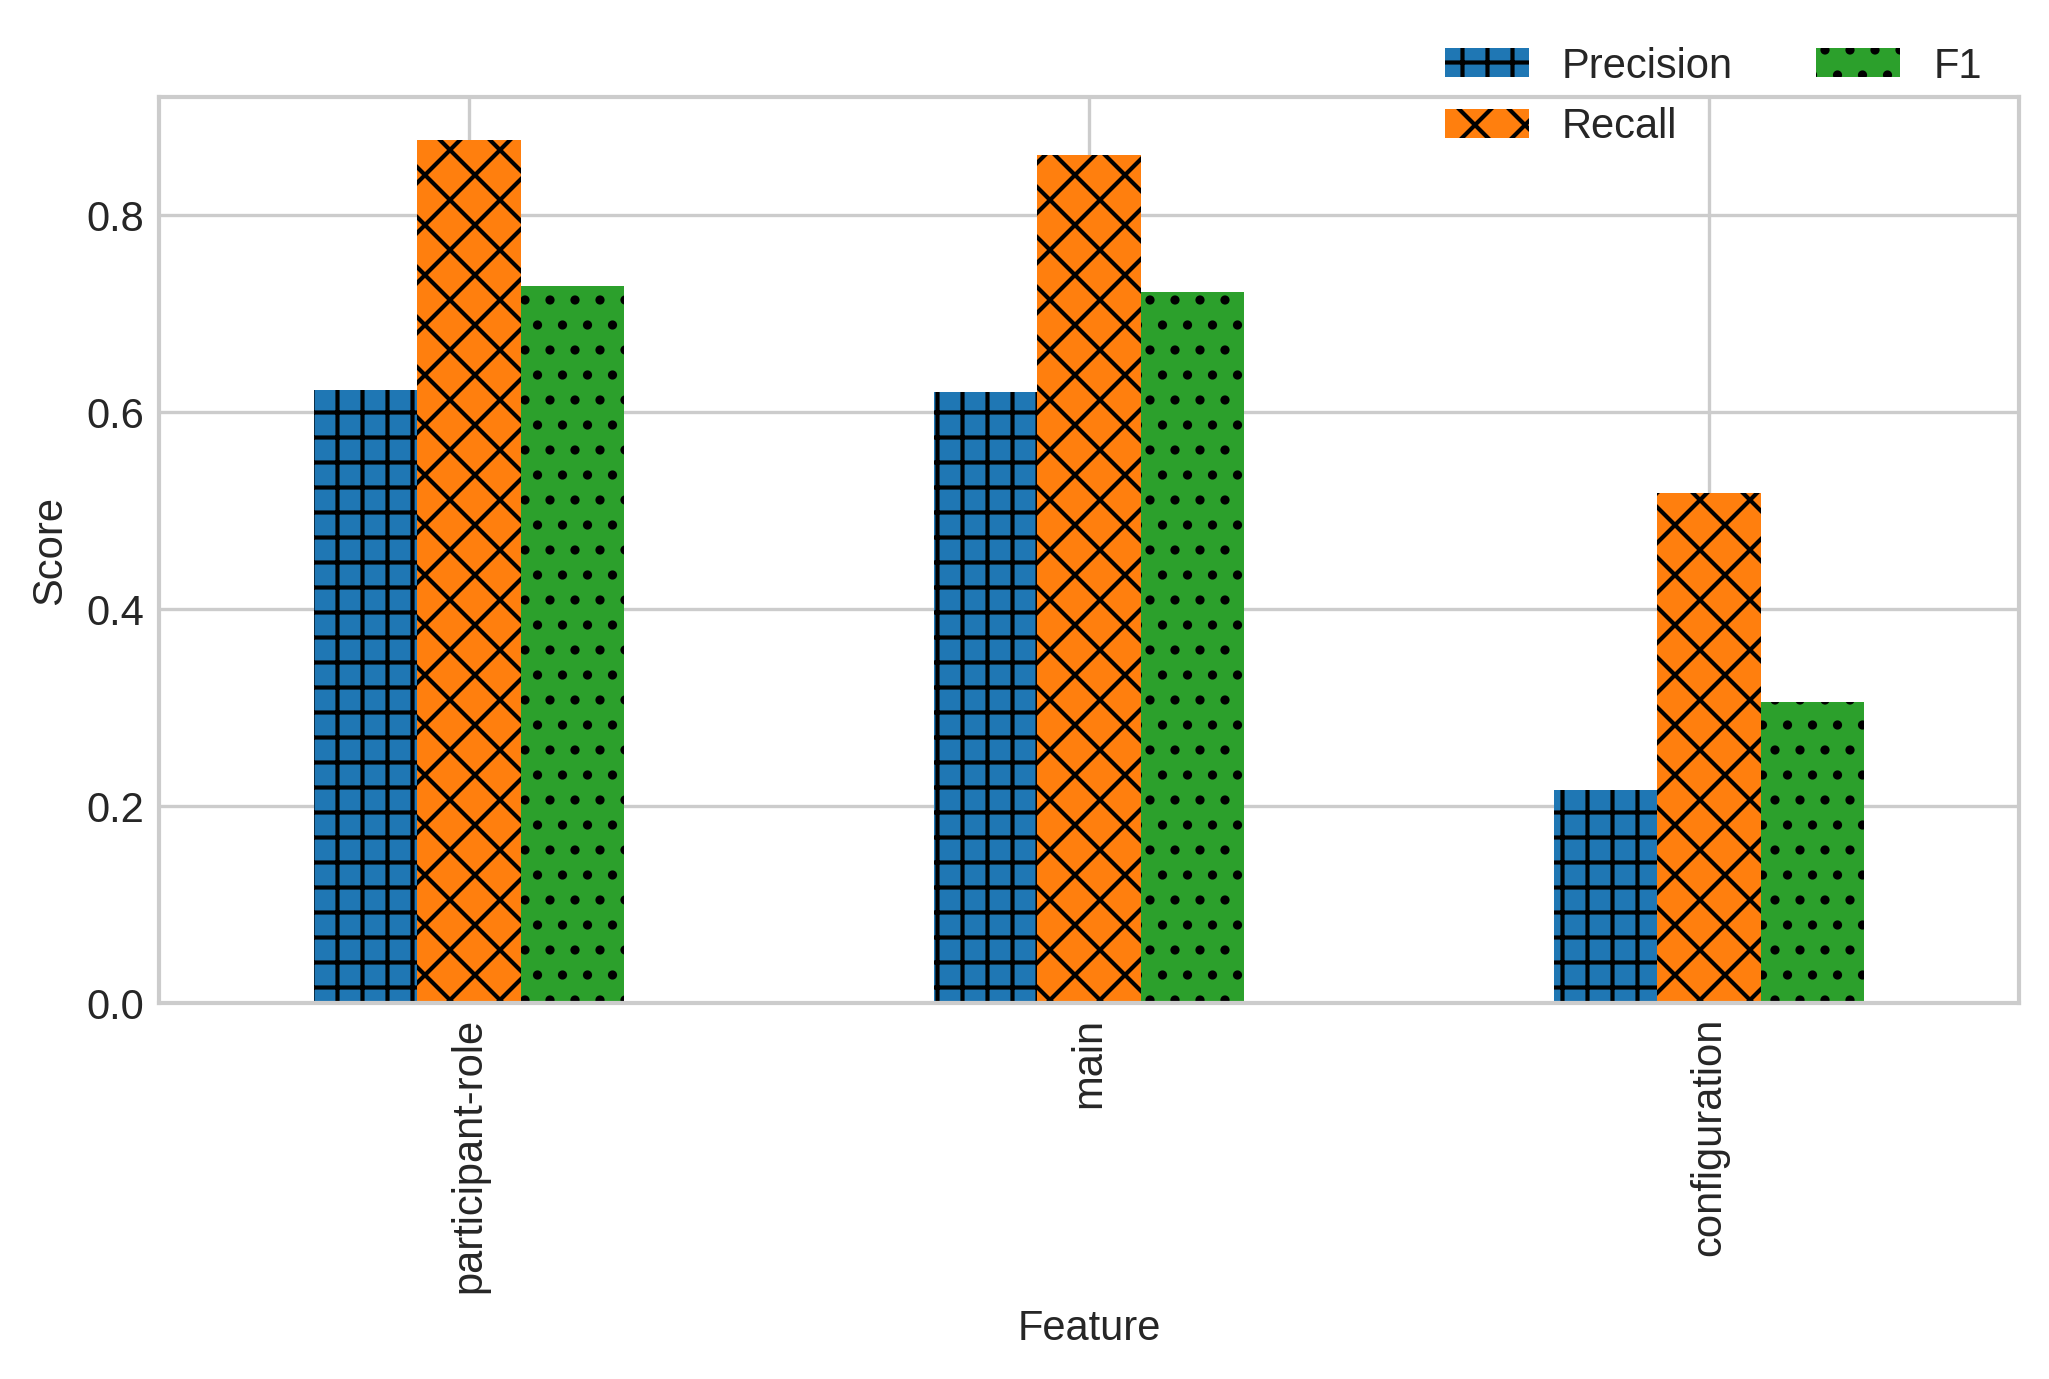

<Figure size 2400x1200 with 0 Axes>

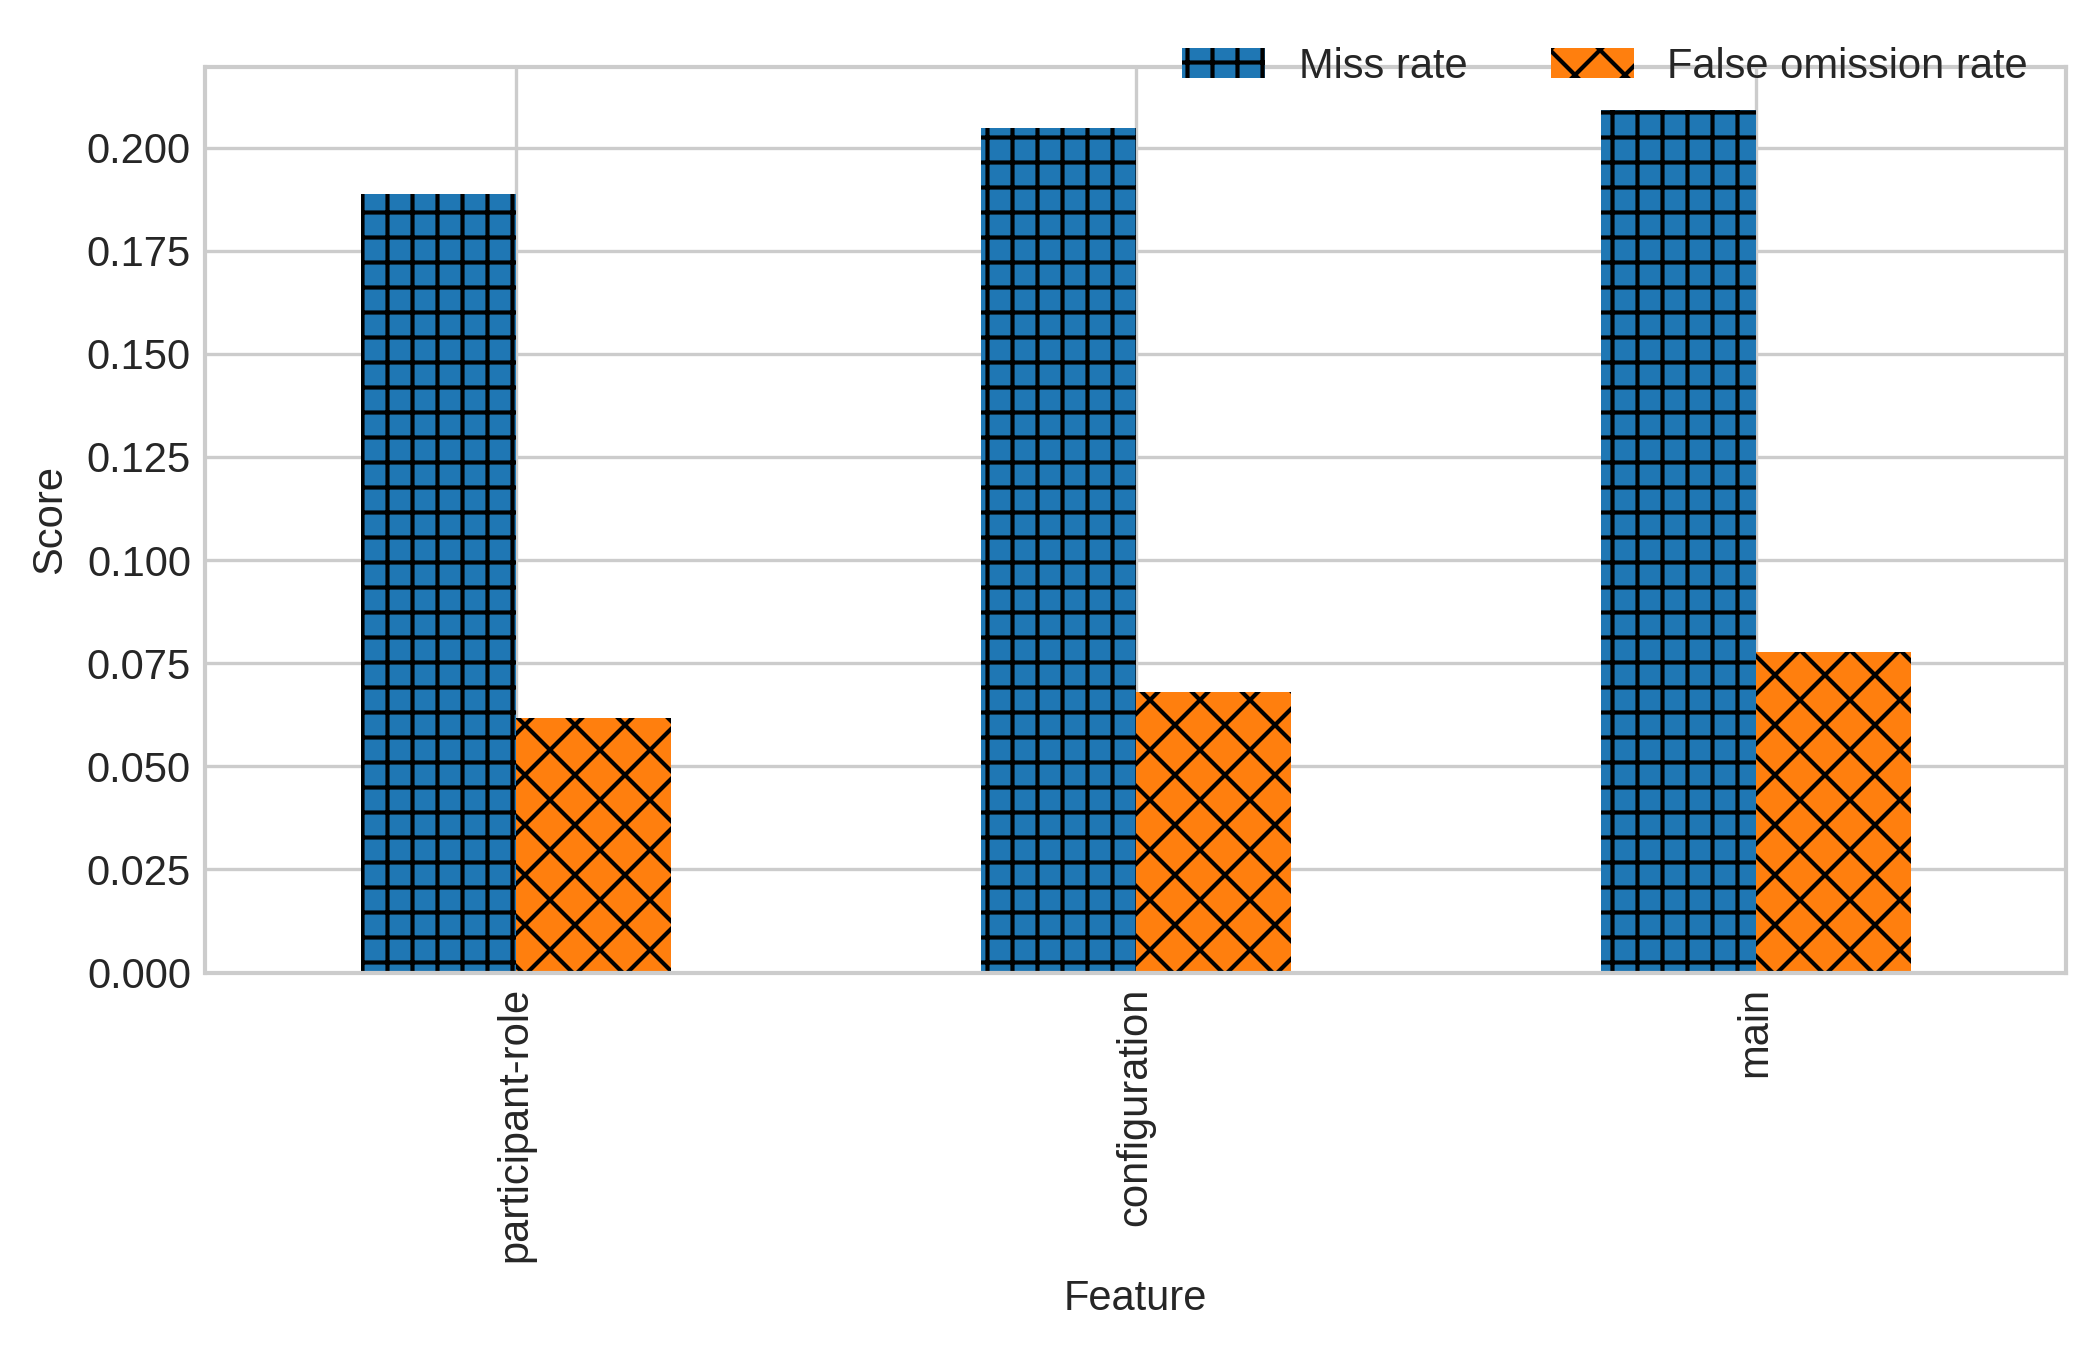

<Figure size 2400x1200 with 0 Axes>

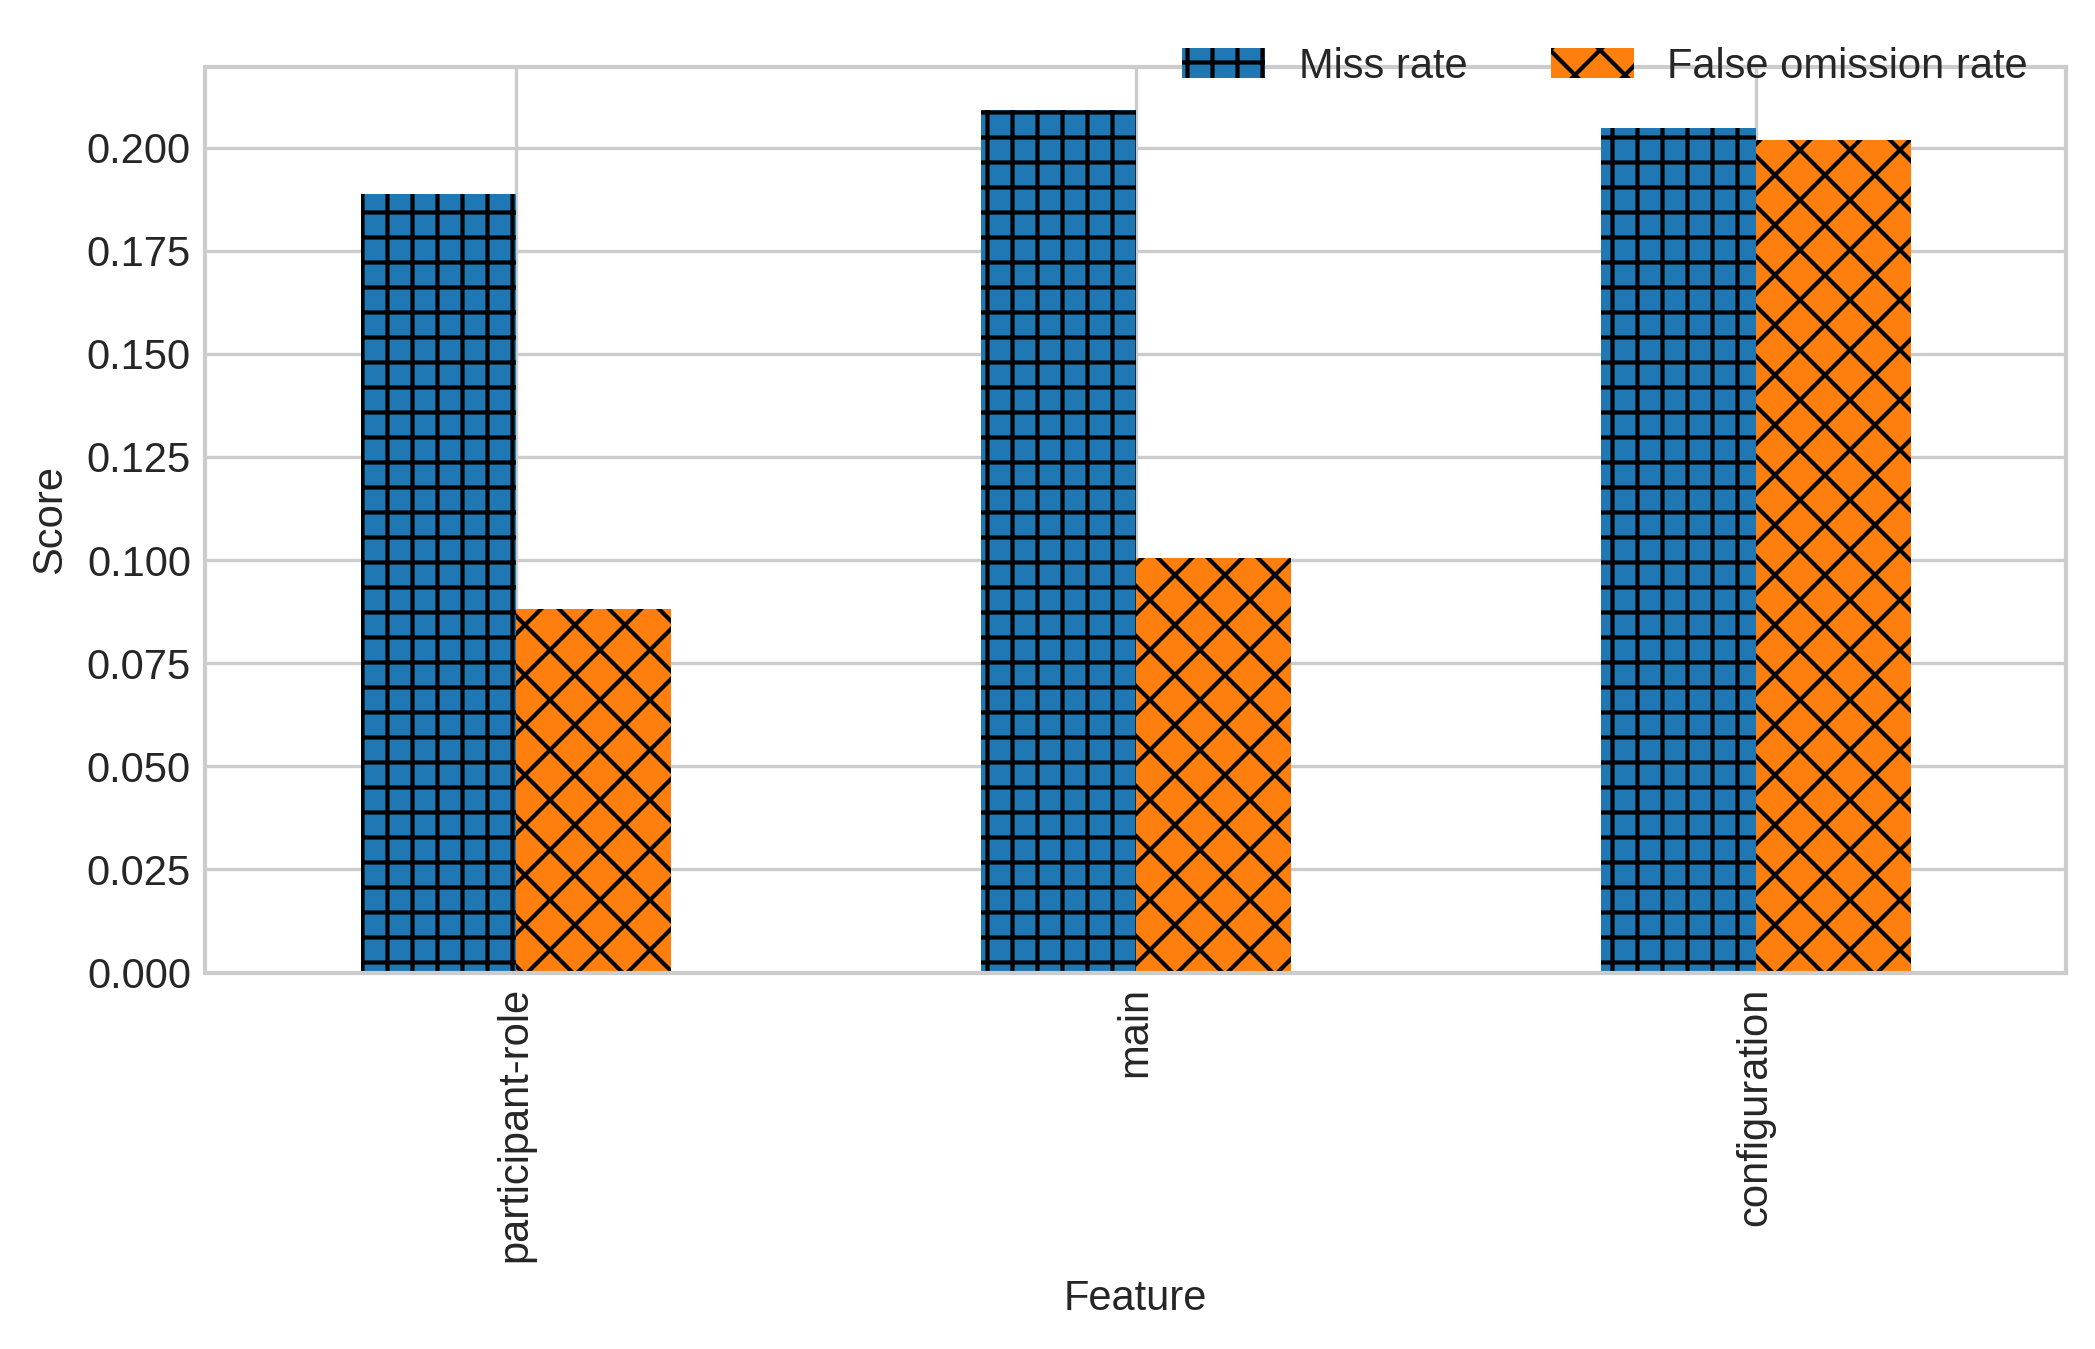

<Figure size 2400x1200 with 0 Axes>

In [54]:
filters= ["configuration","main","participant-role"]
make_stats2(aggregate, "unit-elements-transitivity", filters=filters, make_exact_also=True)

# Mood system feature evaluation - [OCD1] corpus

In [33]:
################################################
POLARITY = ["positive","negative"]
VOICE = ["active","passive"]
FINITENESS = ["finite","non-finite"]
PERFECTIVITY = ["perfective","imperfective"]
MOOD = ["imperative","indicative"]
INDICATIVE = ["declarative","interrogative"]
INTERROGATIVE = ["wh","yes-no"]
WH=["wh-subject","wh-complement","wh-adjunct"]
DEICTICITY = ["temporal","modal"]
MODAL_DEICTICITY = ["root","epistemic"]
# ROOT_MODAL_DEICTICITY = ["inclination-volition","obligation-permission","ability"] # out
# EPISTEMIC_MODAL_DEICTICITY = ["probability","usuality"] # out
TEMPORAL_DEICTICITY_TIME = ["past","present","future"]
TEMPORAL_DEICTICITY_PROGRESSIVITY = ["progressive","non-progressive"]
TEMPORAL_DEICTICITY_PERFECTIVITY = ["perfect","non-perfect"]
MOOD_ASSESMENT = ["intensity","modality","temporality"]

AGENCY = ["middle","effective"] 
# AGENCY_EFFECTIVE_VOICE = ["operative","receptive"] # out
# AGENCY_EFFECTIVE_VOICE_AGENTIVITY = ["agentive","non-agentive"] # out

ALL_SYSTEMIC_FEATURES = POLARITY + VOICE + FINITENESS \
+ PERFECTIVITY + MOOD + INDICATIVE + INTERROGATIVE + WH + DEICTICITY + MODAL_DEICTICITY \
+ TEMPORAL_DEICTICITY_TIME + TEMPORAL_DEICTICITY_PROGRESSIVITY + TEMPORAL_DEICTICITY_PERFECTIVITY \
+ MOOD_ASSESMENT + AGENCY

################################################

# all stats 
# ---------
matches, manual_nm, parse_nm = read_batch( OCD_mood_file_list )
# ---------
aggregate = aggregate_data_by_feature(matches, manual_nm, parse_nm)


## POLARITY

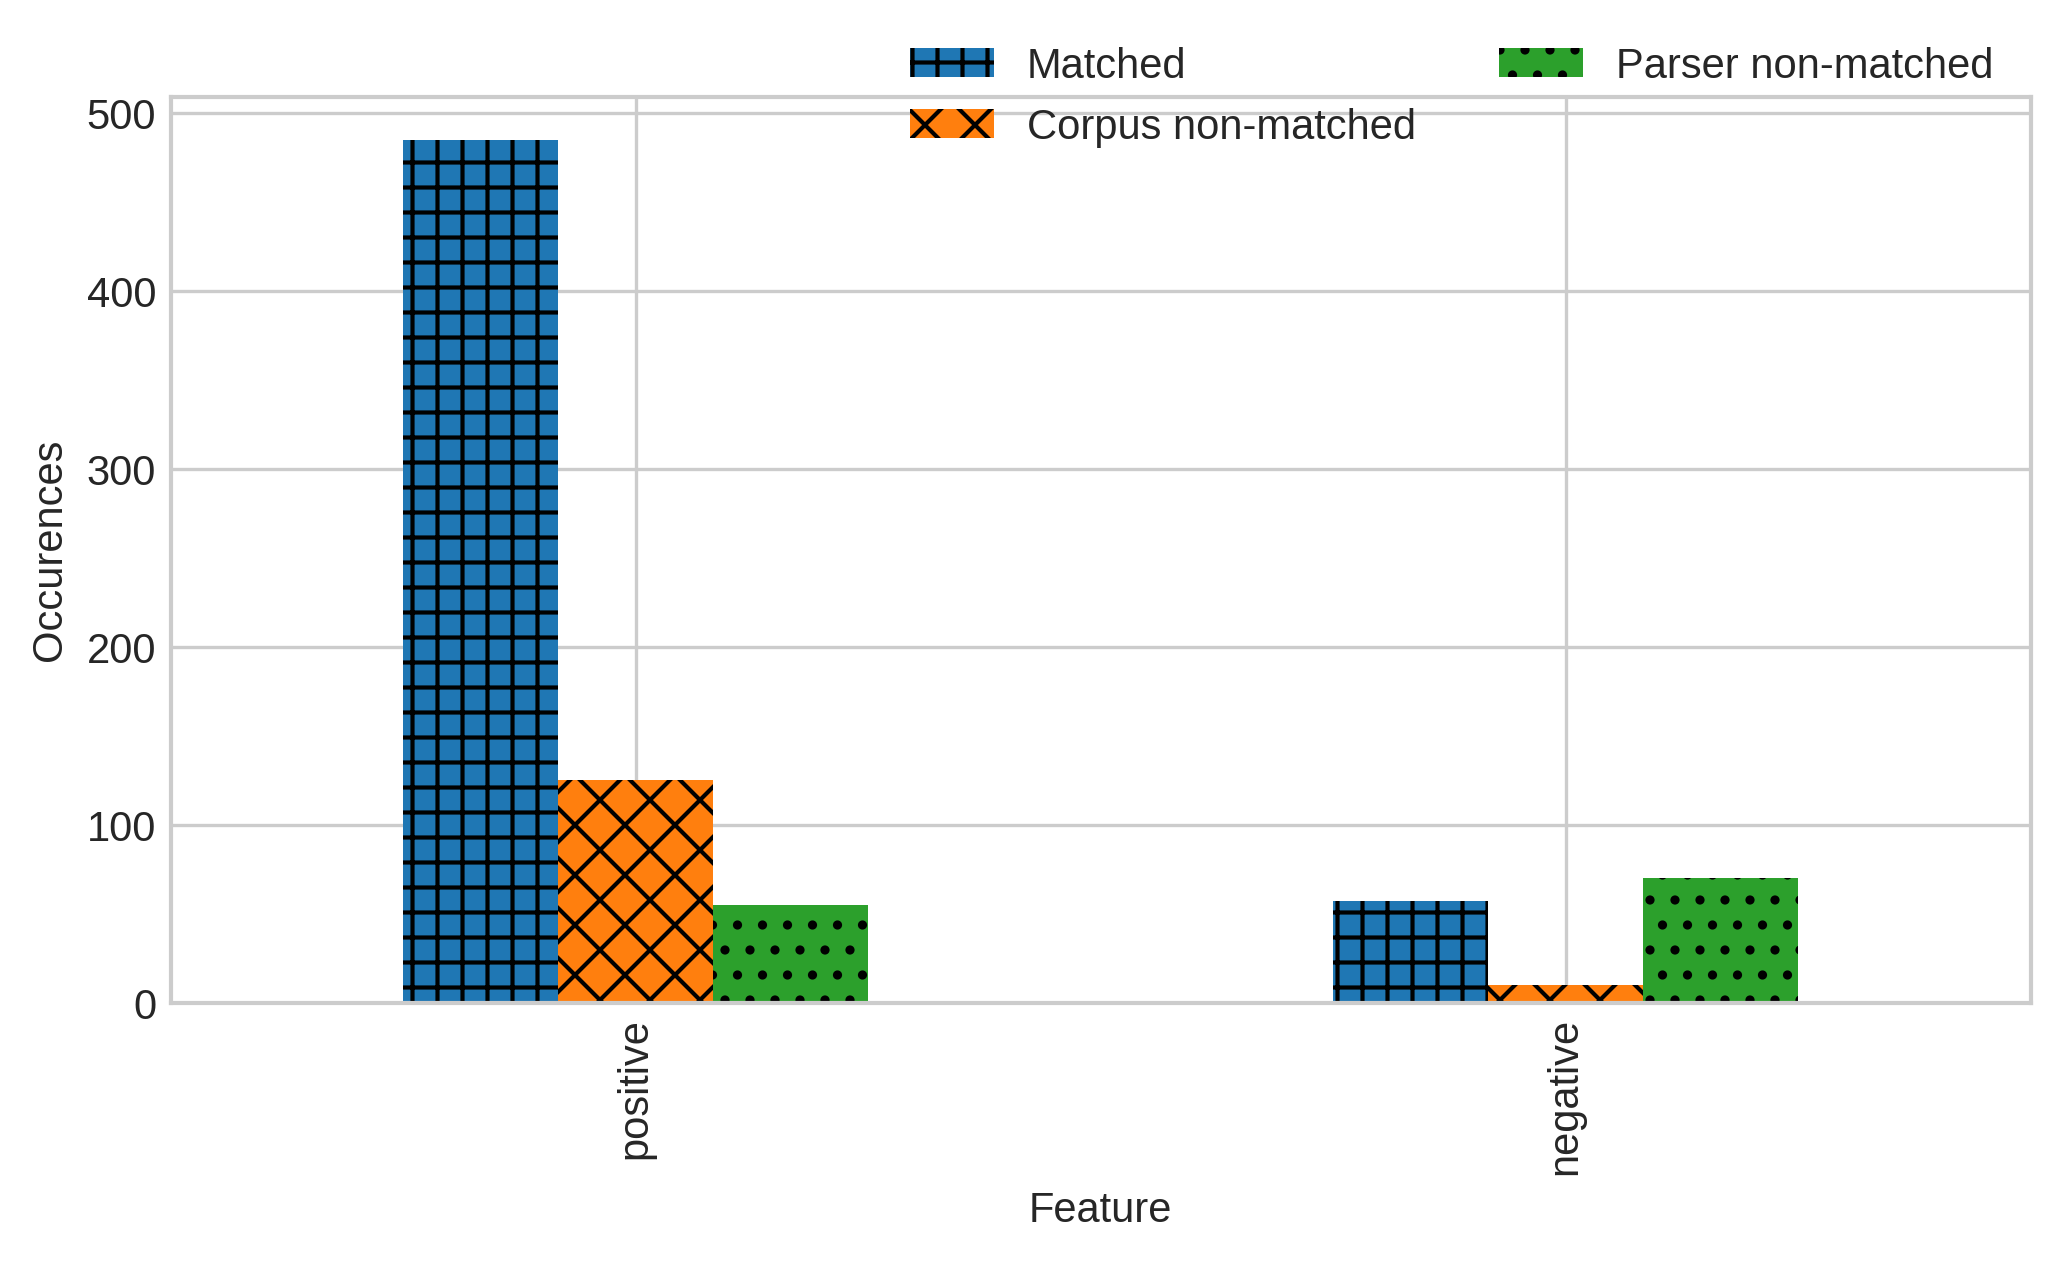

<Figure size 2400x1200 with 0 Axes>

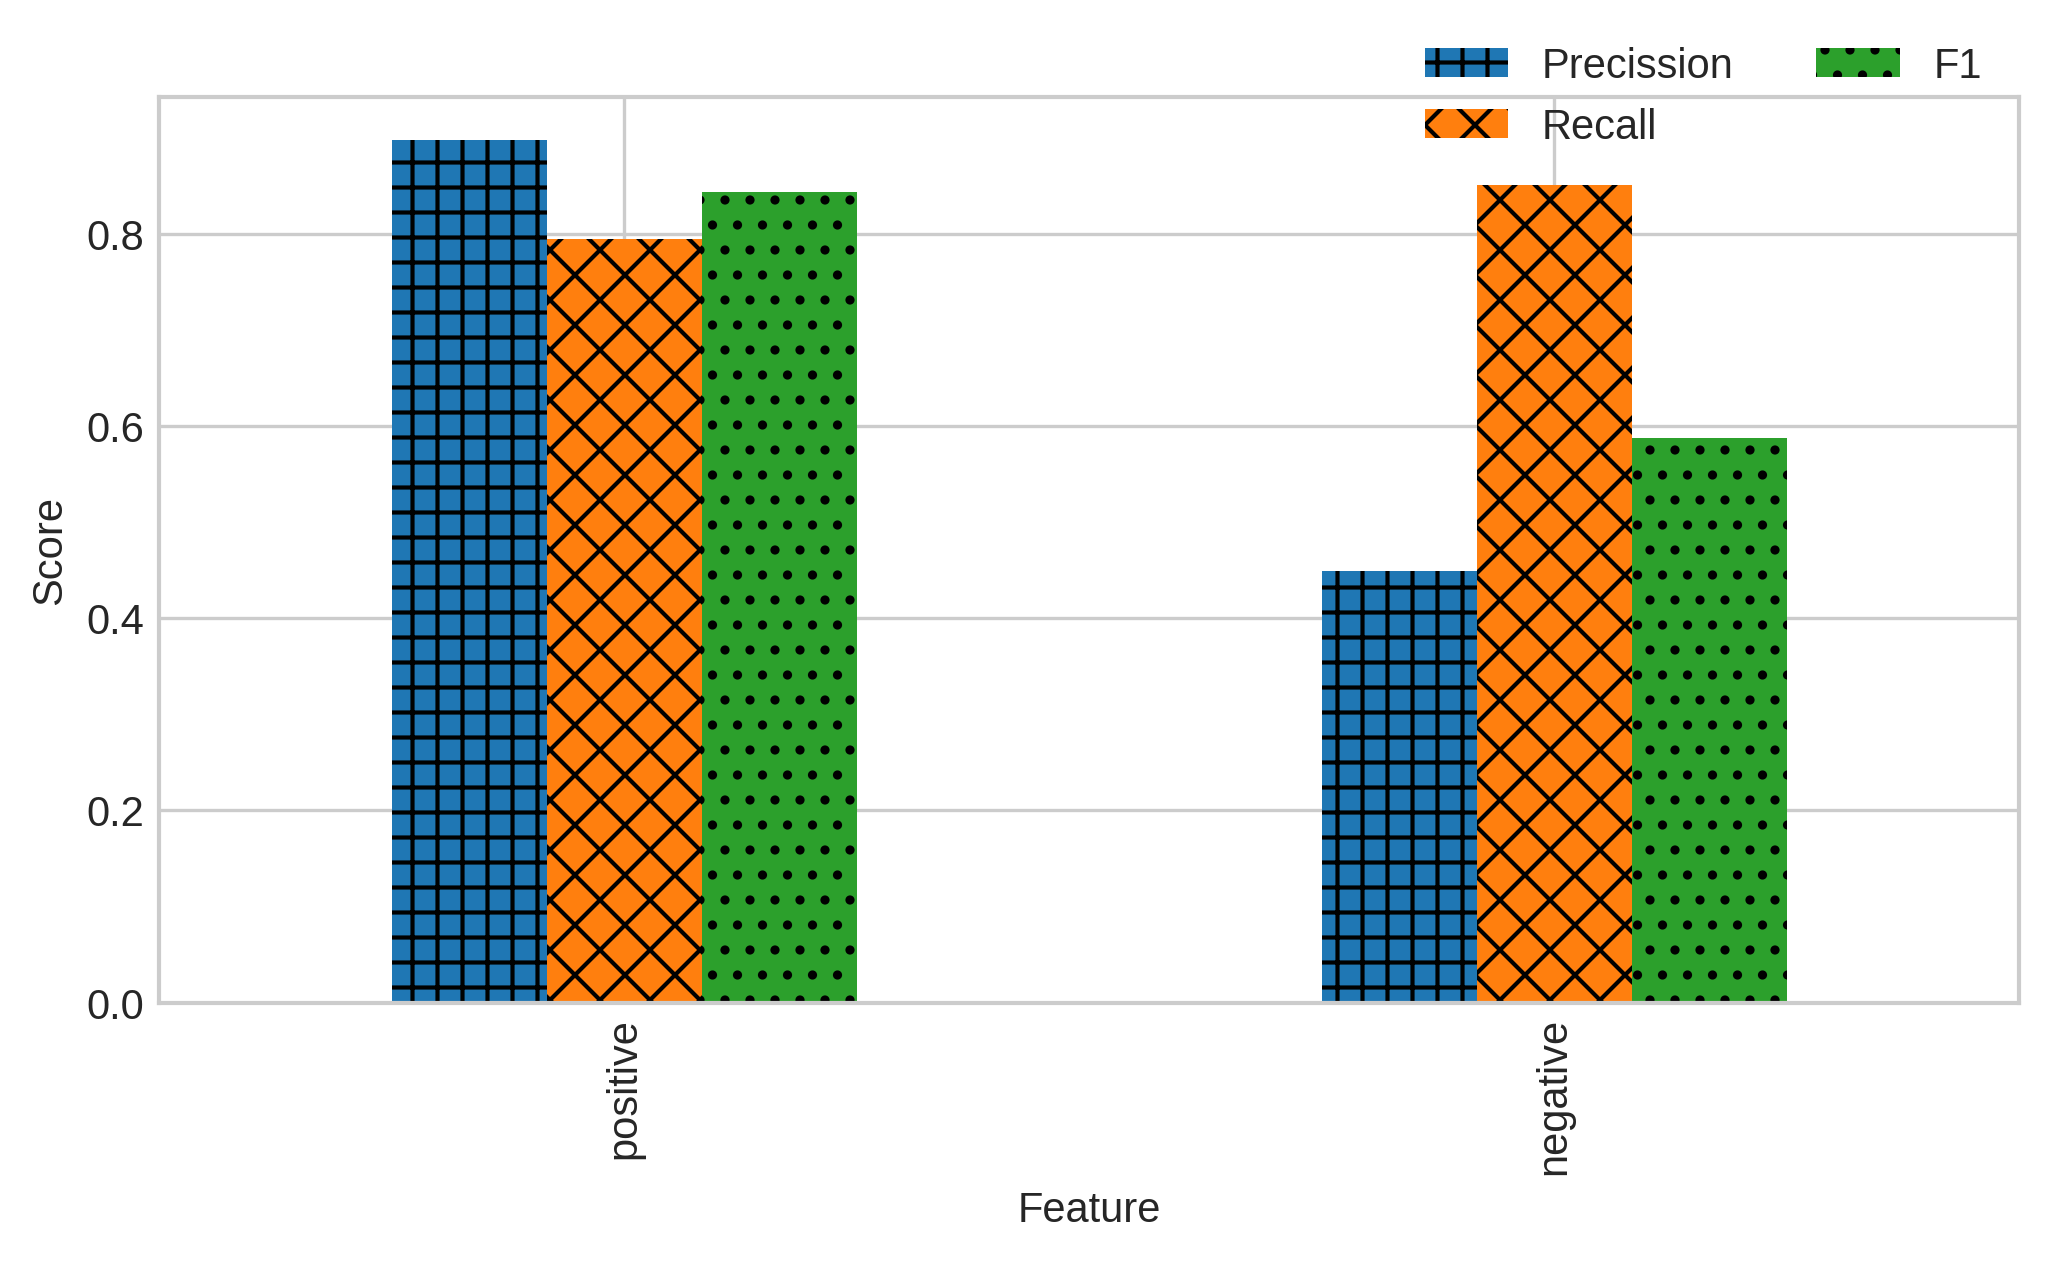

<Figure size 2400x1200 with 0 Axes>

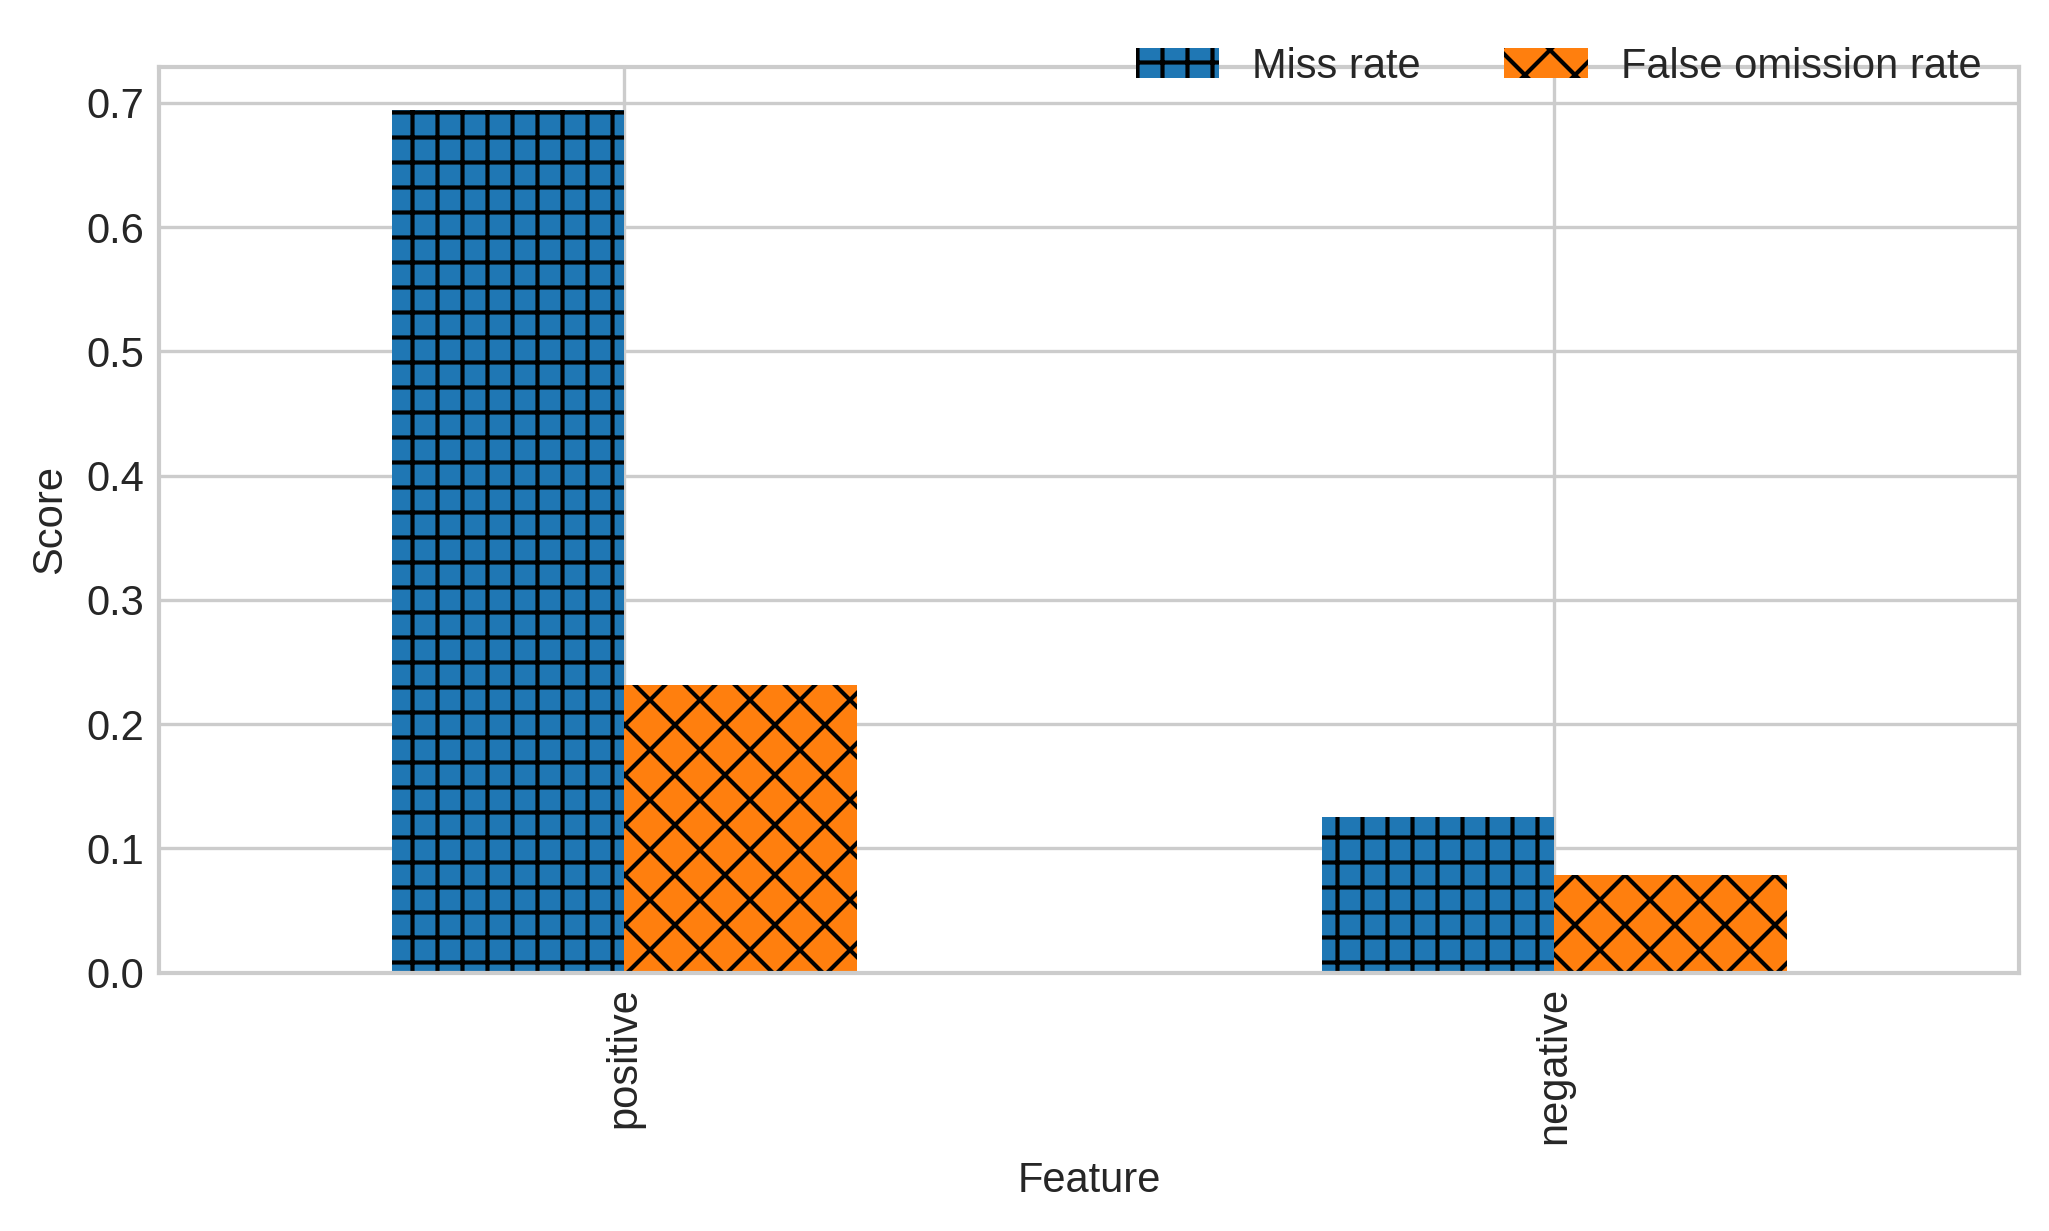

<Figure size 2400x1200 with 0 Axes>

In [34]:
make_stats2(aggregate, "POLARITY-ocd", filters=POLARITY)

## VOICE

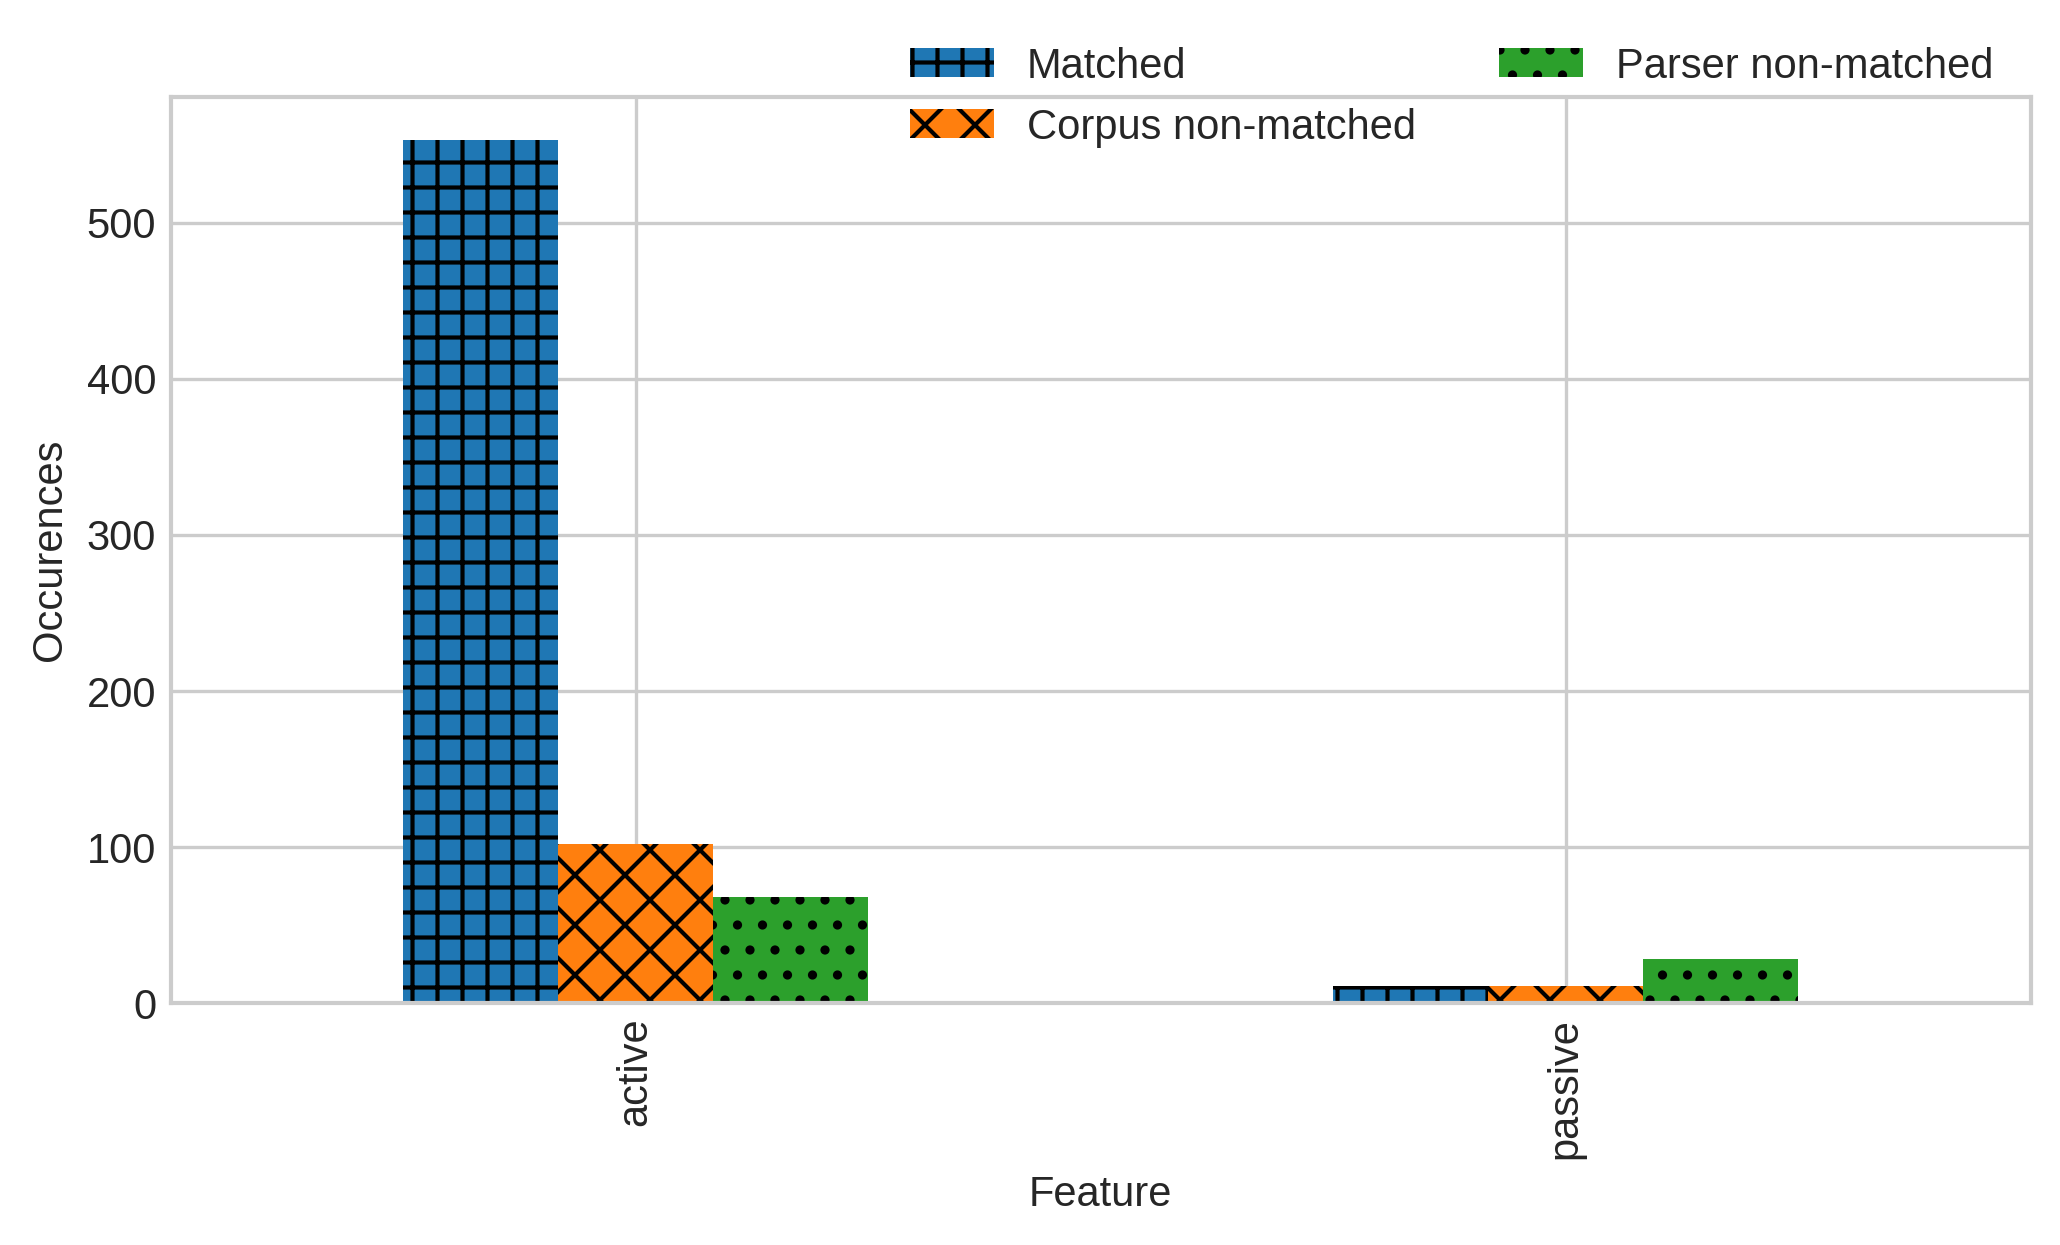

<Figure size 2400x1200 with 0 Axes>

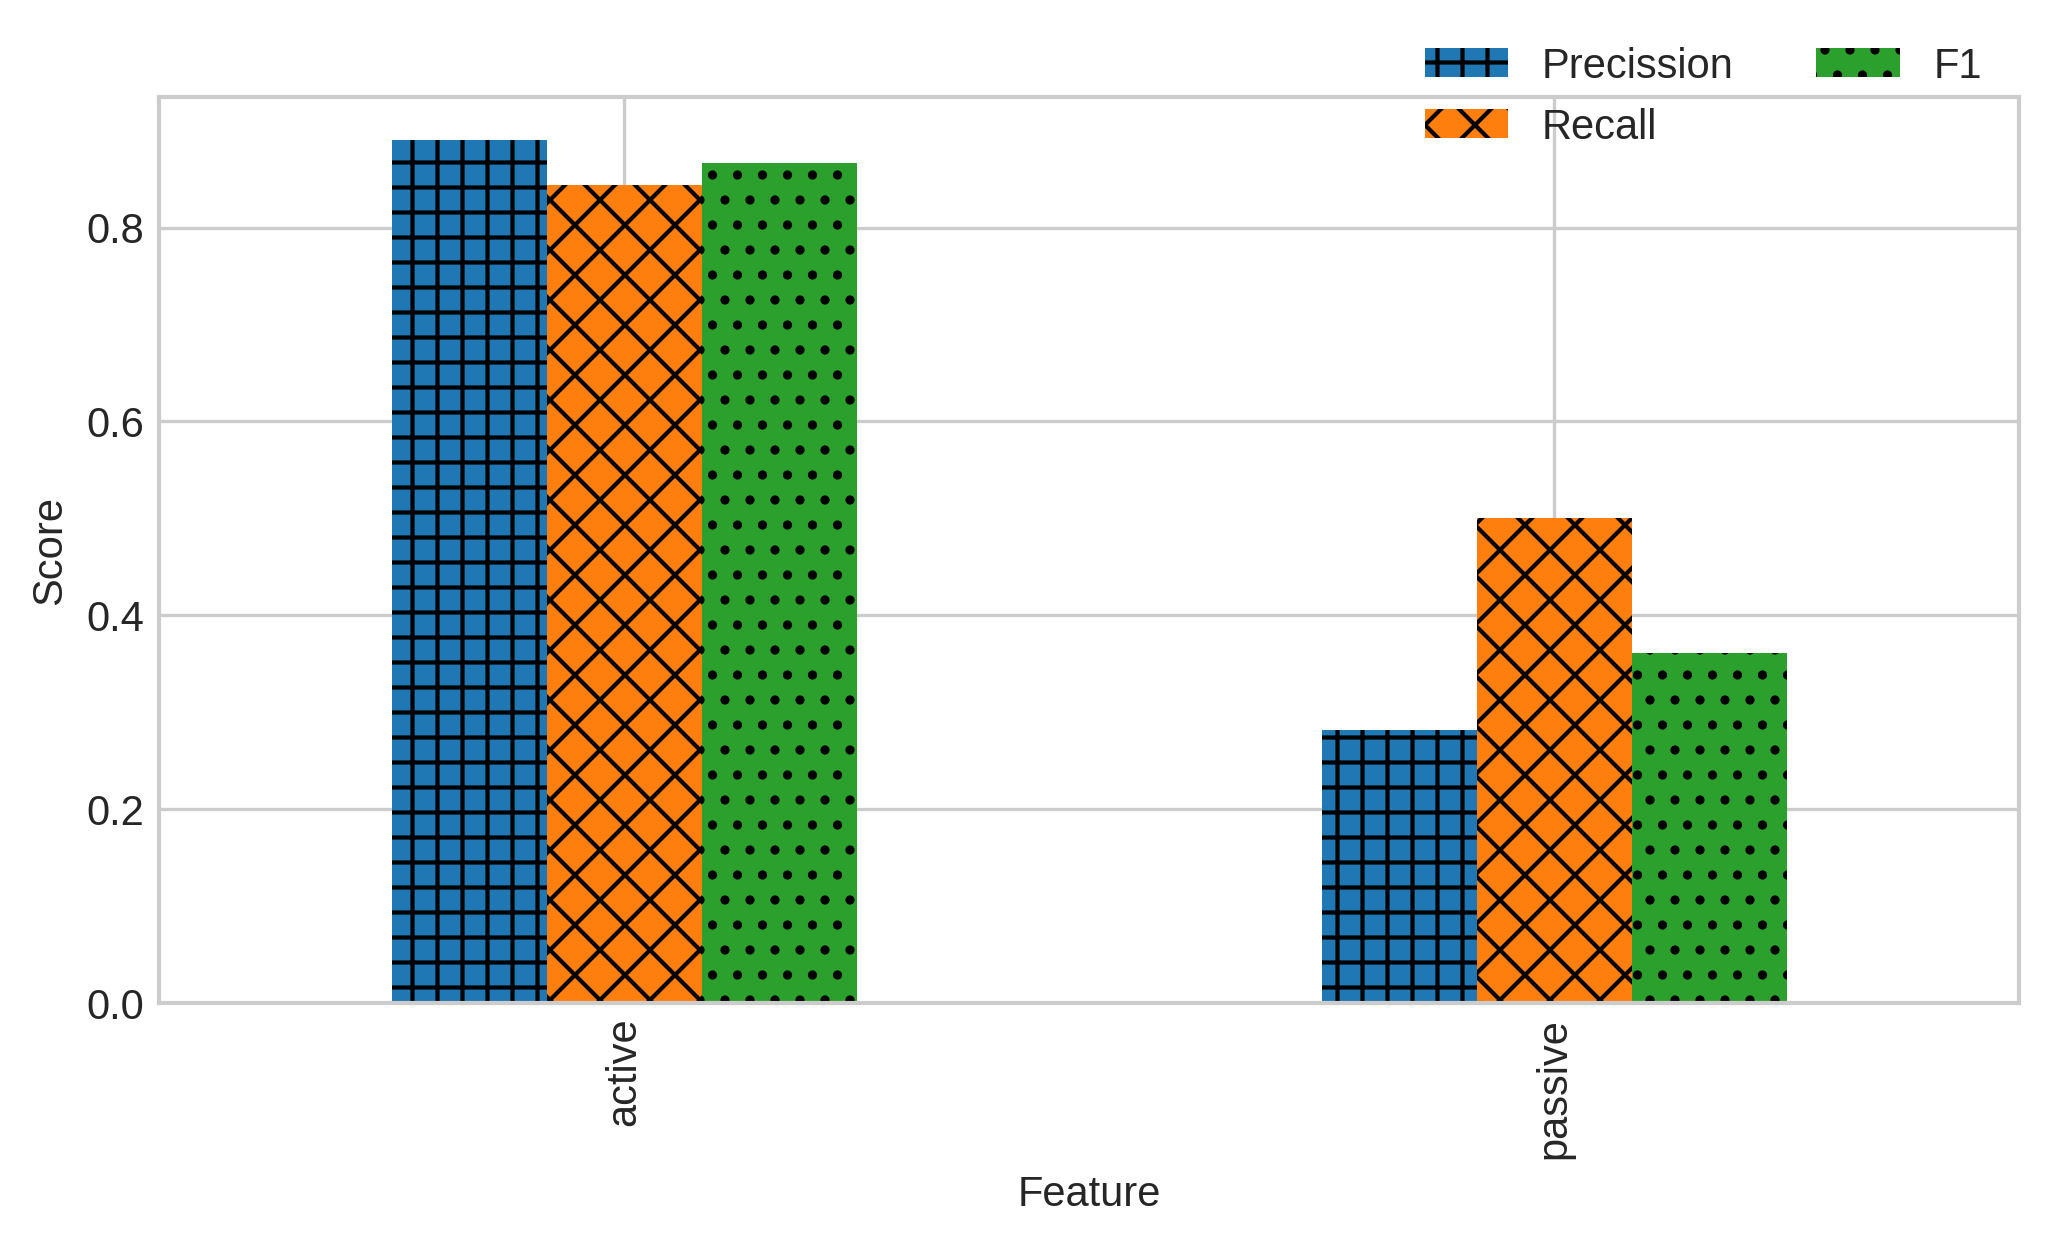

<Figure size 2400x1200 with 0 Axes>

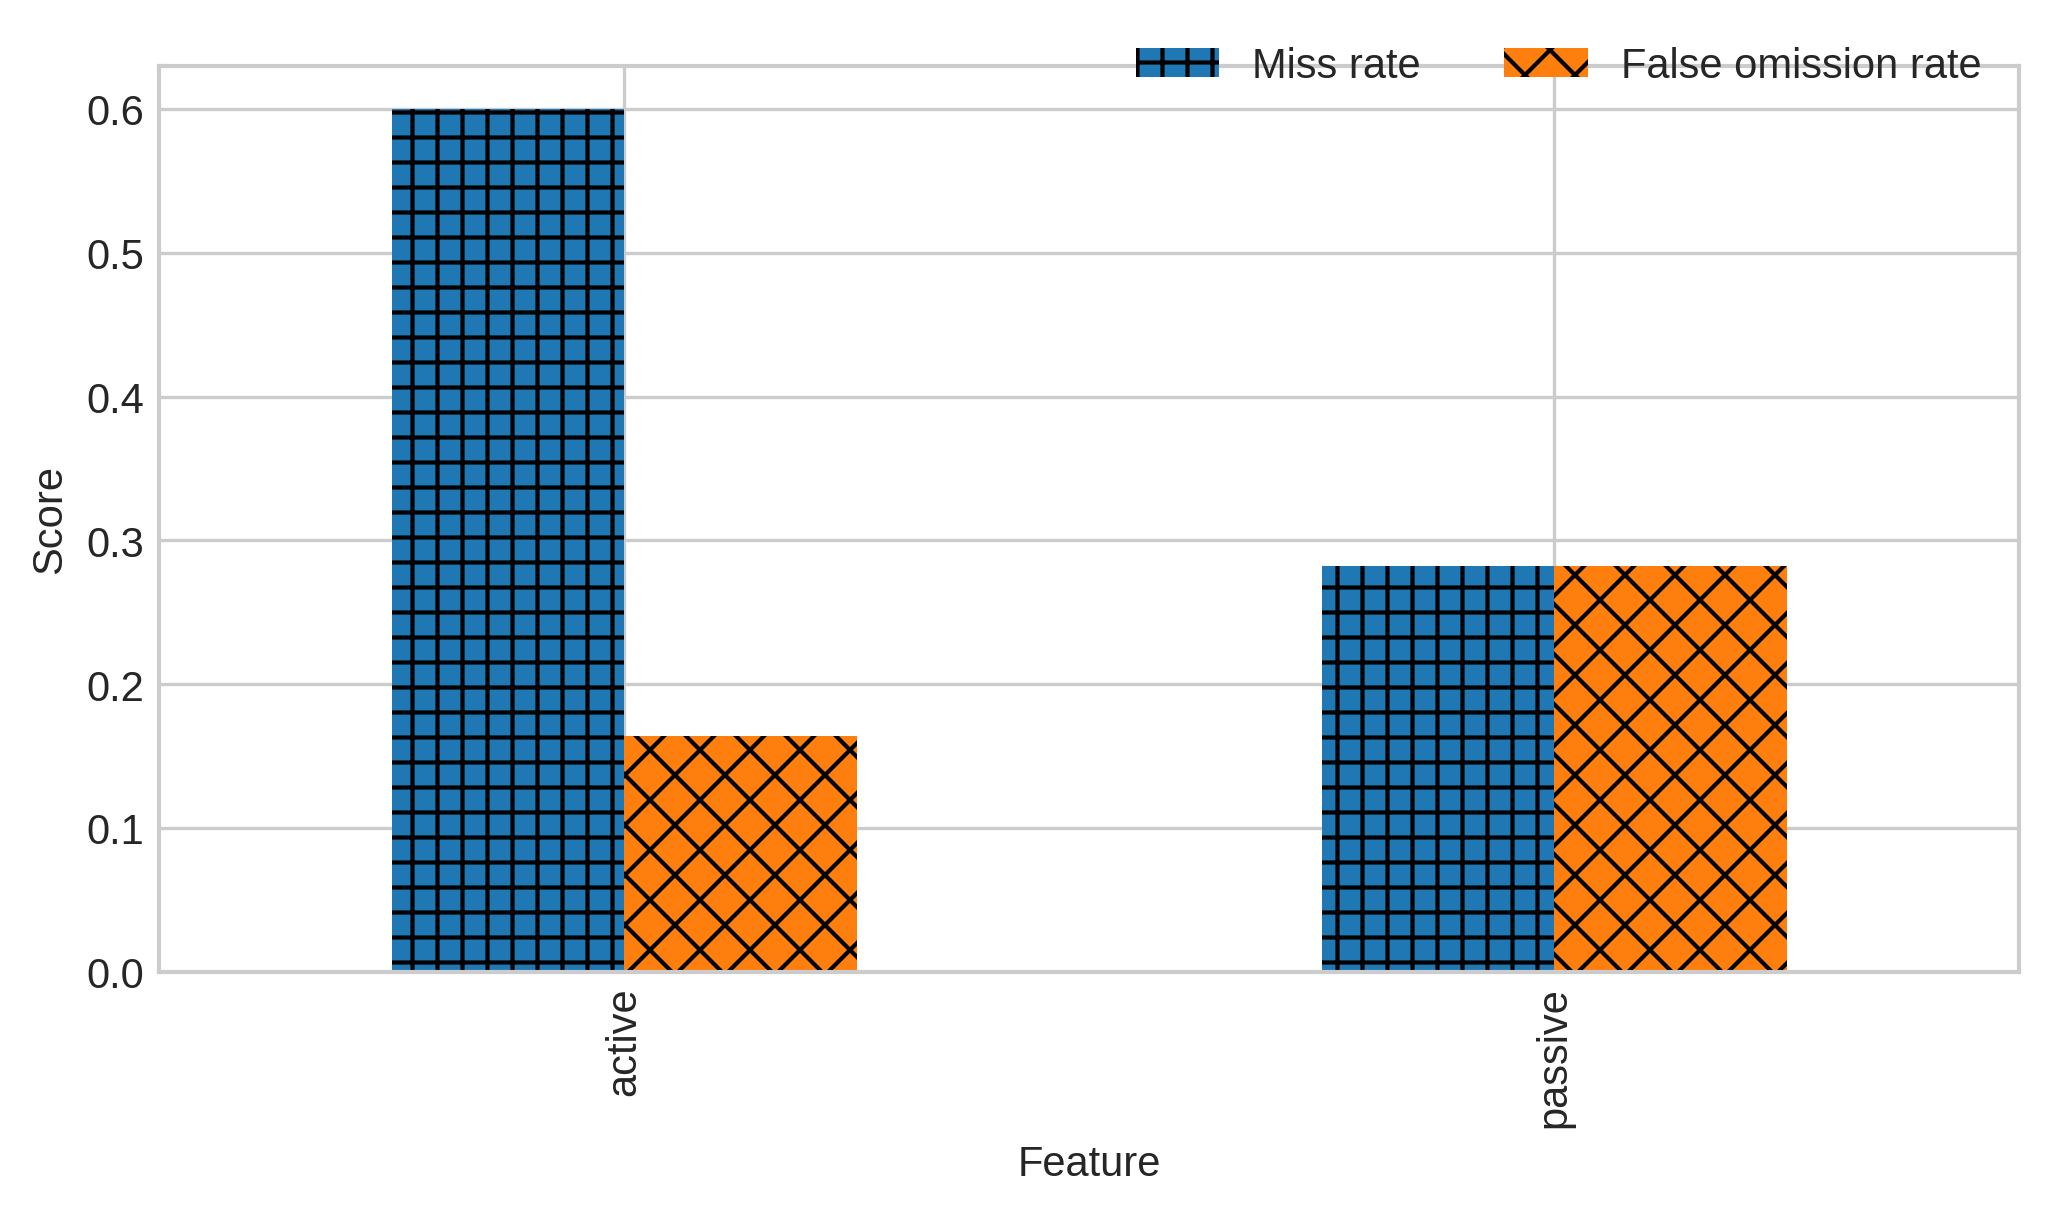

<Figure size 2400x1200 with 0 Axes>

In [35]:
make_stats2(aggregate, "VOICE-ocd", filters=VOICE)

## Systemic features

## FINITENESS

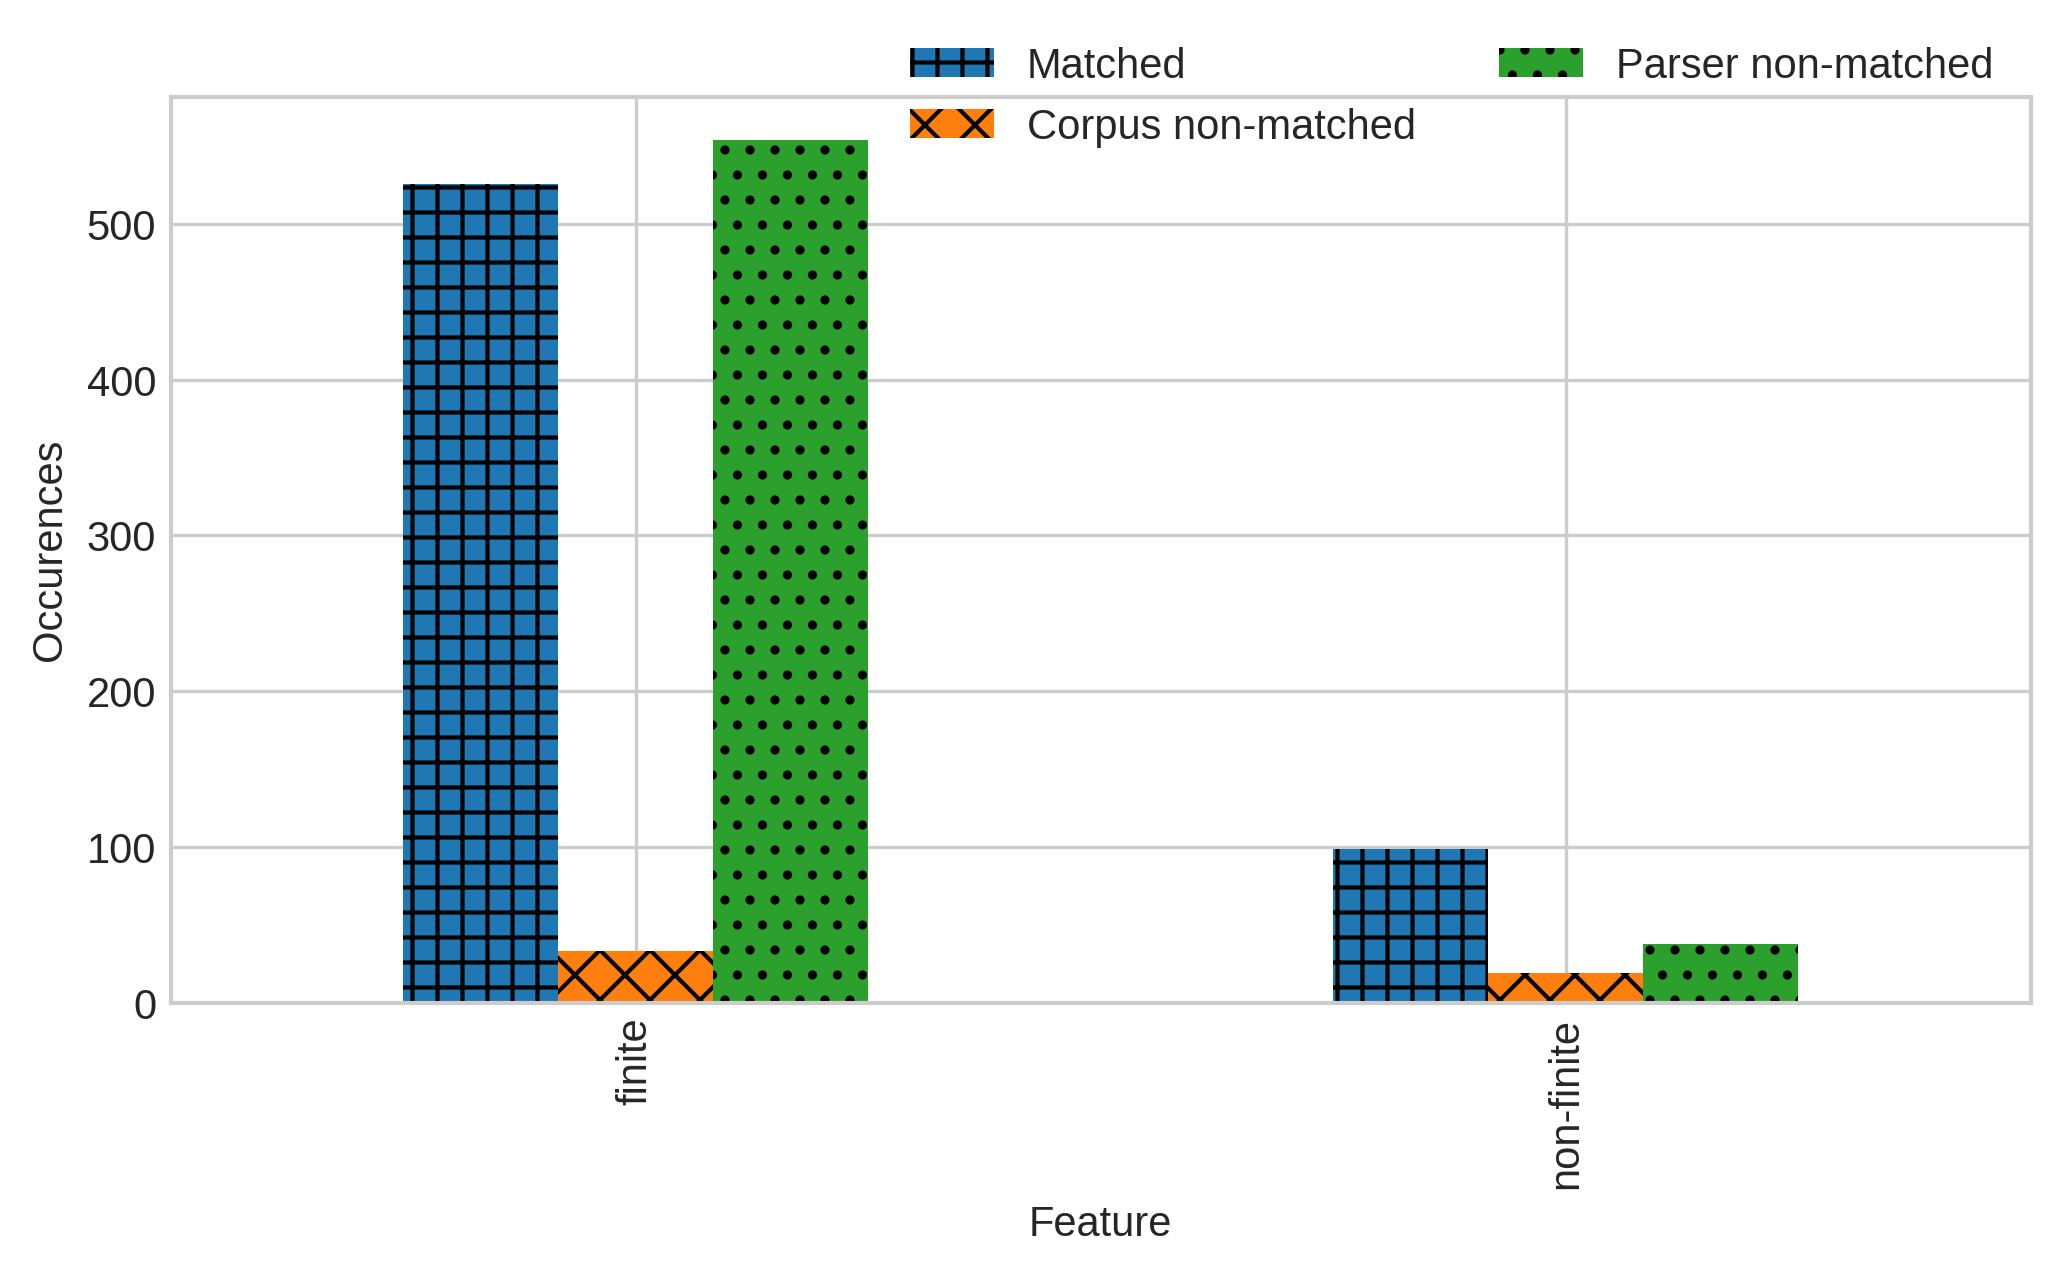

<Figure size 2400x1200 with 0 Axes>

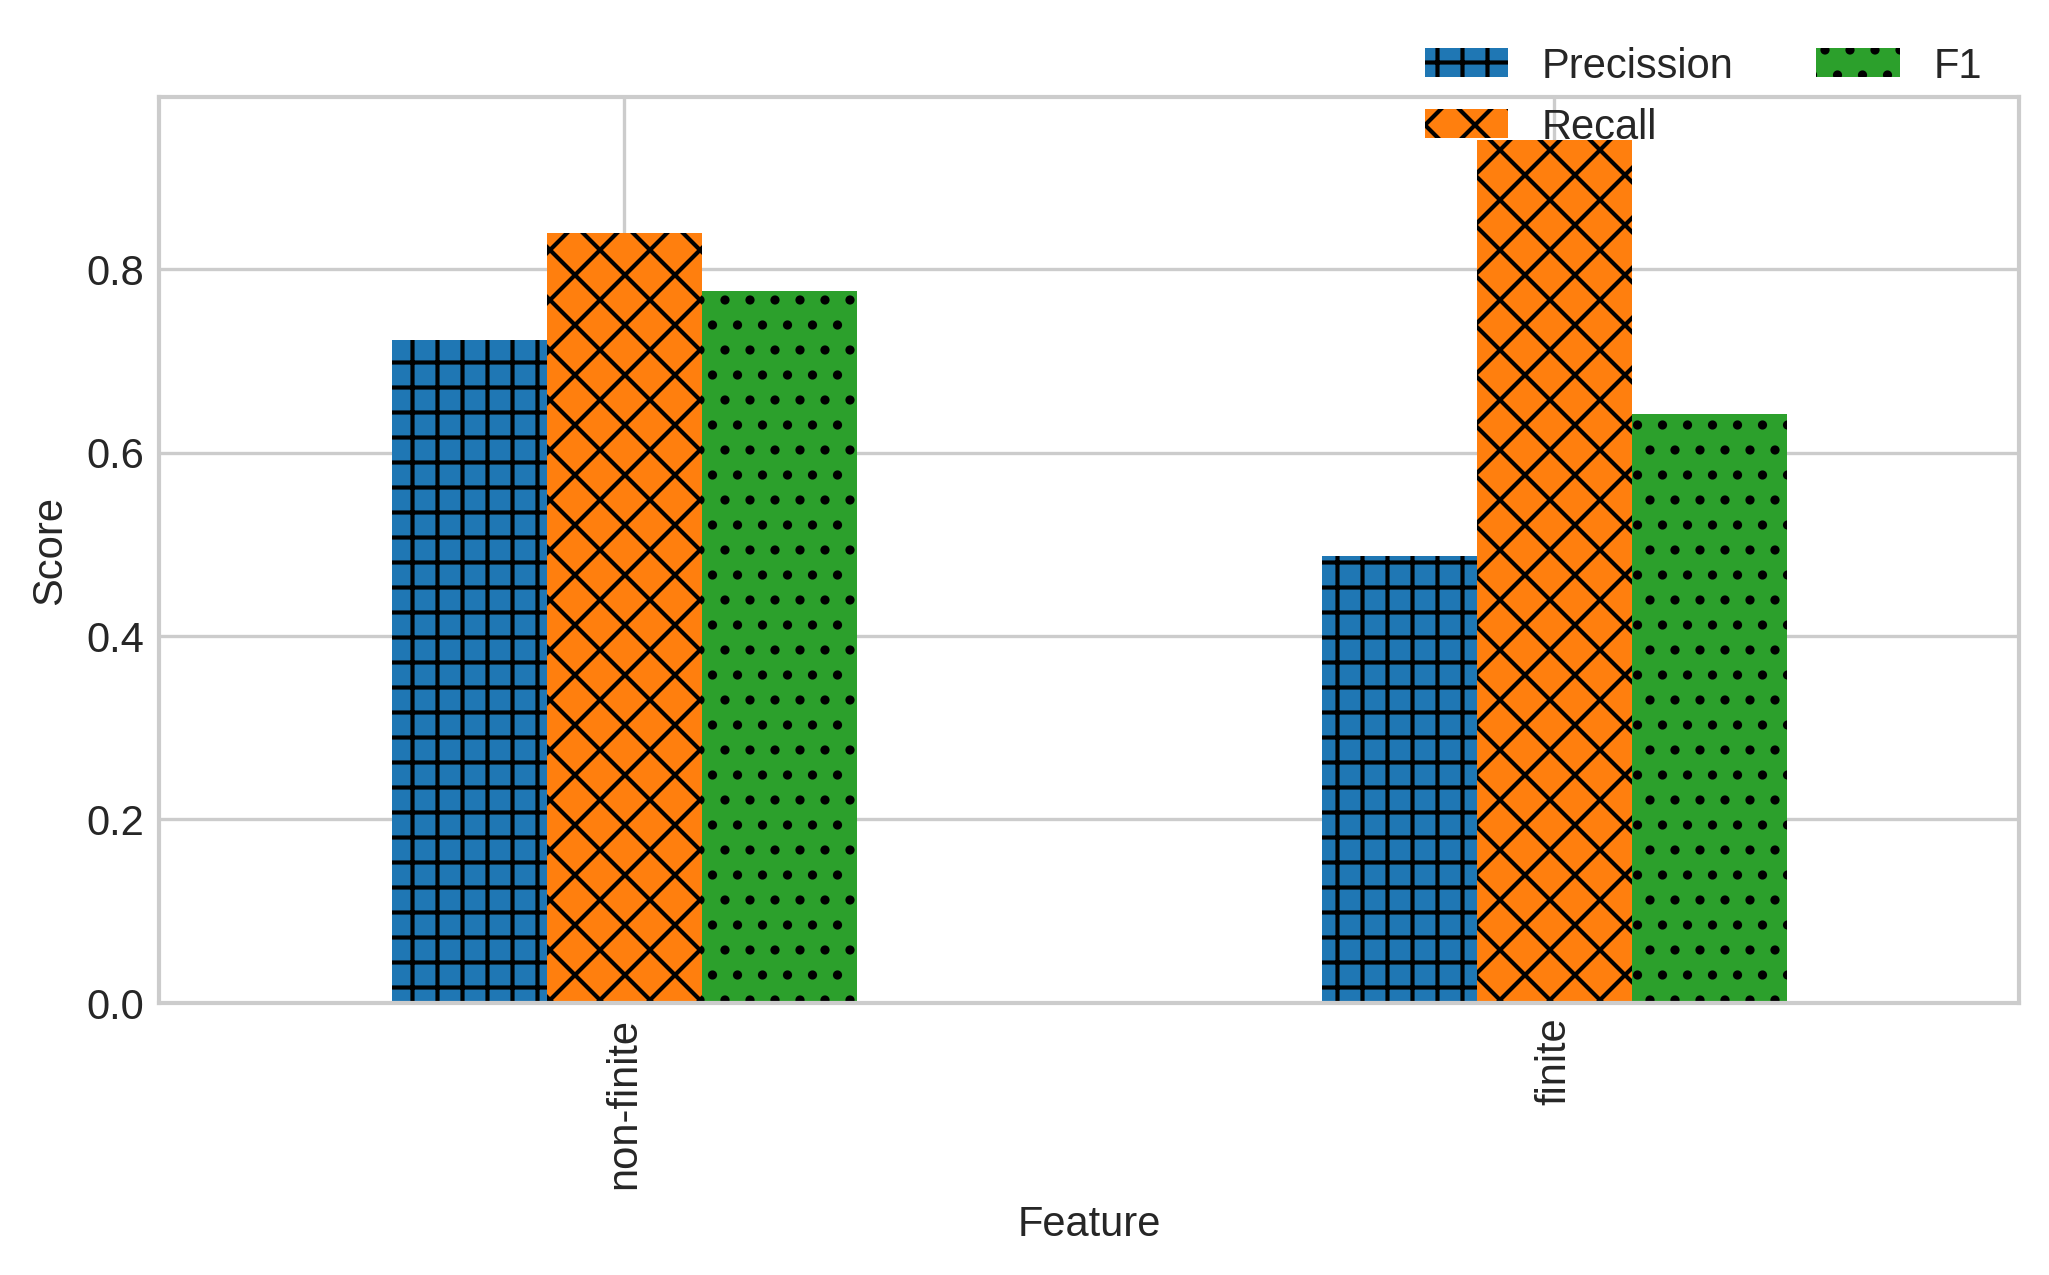

<Figure size 2400x1200 with 0 Axes>

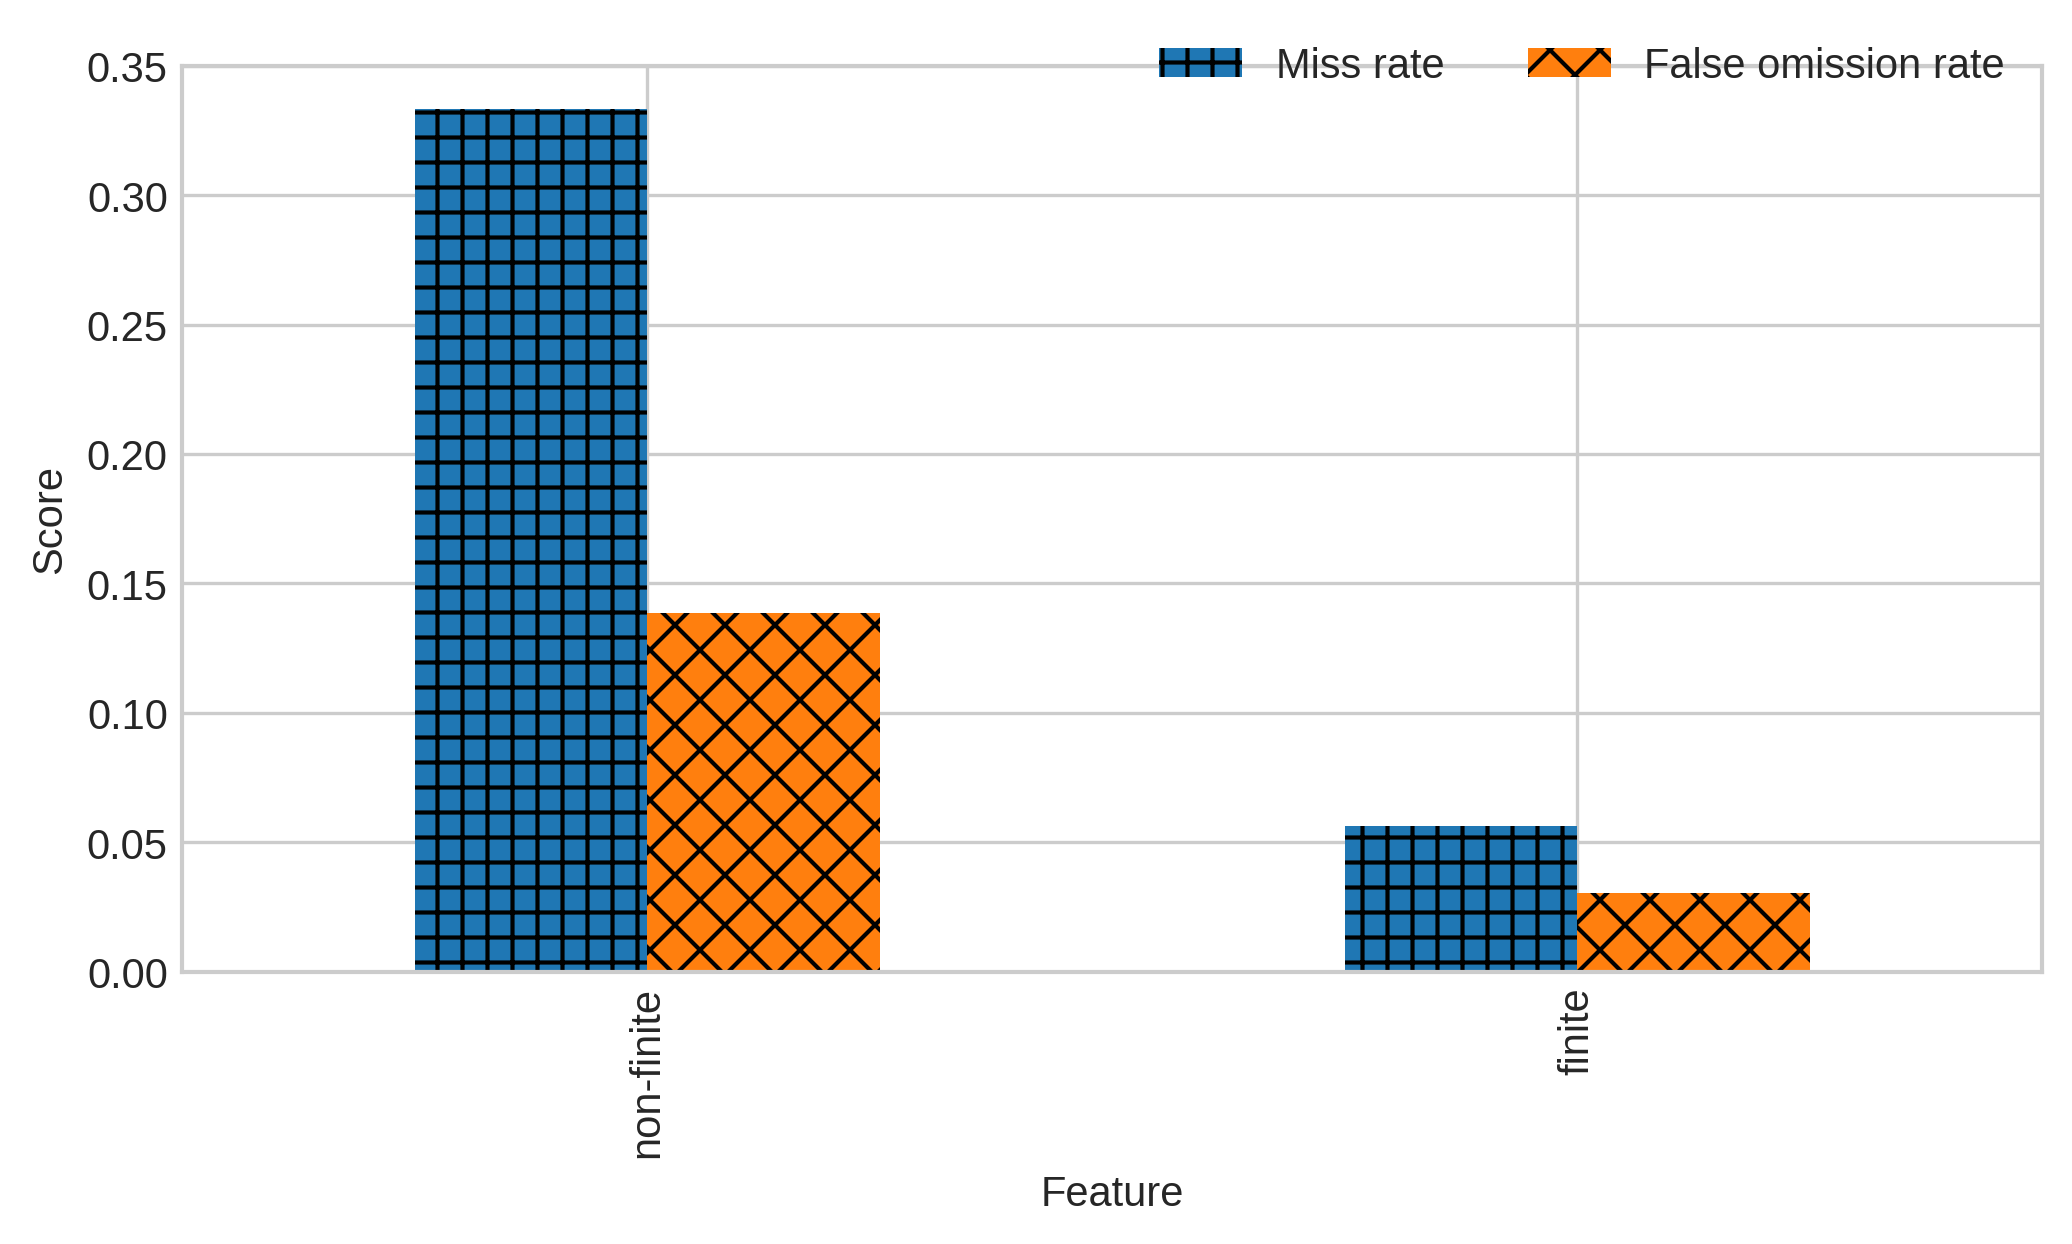

<Figure size 2400x1200 with 0 Axes>

In [36]:
make_stats2(aggregate, "FINITENESS-ocd", filters=FINITENESS)

## MOOD

<Figure size 2400x1200 with 0 Axes>

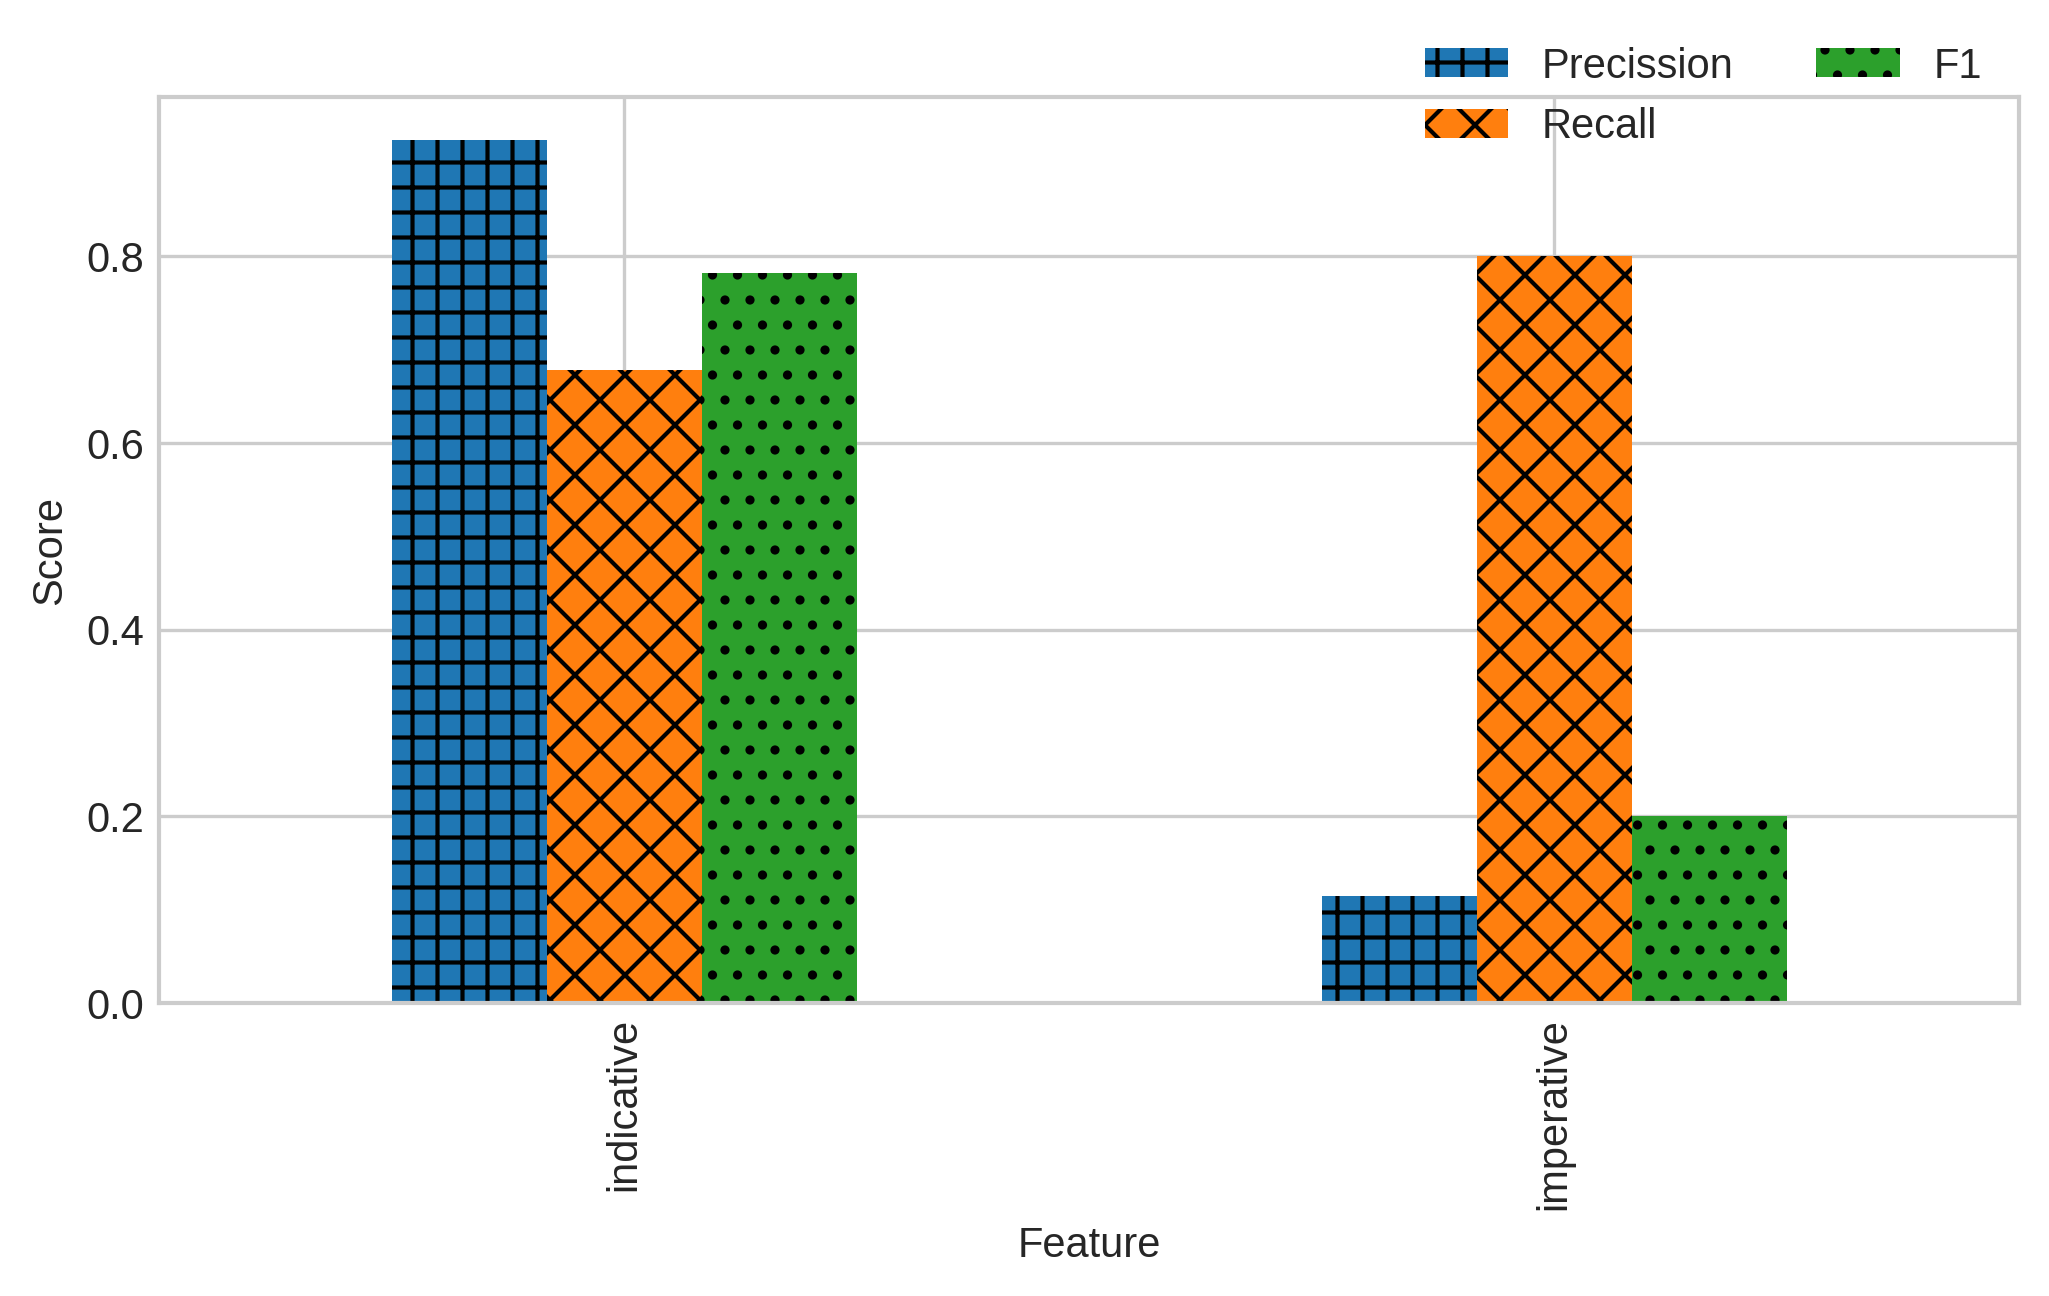

<Figure size 2400x1200 with 0 Axes>

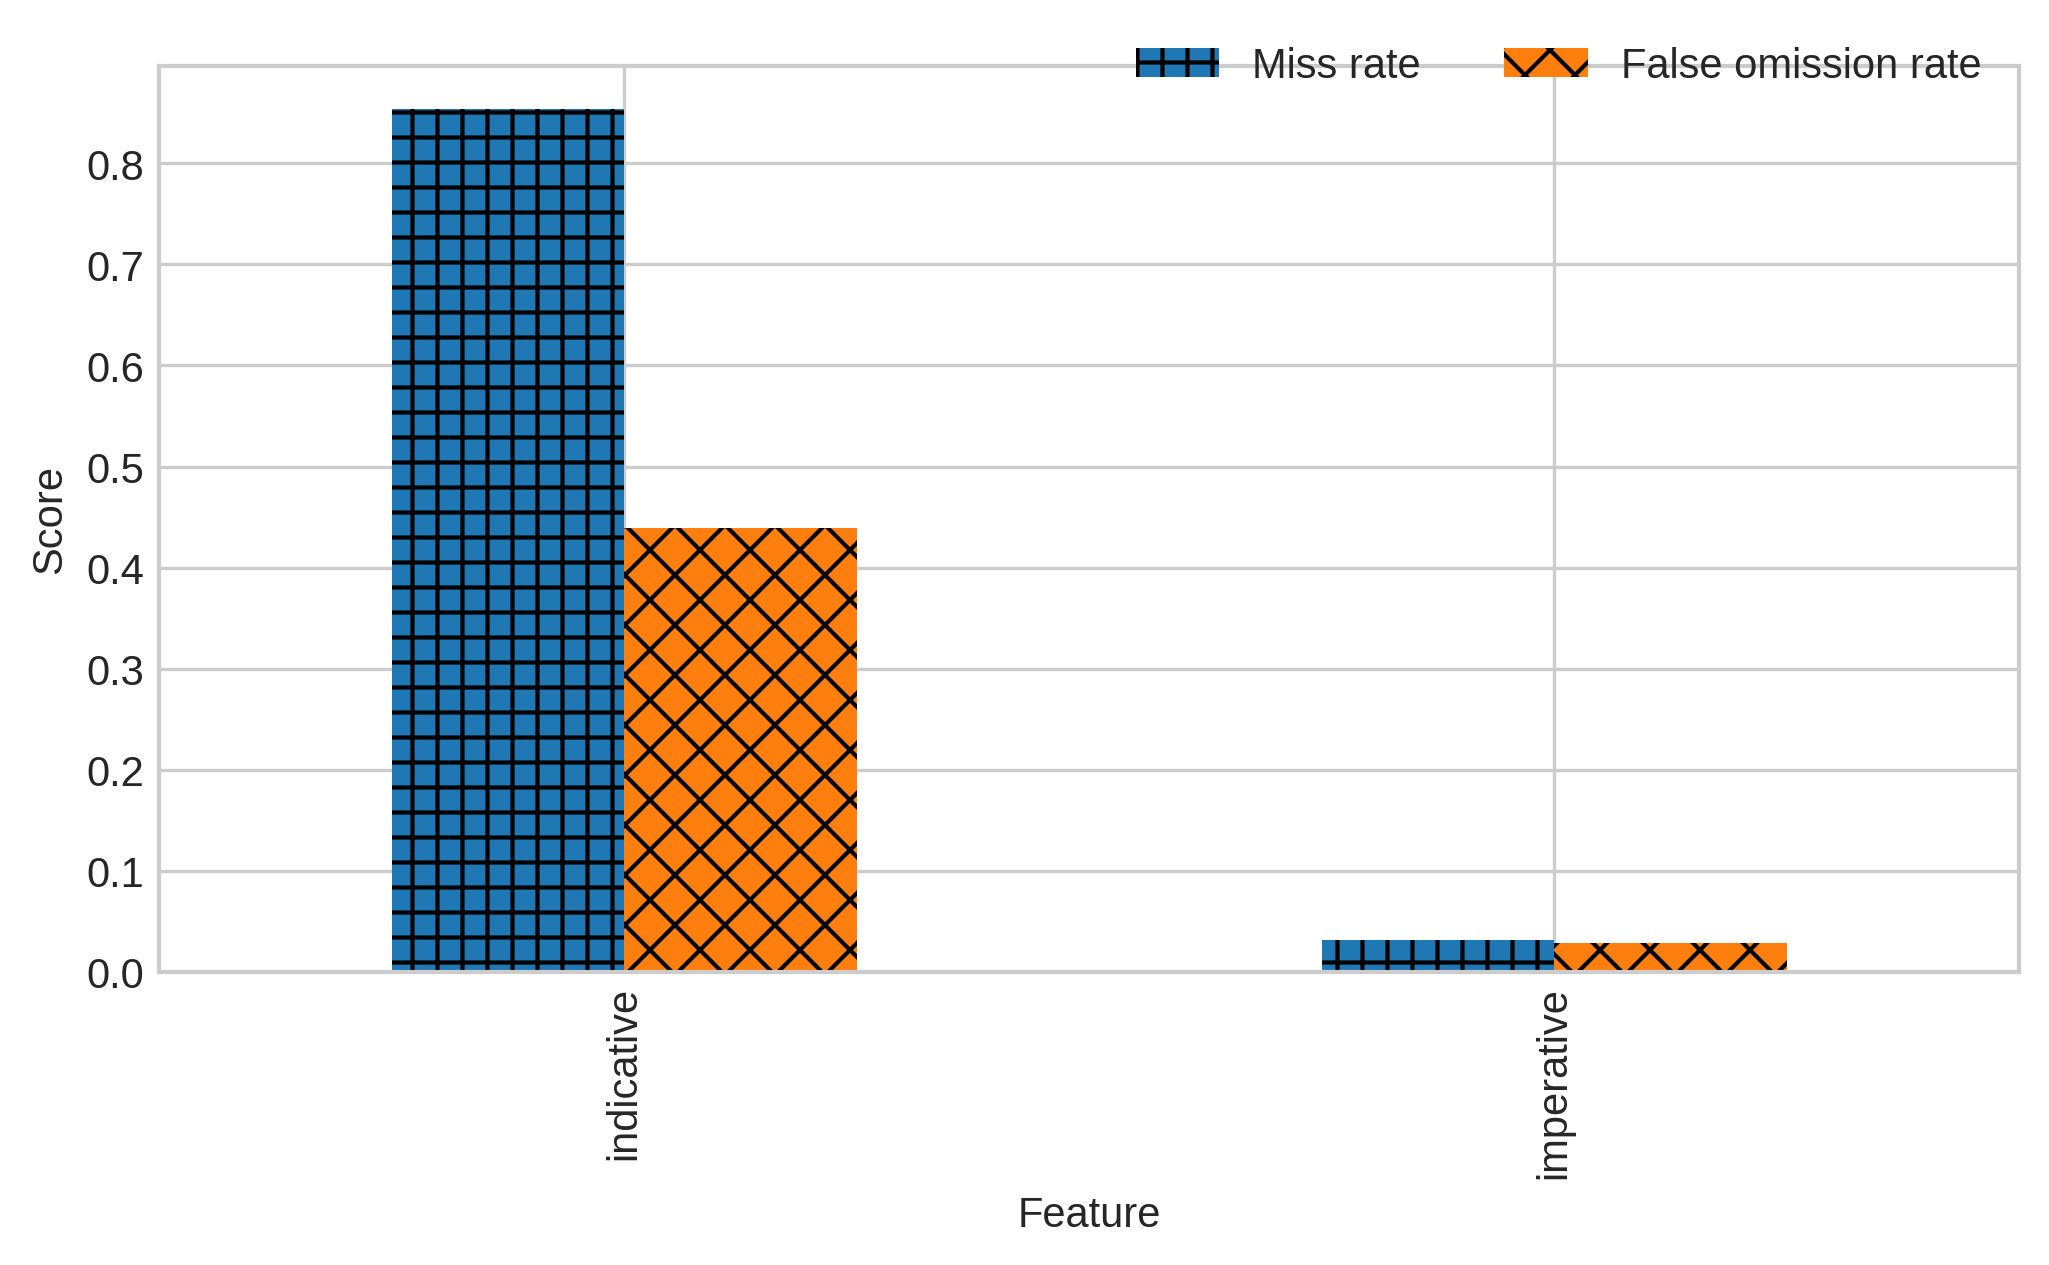

<Figure size 2400x1200 with 0 Axes>

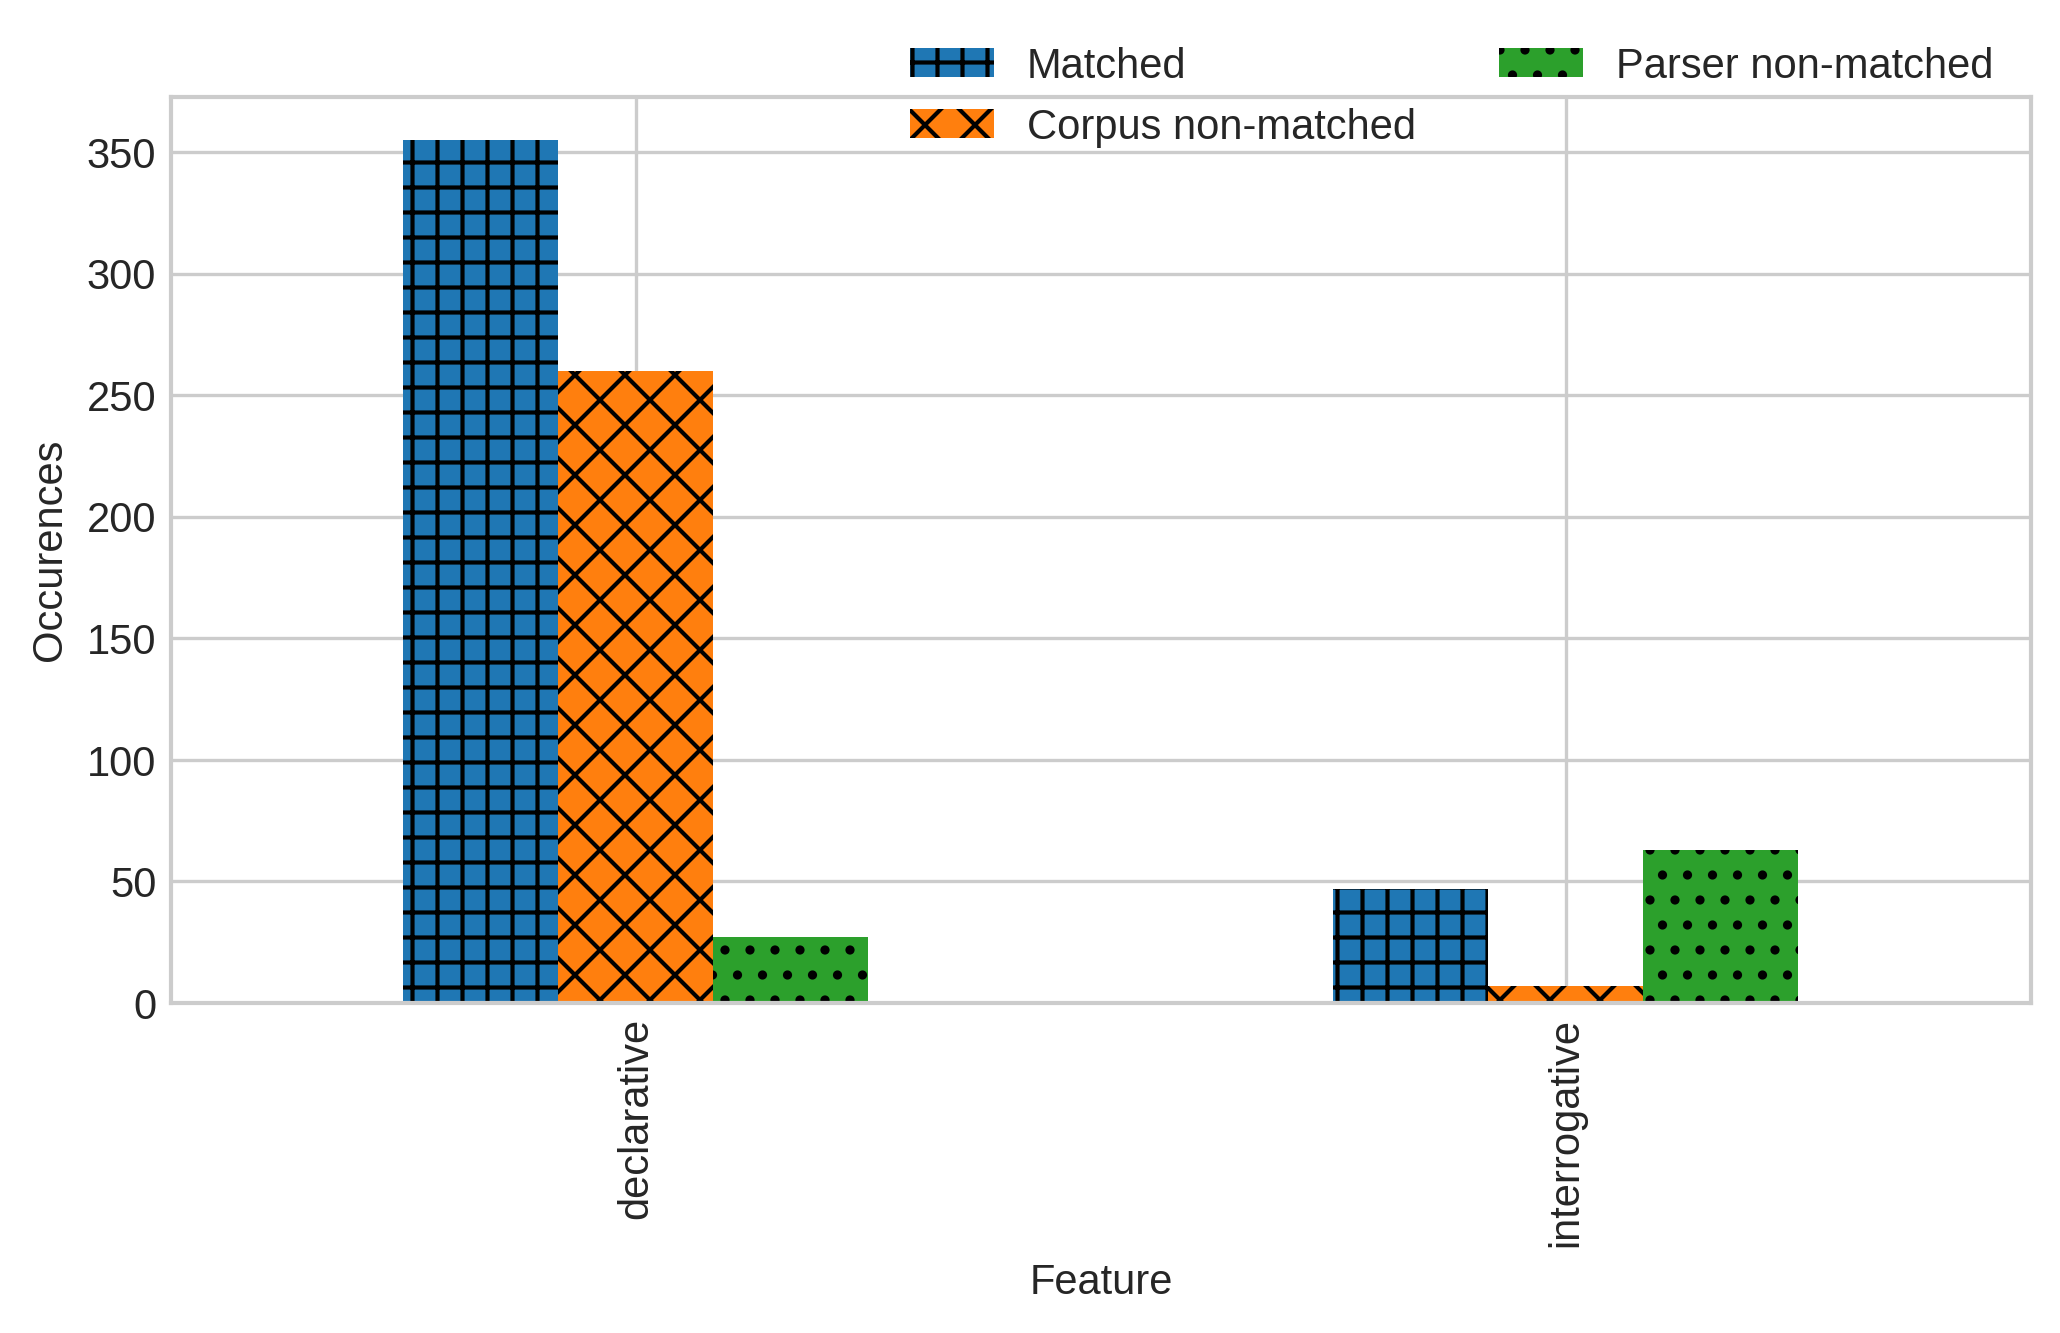

<Figure size 2400x1200 with 0 Axes>

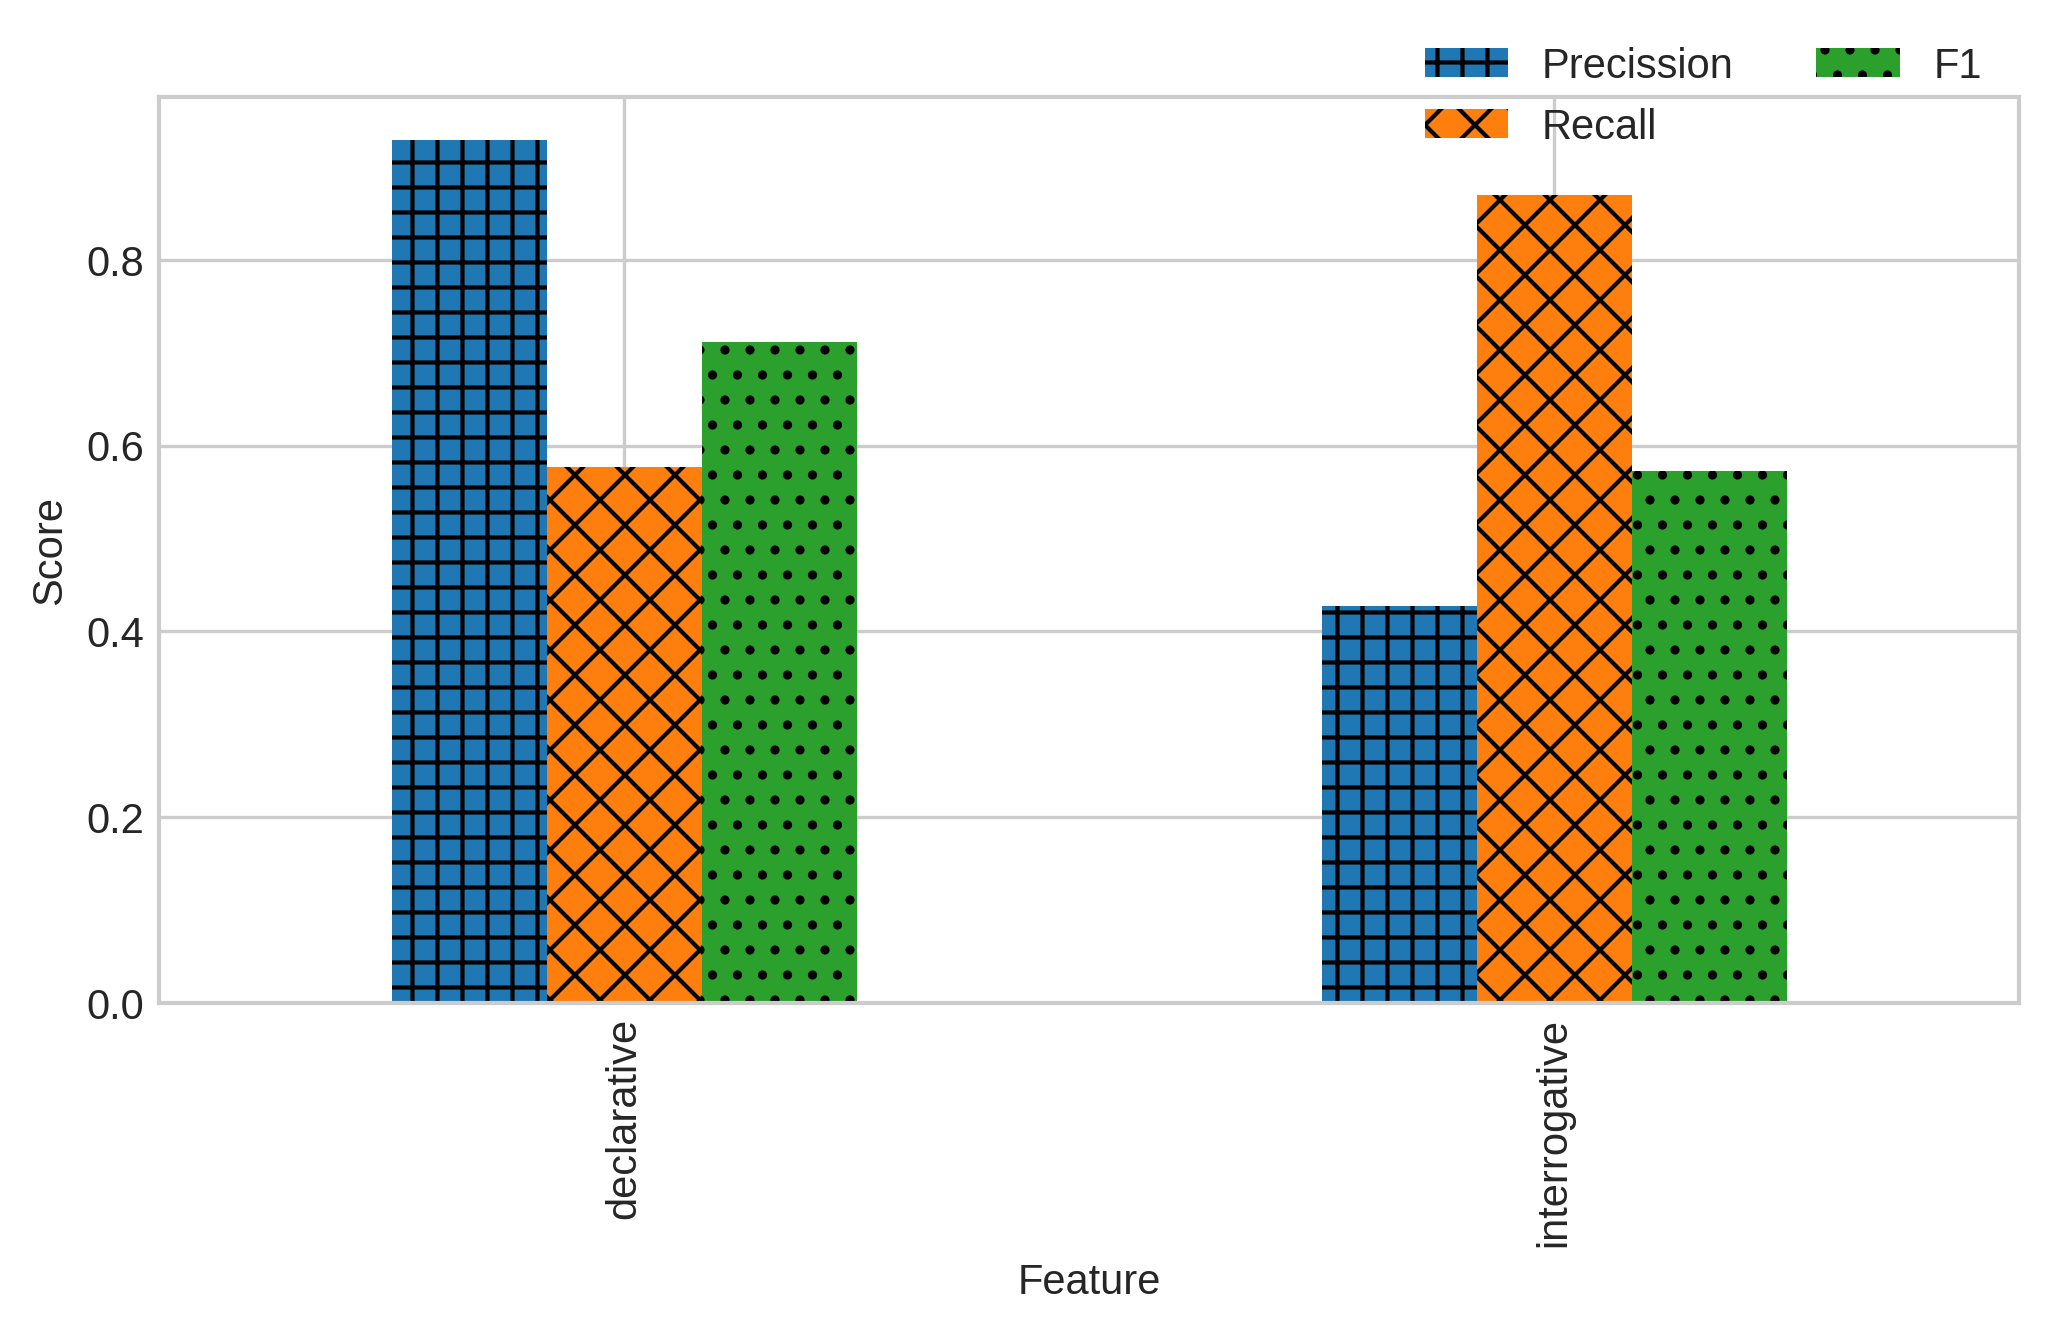

<Figure size 2400x1200 with 0 Axes>

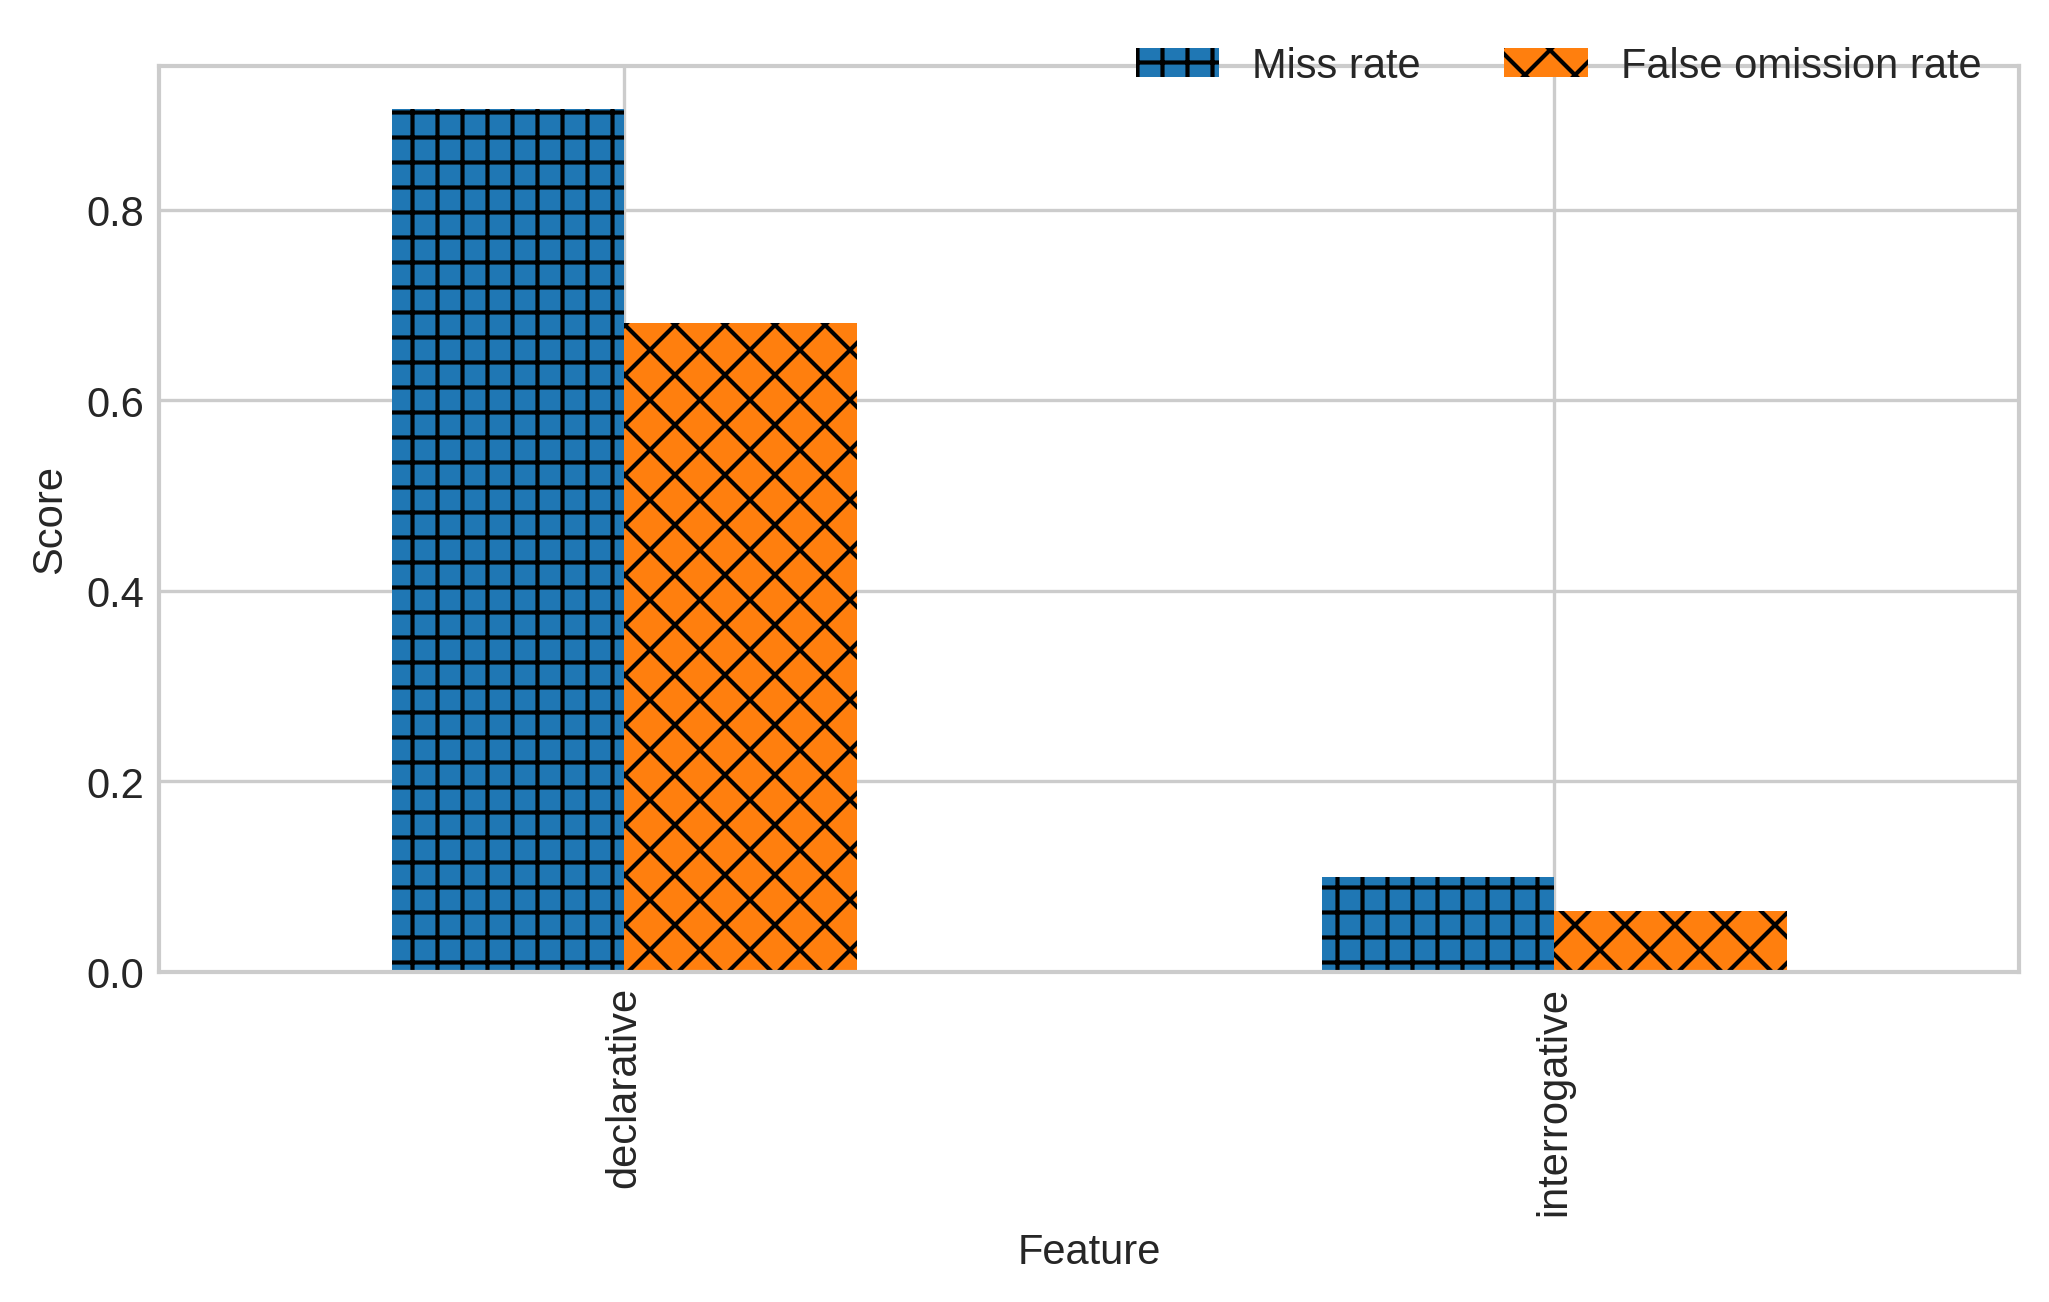

<Figure size 2400x1200 with 0 Axes>

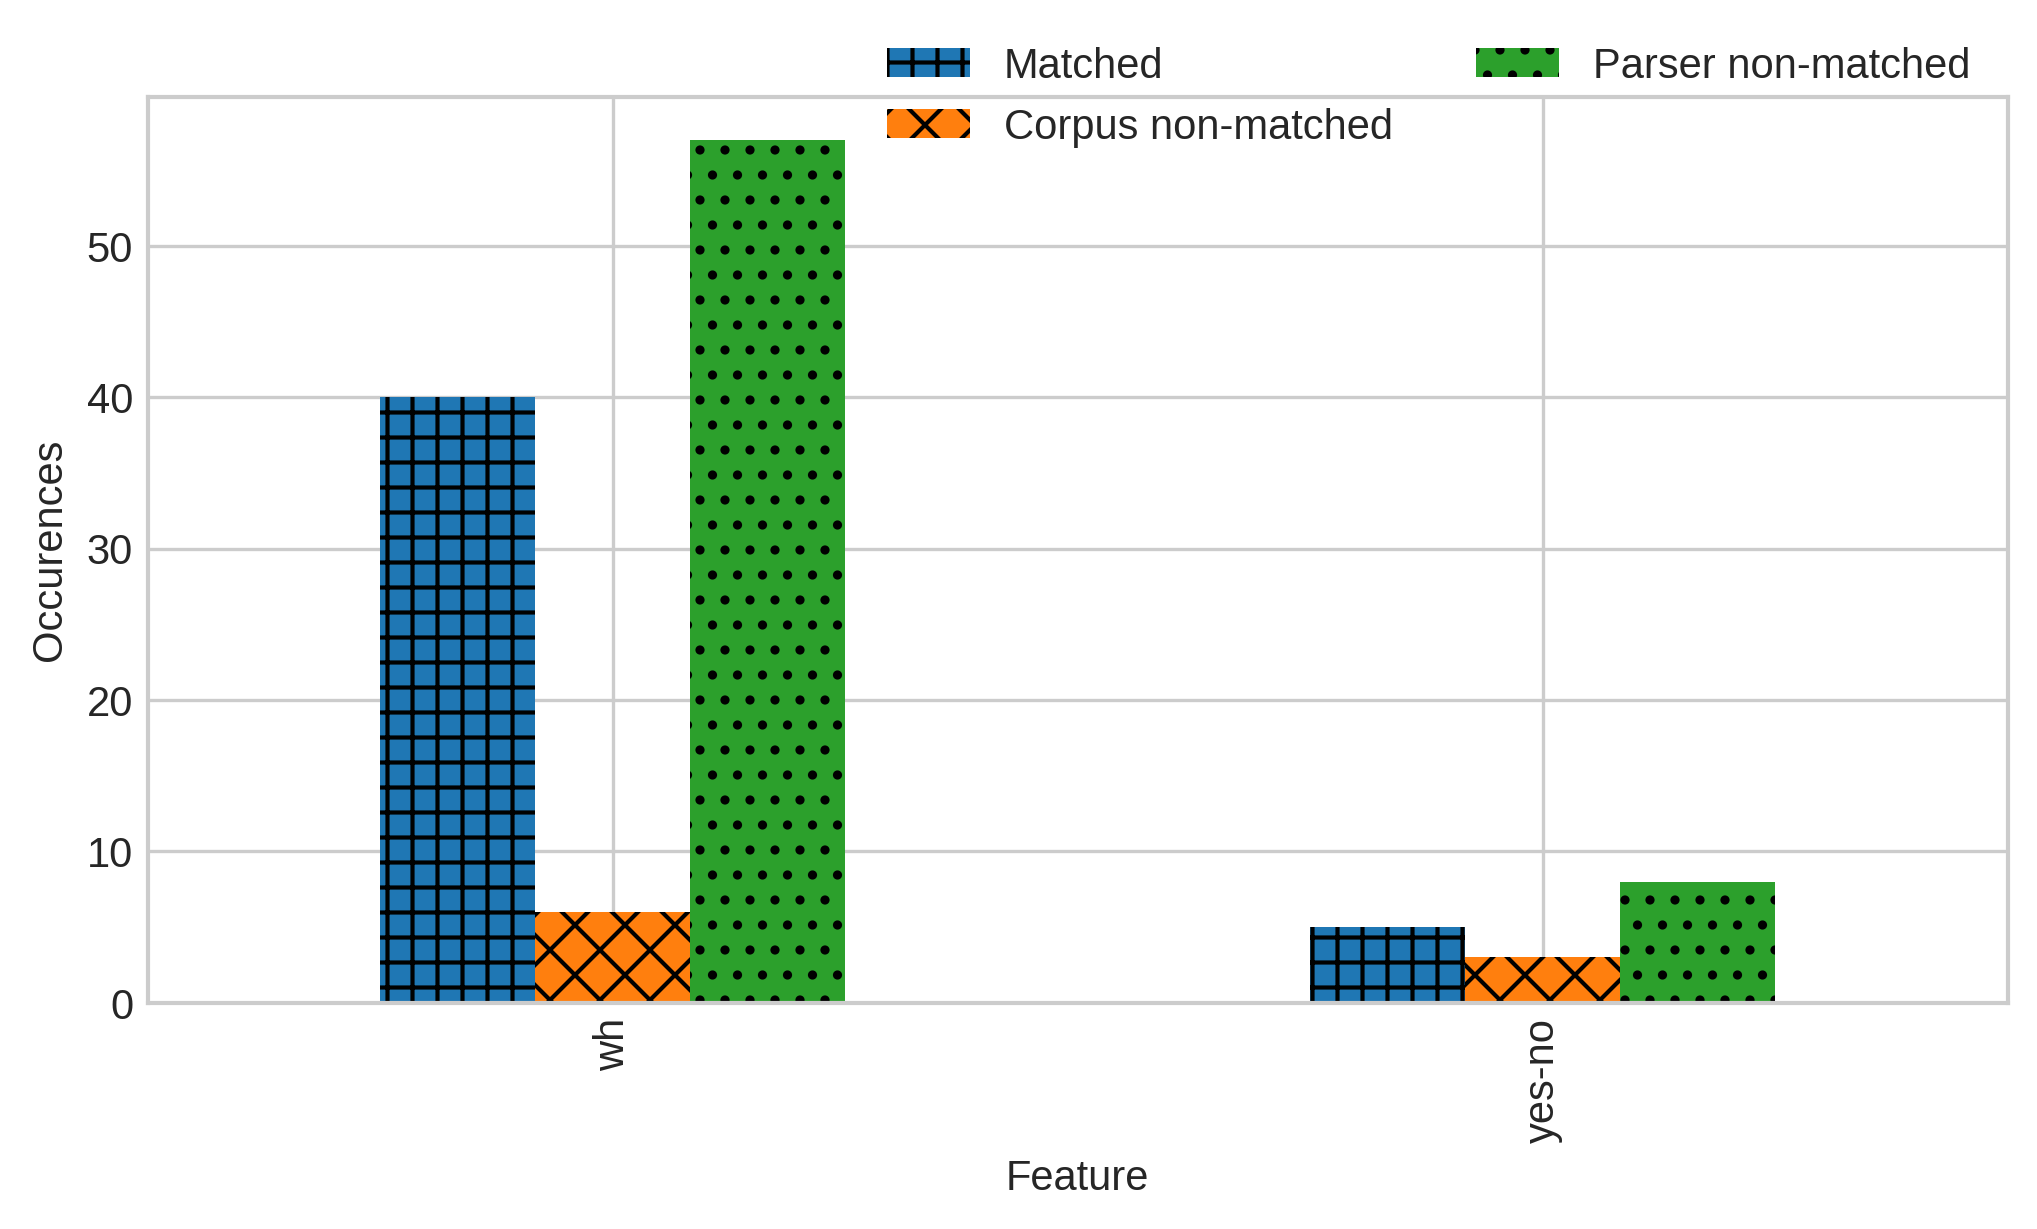

<Figure size 2400x1200 with 0 Axes>

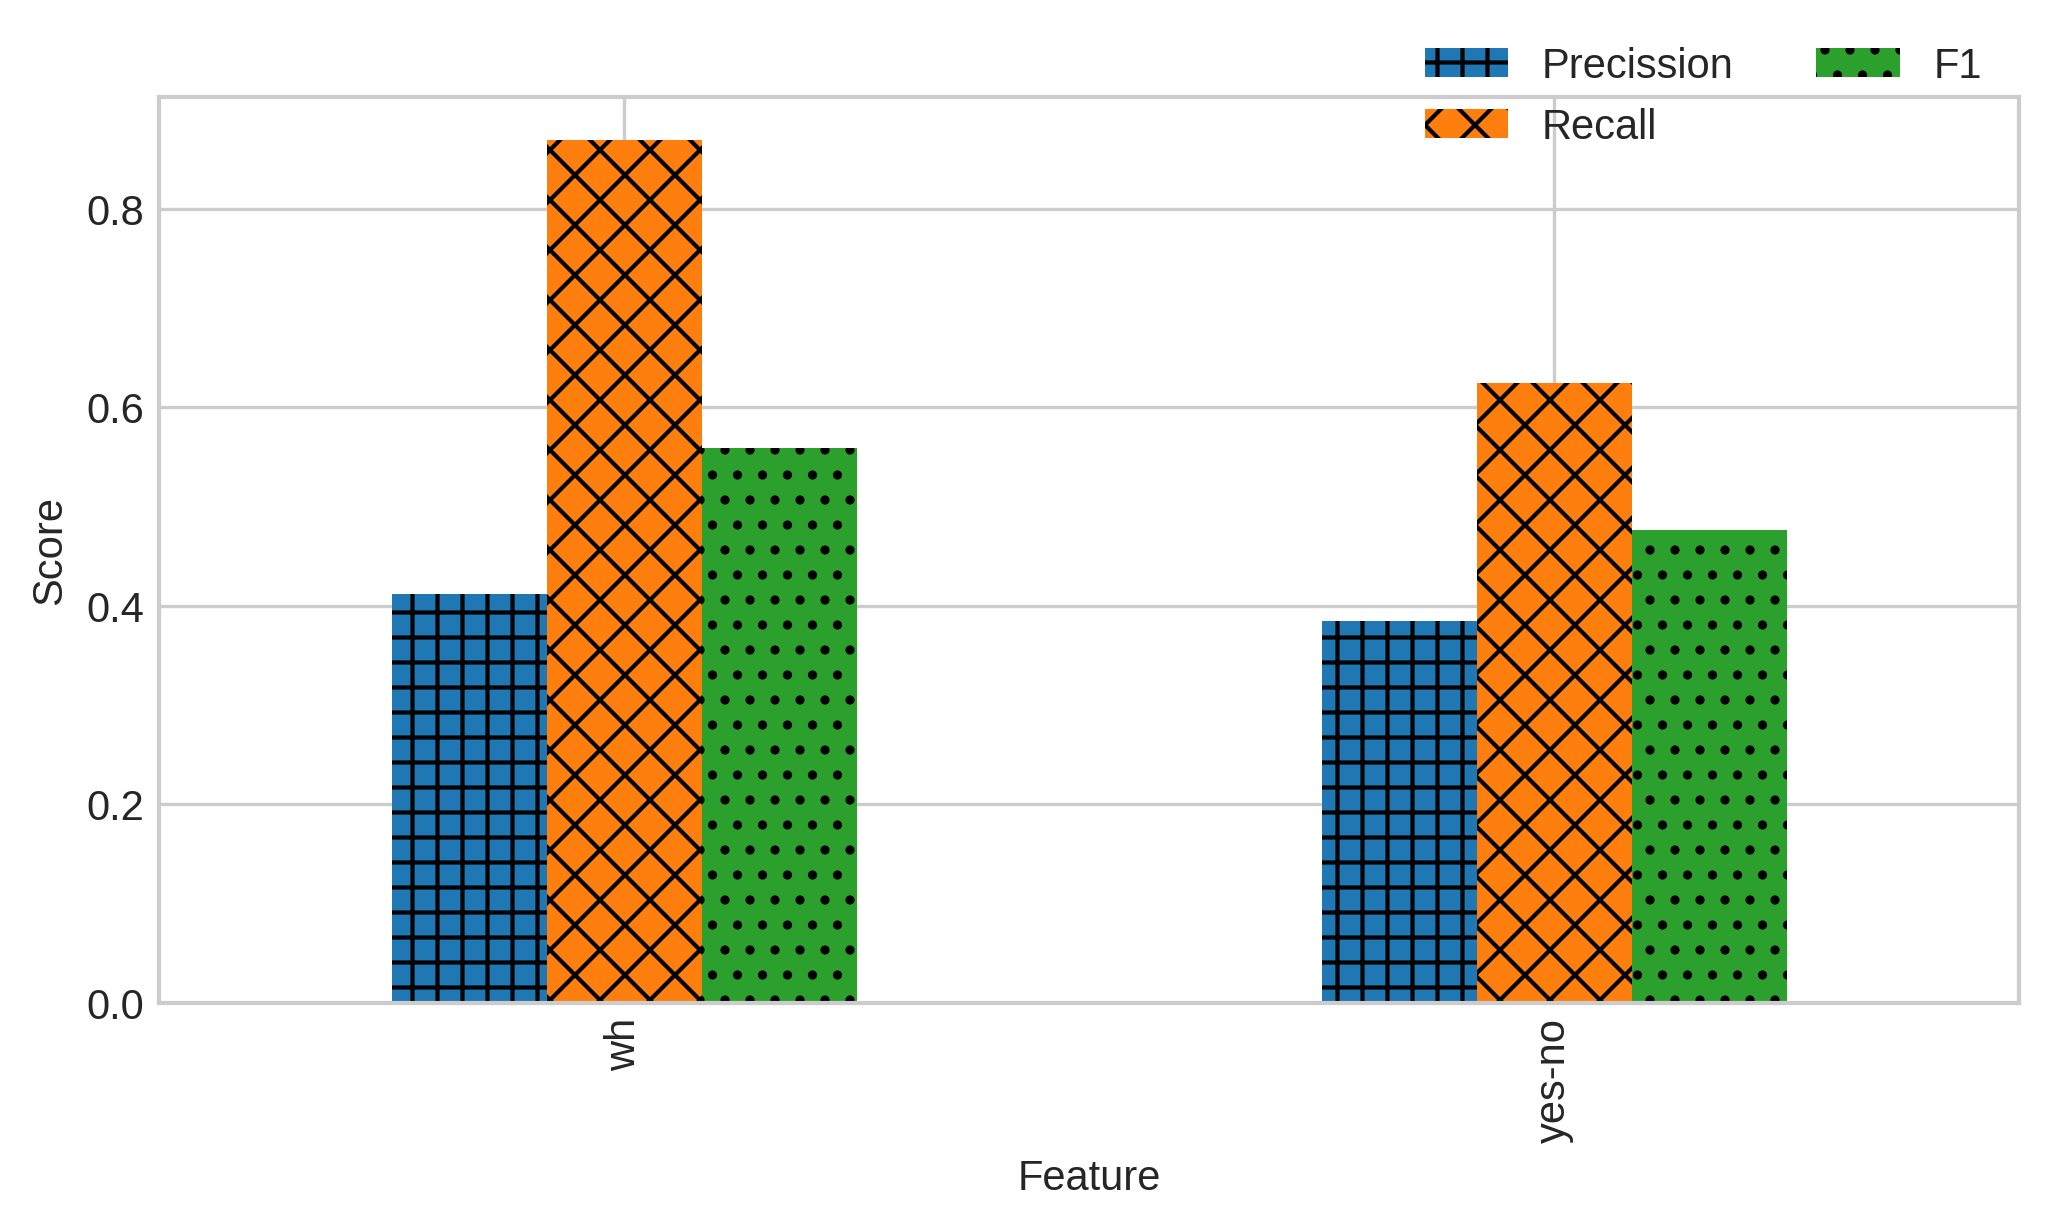

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

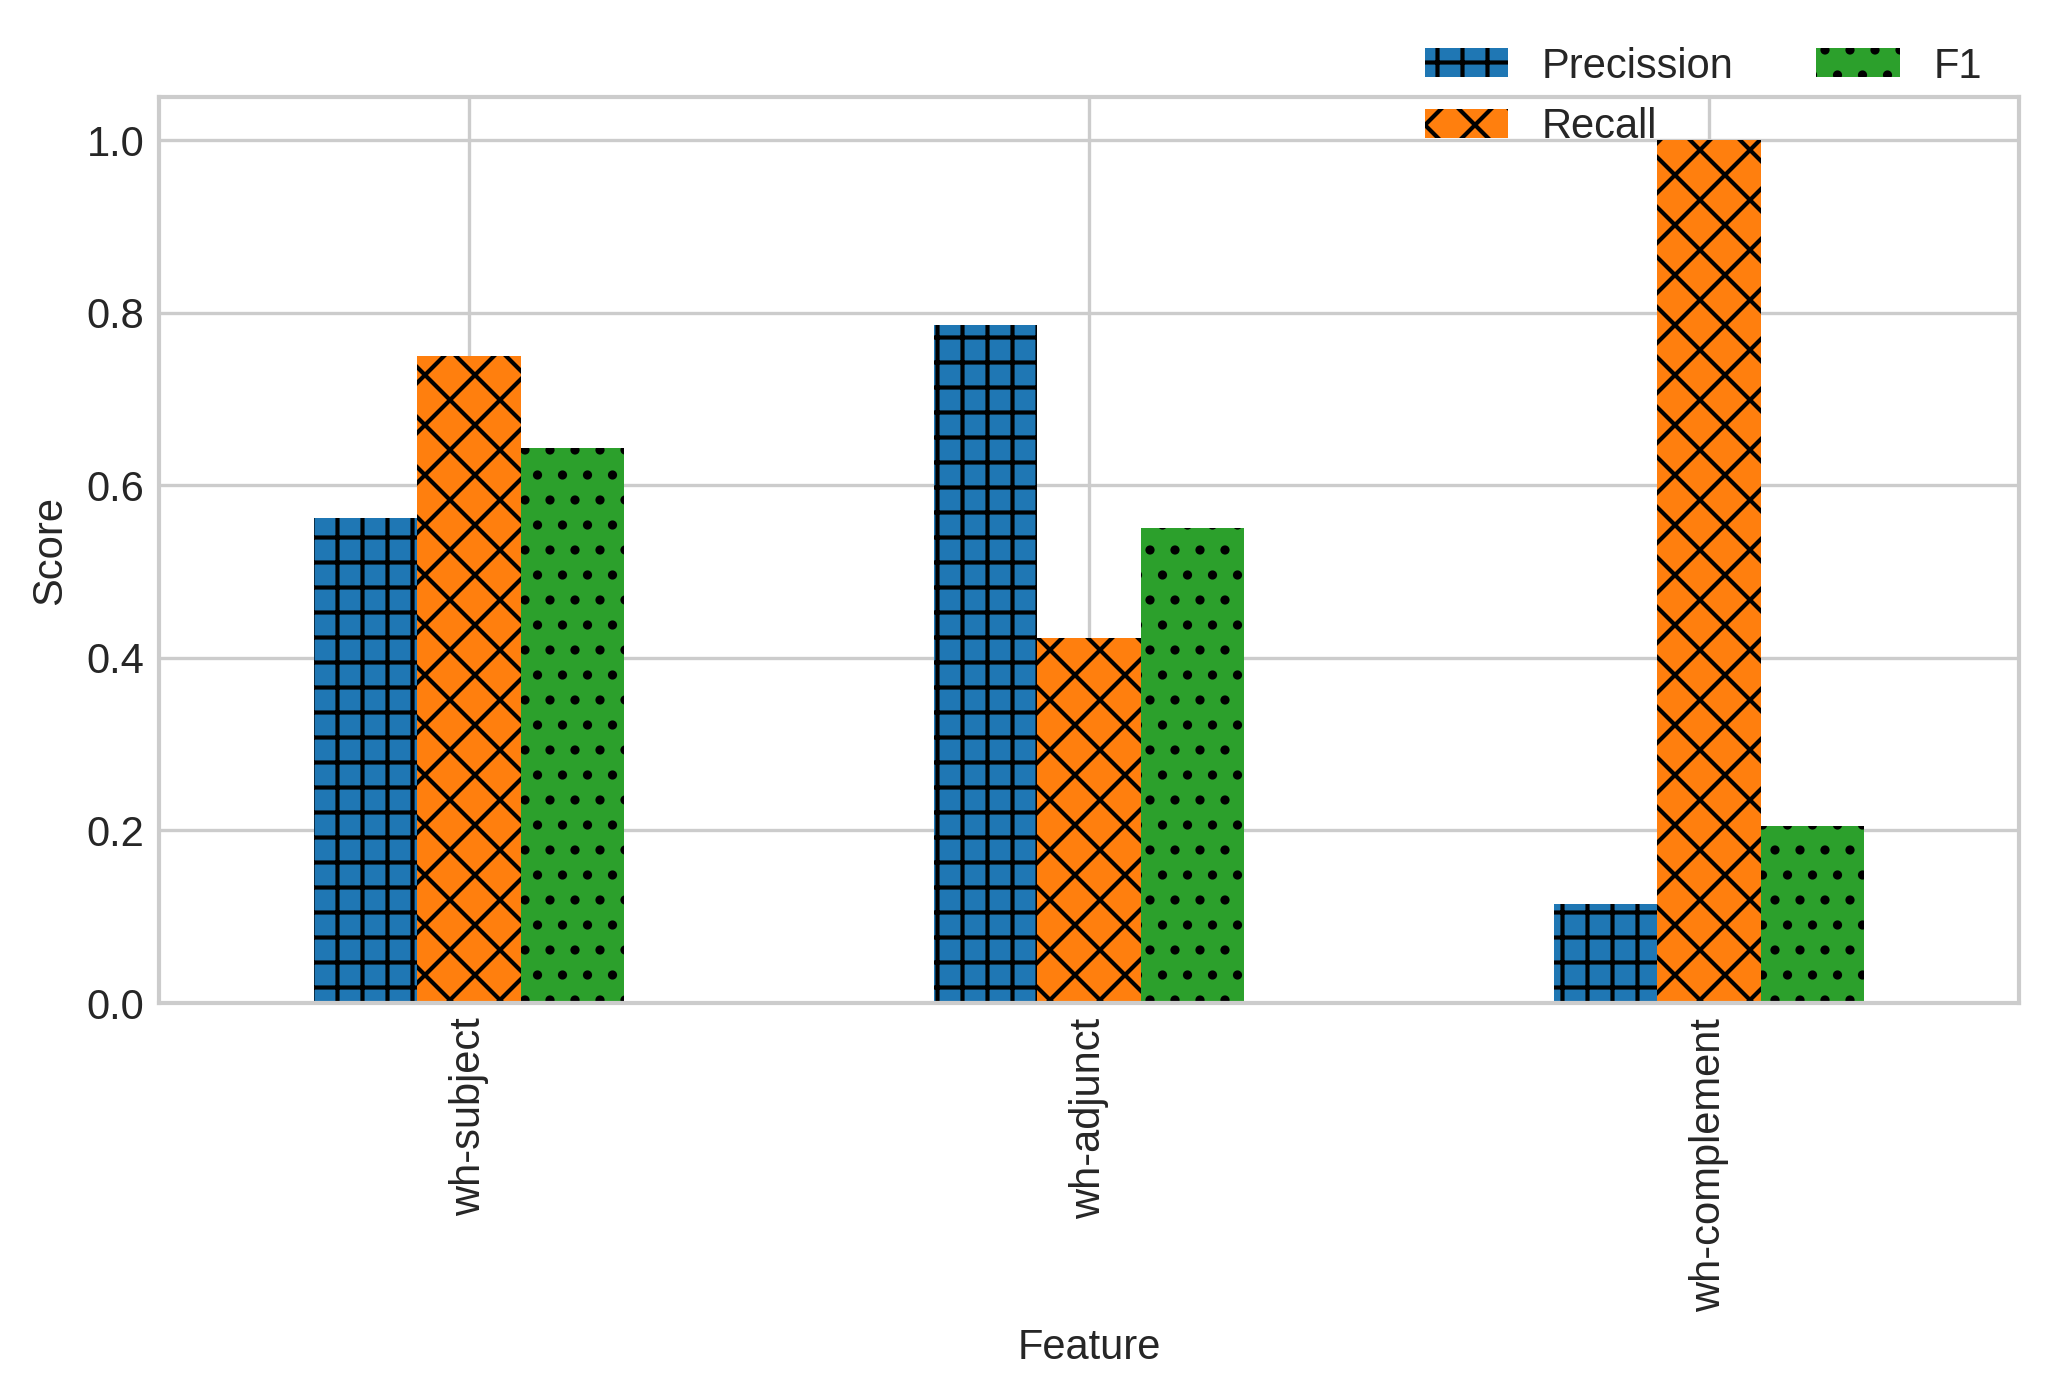

<Figure size 2400x1200 with 0 Axes>

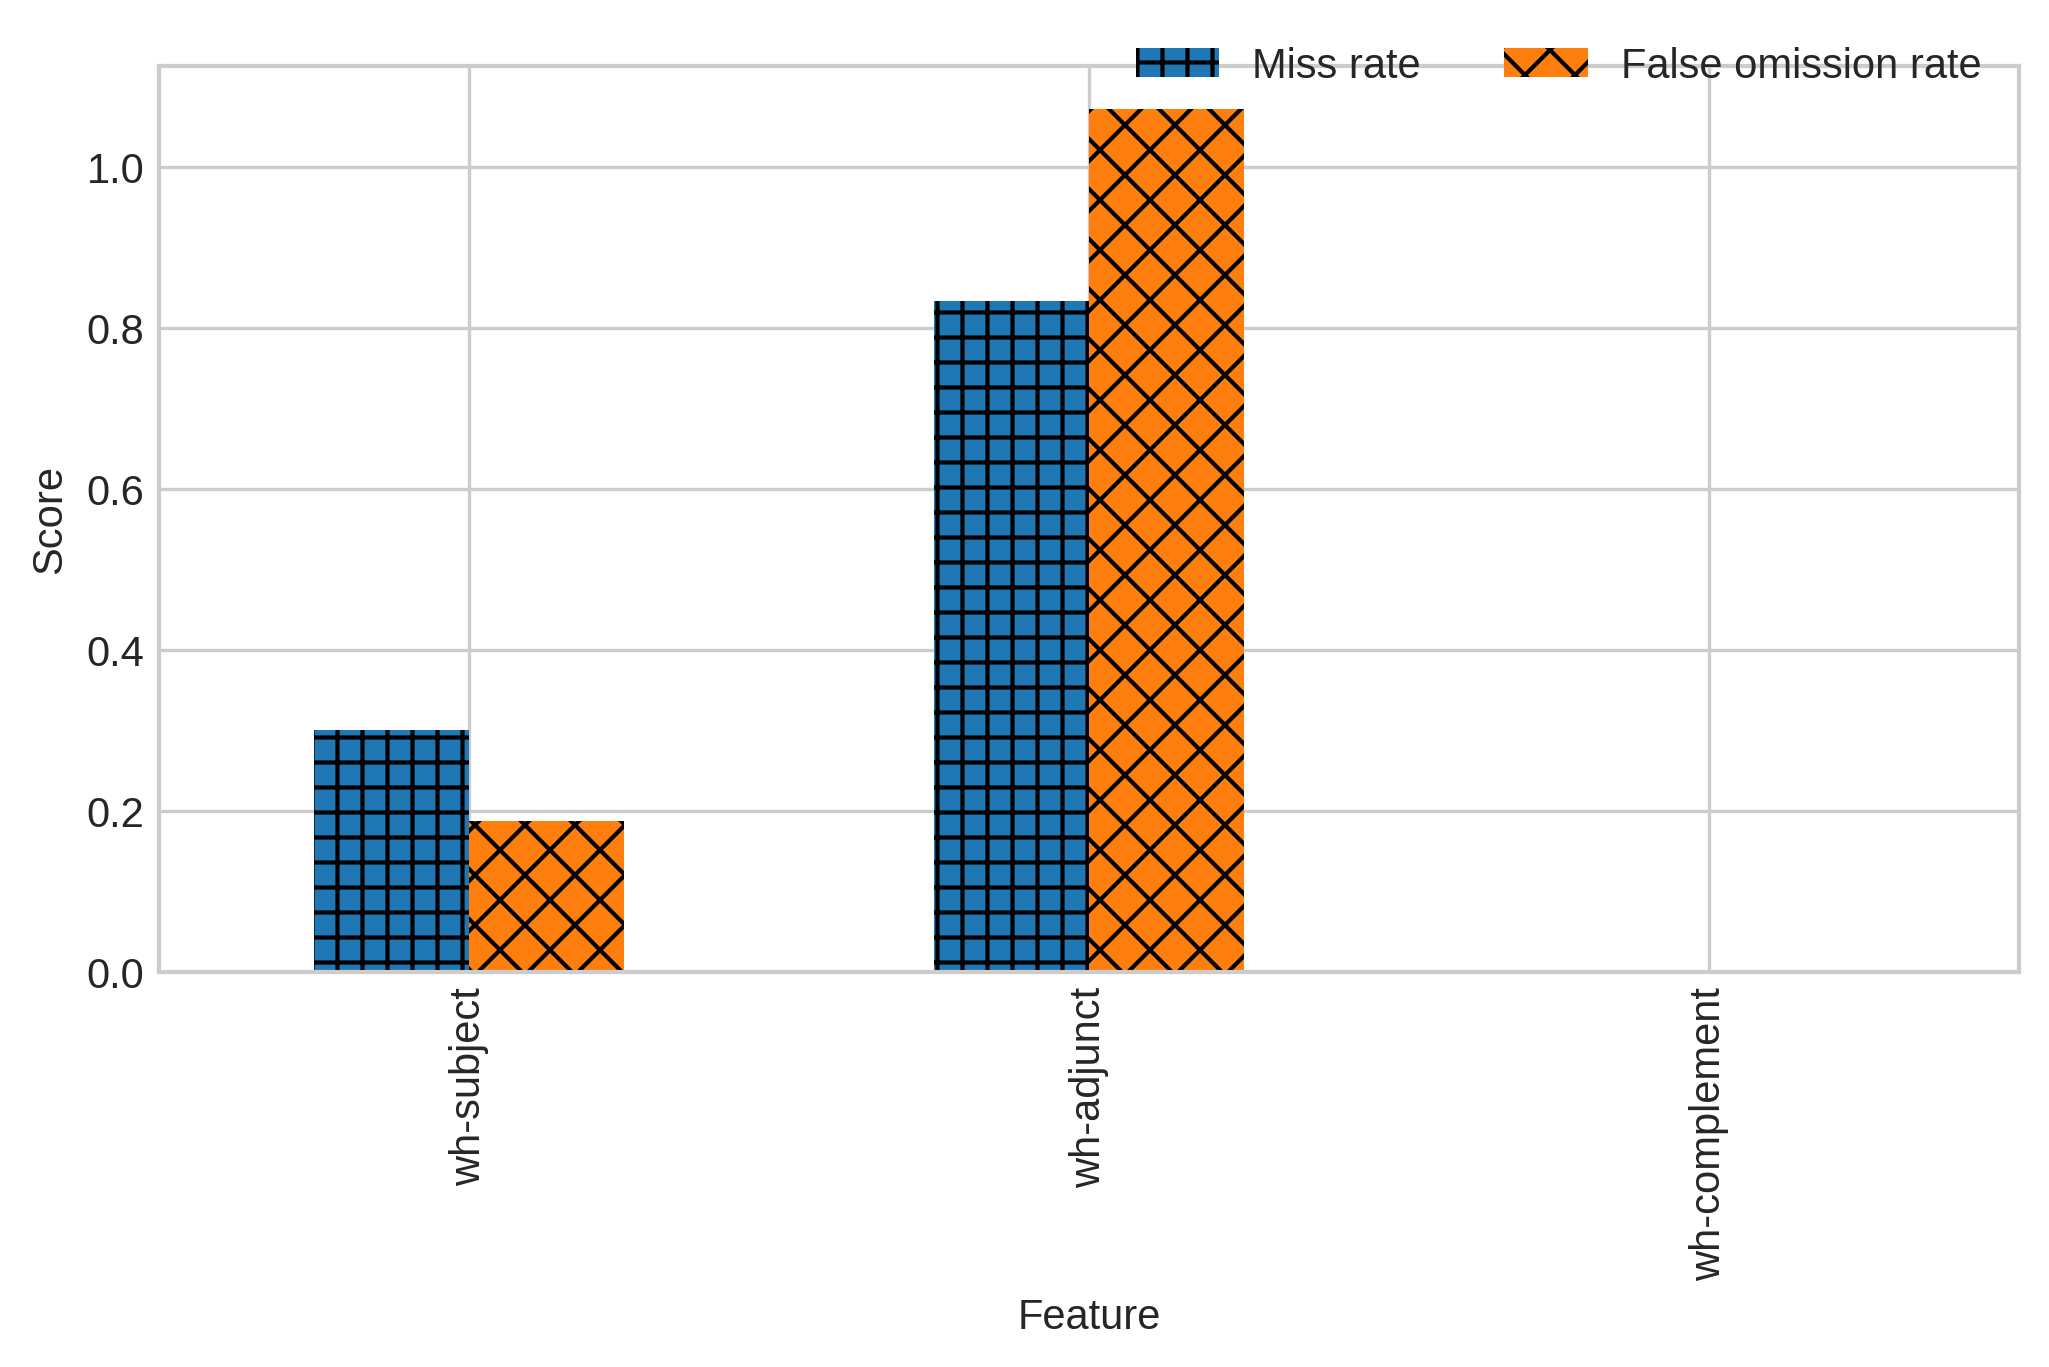

<Figure size 2400x1200 with 0 Axes>

In [37]:
make_stats2(aggregate, "MOOD-ocd", filters=MOOD)
make_stats2(aggregate, "INDICATIVE-ocd", filters=INDICATIVE)
make_stats2(aggregate, "INTERROGATIVE-ocd", filters=INTERROGATIVE)
make_stats2(aggregate, "WH-ocd", filters=WH)

## DEICTICITY

<Figure size 2400x1200 with 0 Axes>

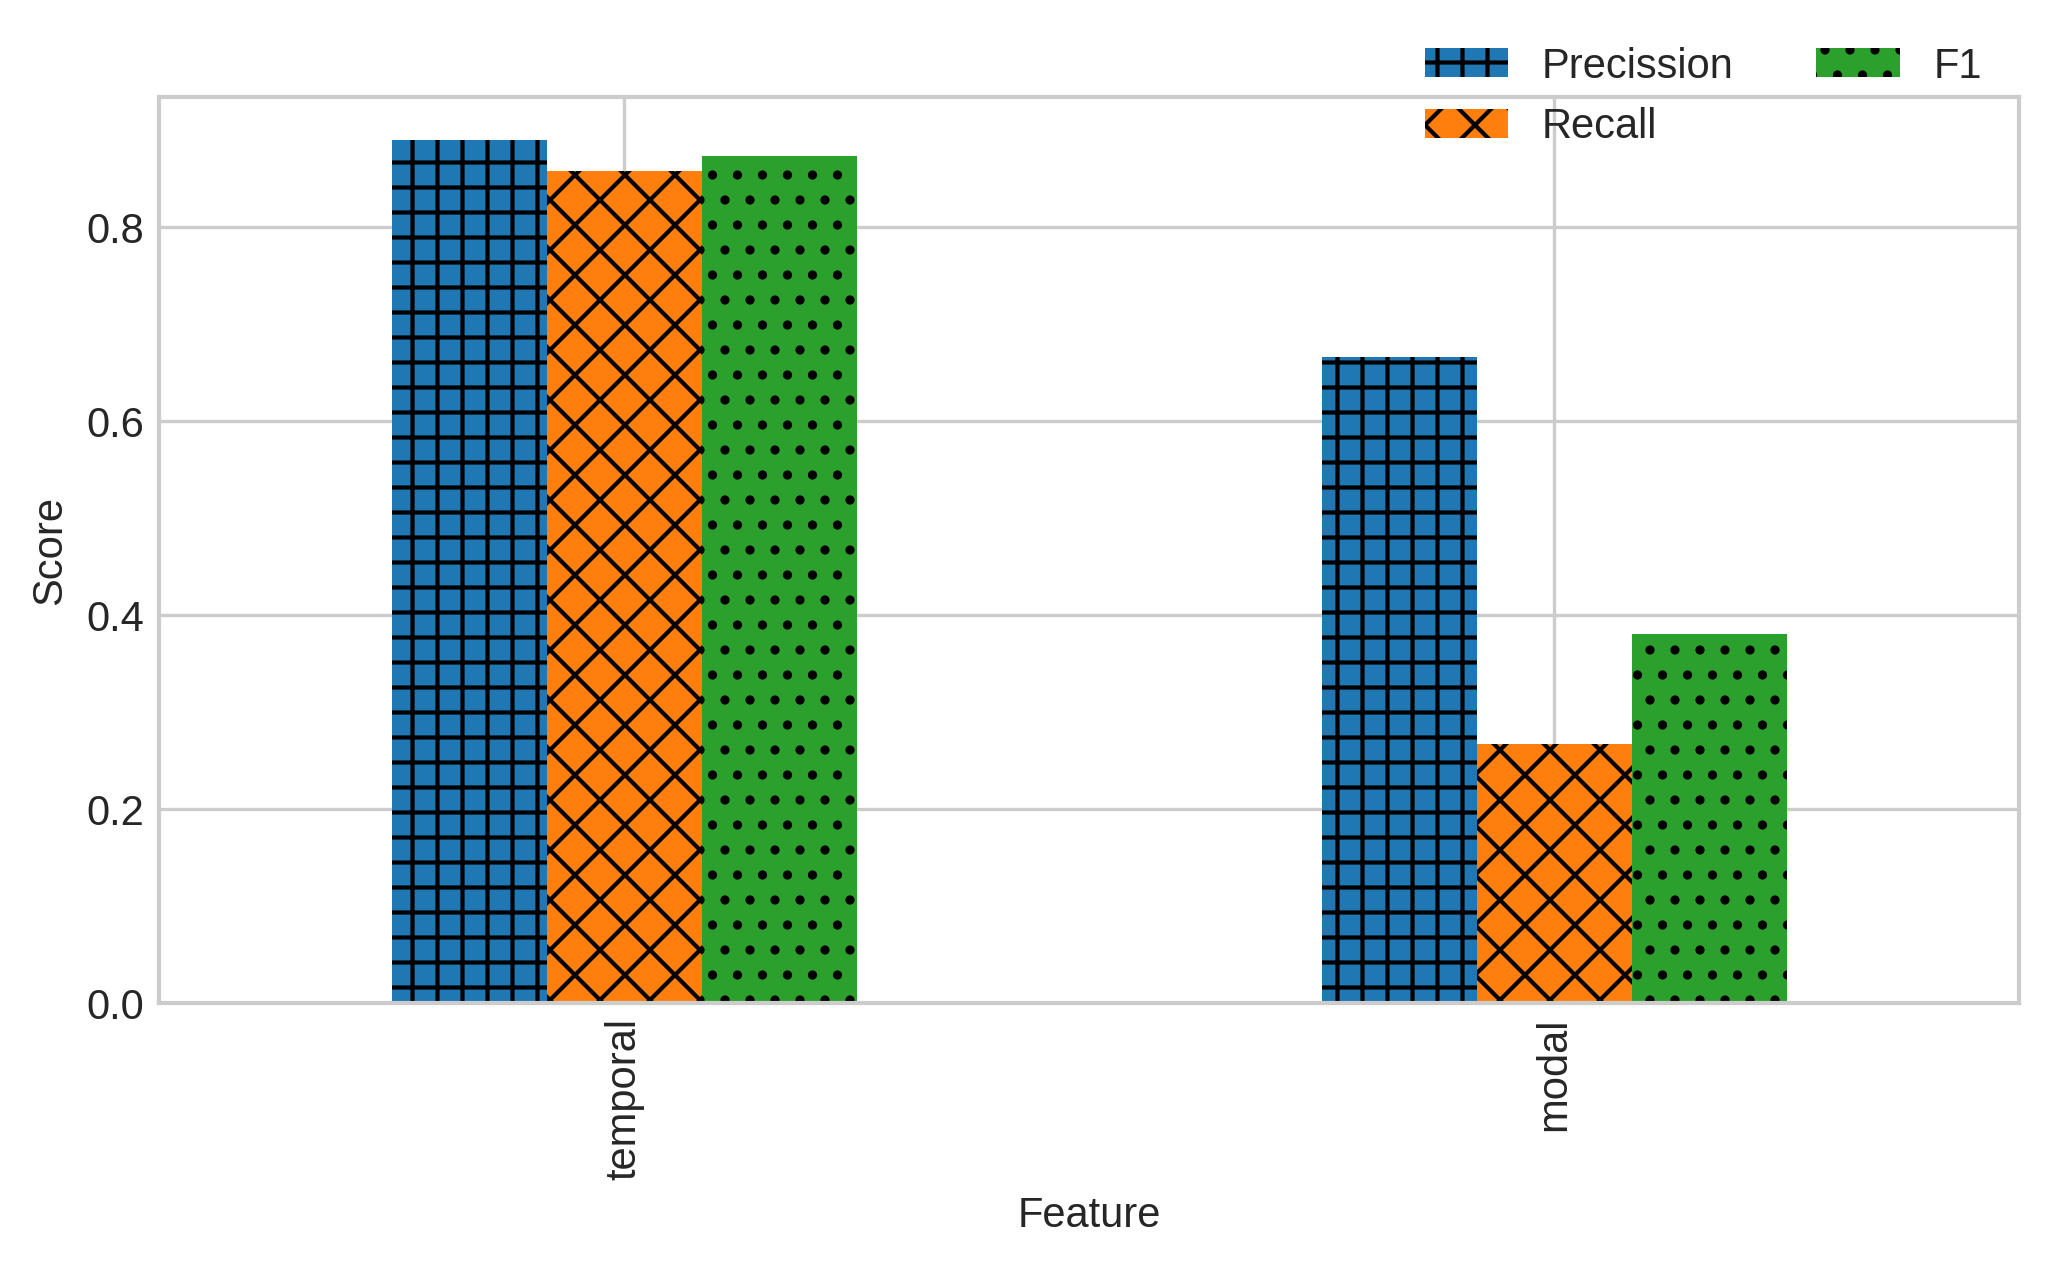

<Figure size 2400x1200 with 0 Axes>

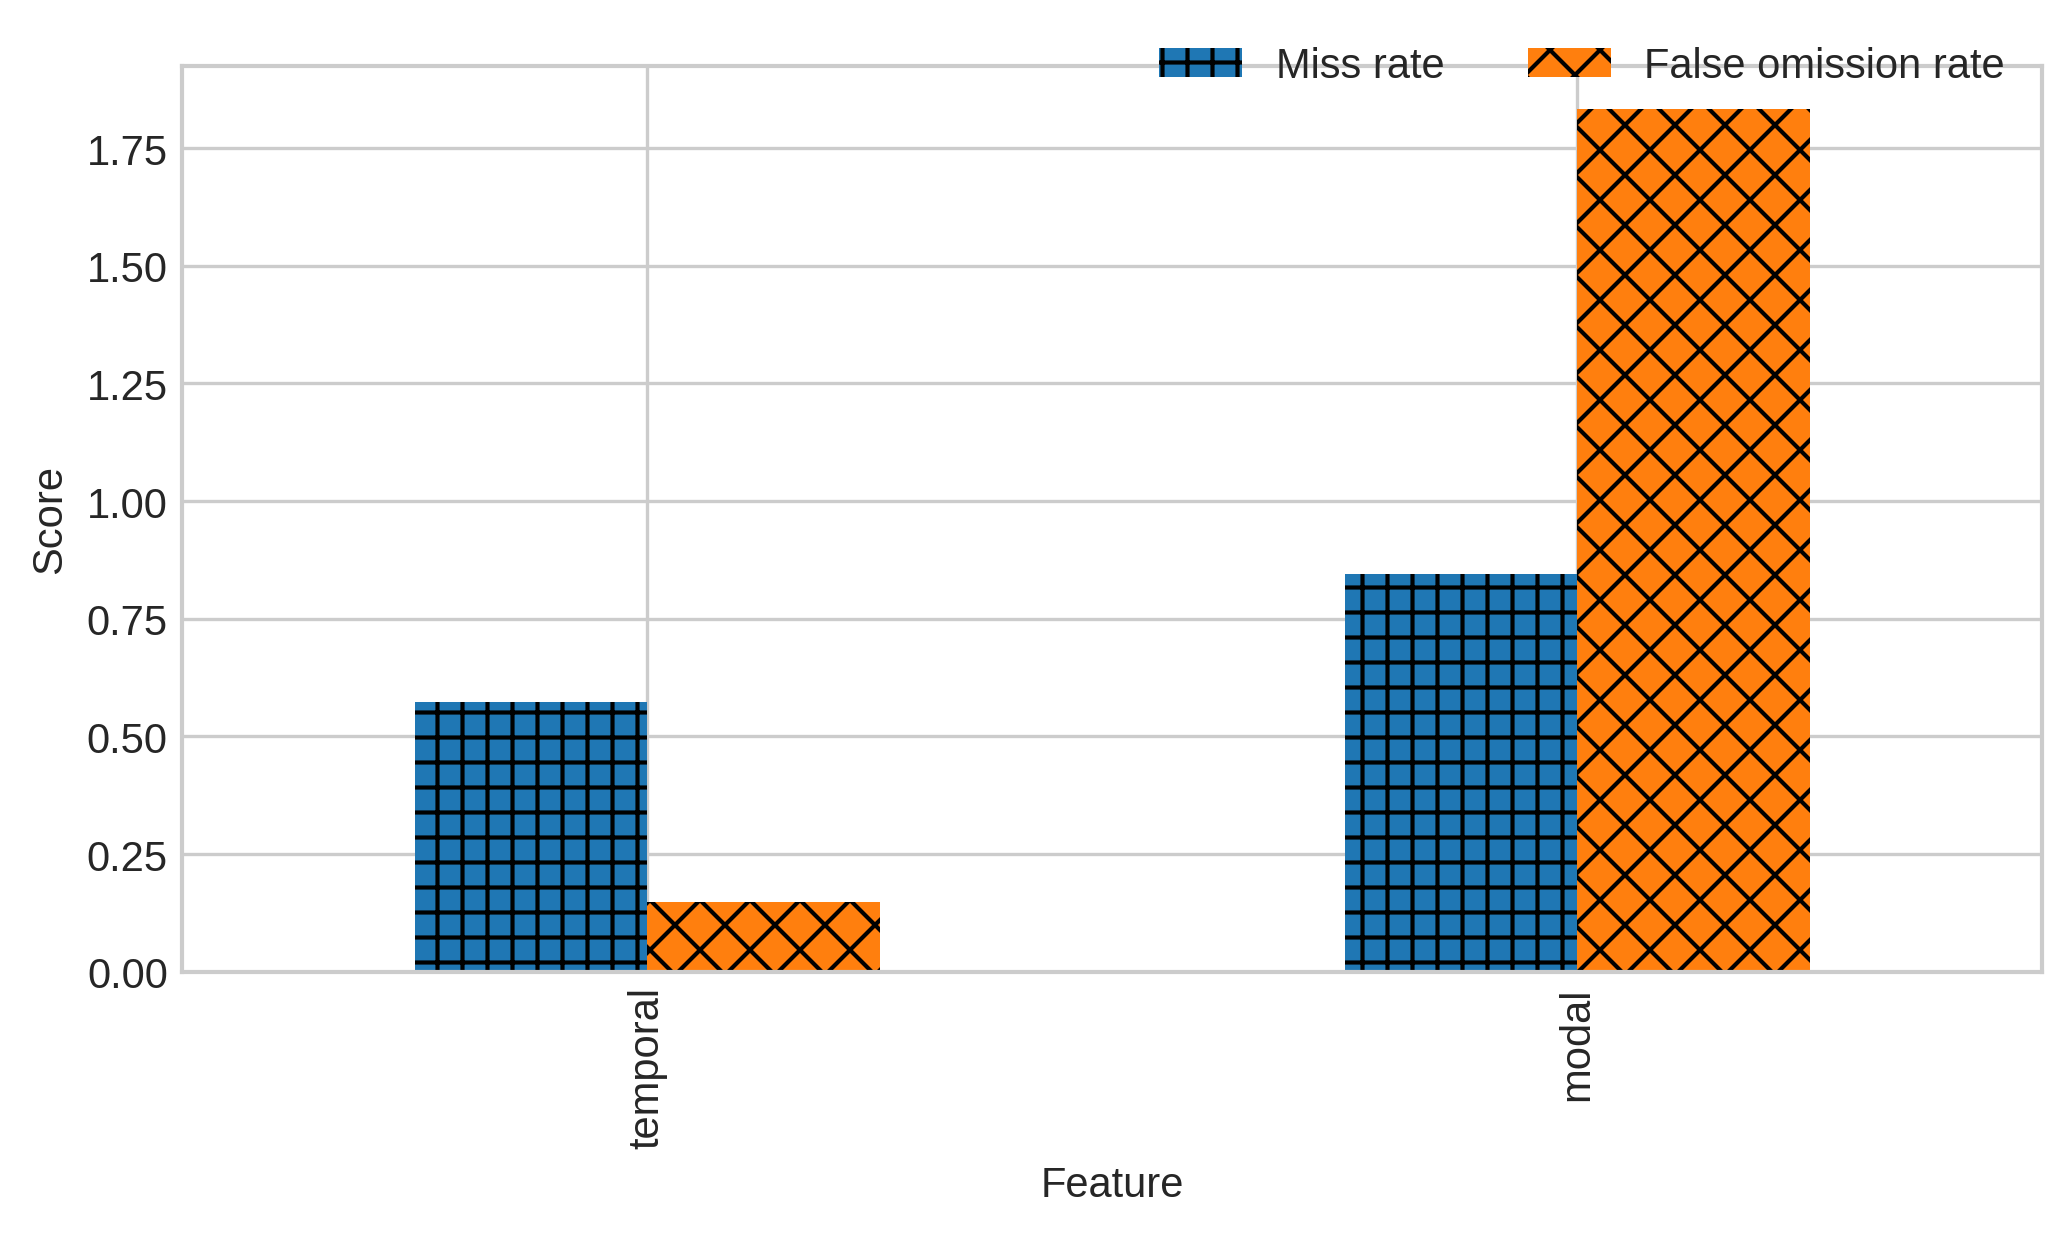

<Figure size 2400x1200 with 0 Axes>

In [38]:
make_stats2(aggregate, "DEICTICITY-ocd", filters=DEICTICITY)
# make_stats2(aggregate, "TEMPORAL_DEICTICITY_TIME-ocd", filters=TEMPORAL_DEICTICITY_TIME)
# make_stats2(aggregate, "TEMPORAL_DEICTICITY_PERFECTIVITY-ocd", filters=TEMPORAL_DEICTICITY_PERFECTIVITY)
# make_stats2(aggregate, "TEMPORAL_DEICTICITY_PROGRESSIVITY-ocd", filters=TEMPORAL_DEICTICITY_PROGRESSIVITY)
# make_stats2(aggregate, "MODAL_DEICTICITY-ocd", filters=MODAL_DEICTICITY)

## MOOD_ASSESMENT

In [39]:
make_stats2(aggregate, "MOOD_ASSESMENT-ocd", filters=MOOD_ASSESMENT)

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

## AGENCY

In [40]:
# make_stats2(aggregate, "AGENCY-ocd", filters=AGENCY)

# Transitivity system feature evaluation - [OE+BTC] corpus

In [41]:
################
PROCESS_TYPE = ["action","mental","relational","influential","event-relating","environmental"]
ACTION = [ "one-role-action","three-role-action","two-role-action"]
RELATIONAL  = ["attributive","posessive","locational","directional","matching"]
MENTAL = ["emotive","three-role-perception","two-role-perception","three-role-cognition",
          "two-role-cognition","desiderative"]
INFLUENTIAL = ["preventive","starting","continuing","ceasing","succeeding","failing",
               "causative","permissive","tentative","enabling","preventive","delaying"]

PARTICIPANT_ROLE = ["emoter","phenomenon","carrier","possessive","cognizant","agent",
                "possessed","attribute","destination","affected","location","source",
                "created-phenomenon","path","range","affected-carrier","affected-possessed",
                "affected-cognizant","manner","perceiver","agent-carrier","created","matchee",
                "agent-perceiver","agent-cognizant","affected-destination","affected-emoter",
                "affected-perceiver","affected-path","affected-source"]

PARTICIPANT_ROLE_MOST_USED = ["emoter","phenomenon","carrier","possessive","cognizant","agent",
                "possessed","attribute","destination","affected","location","source",]

################

# ---------
matches, manual_nm, parse_nm = read_batch( OE1_trans_file_list + BTC_trans_file_list )
# ---------
aggregate = aggregate_data_by_feature(matches, manual_nm, parse_nm)

## PROCESS_TYPE

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

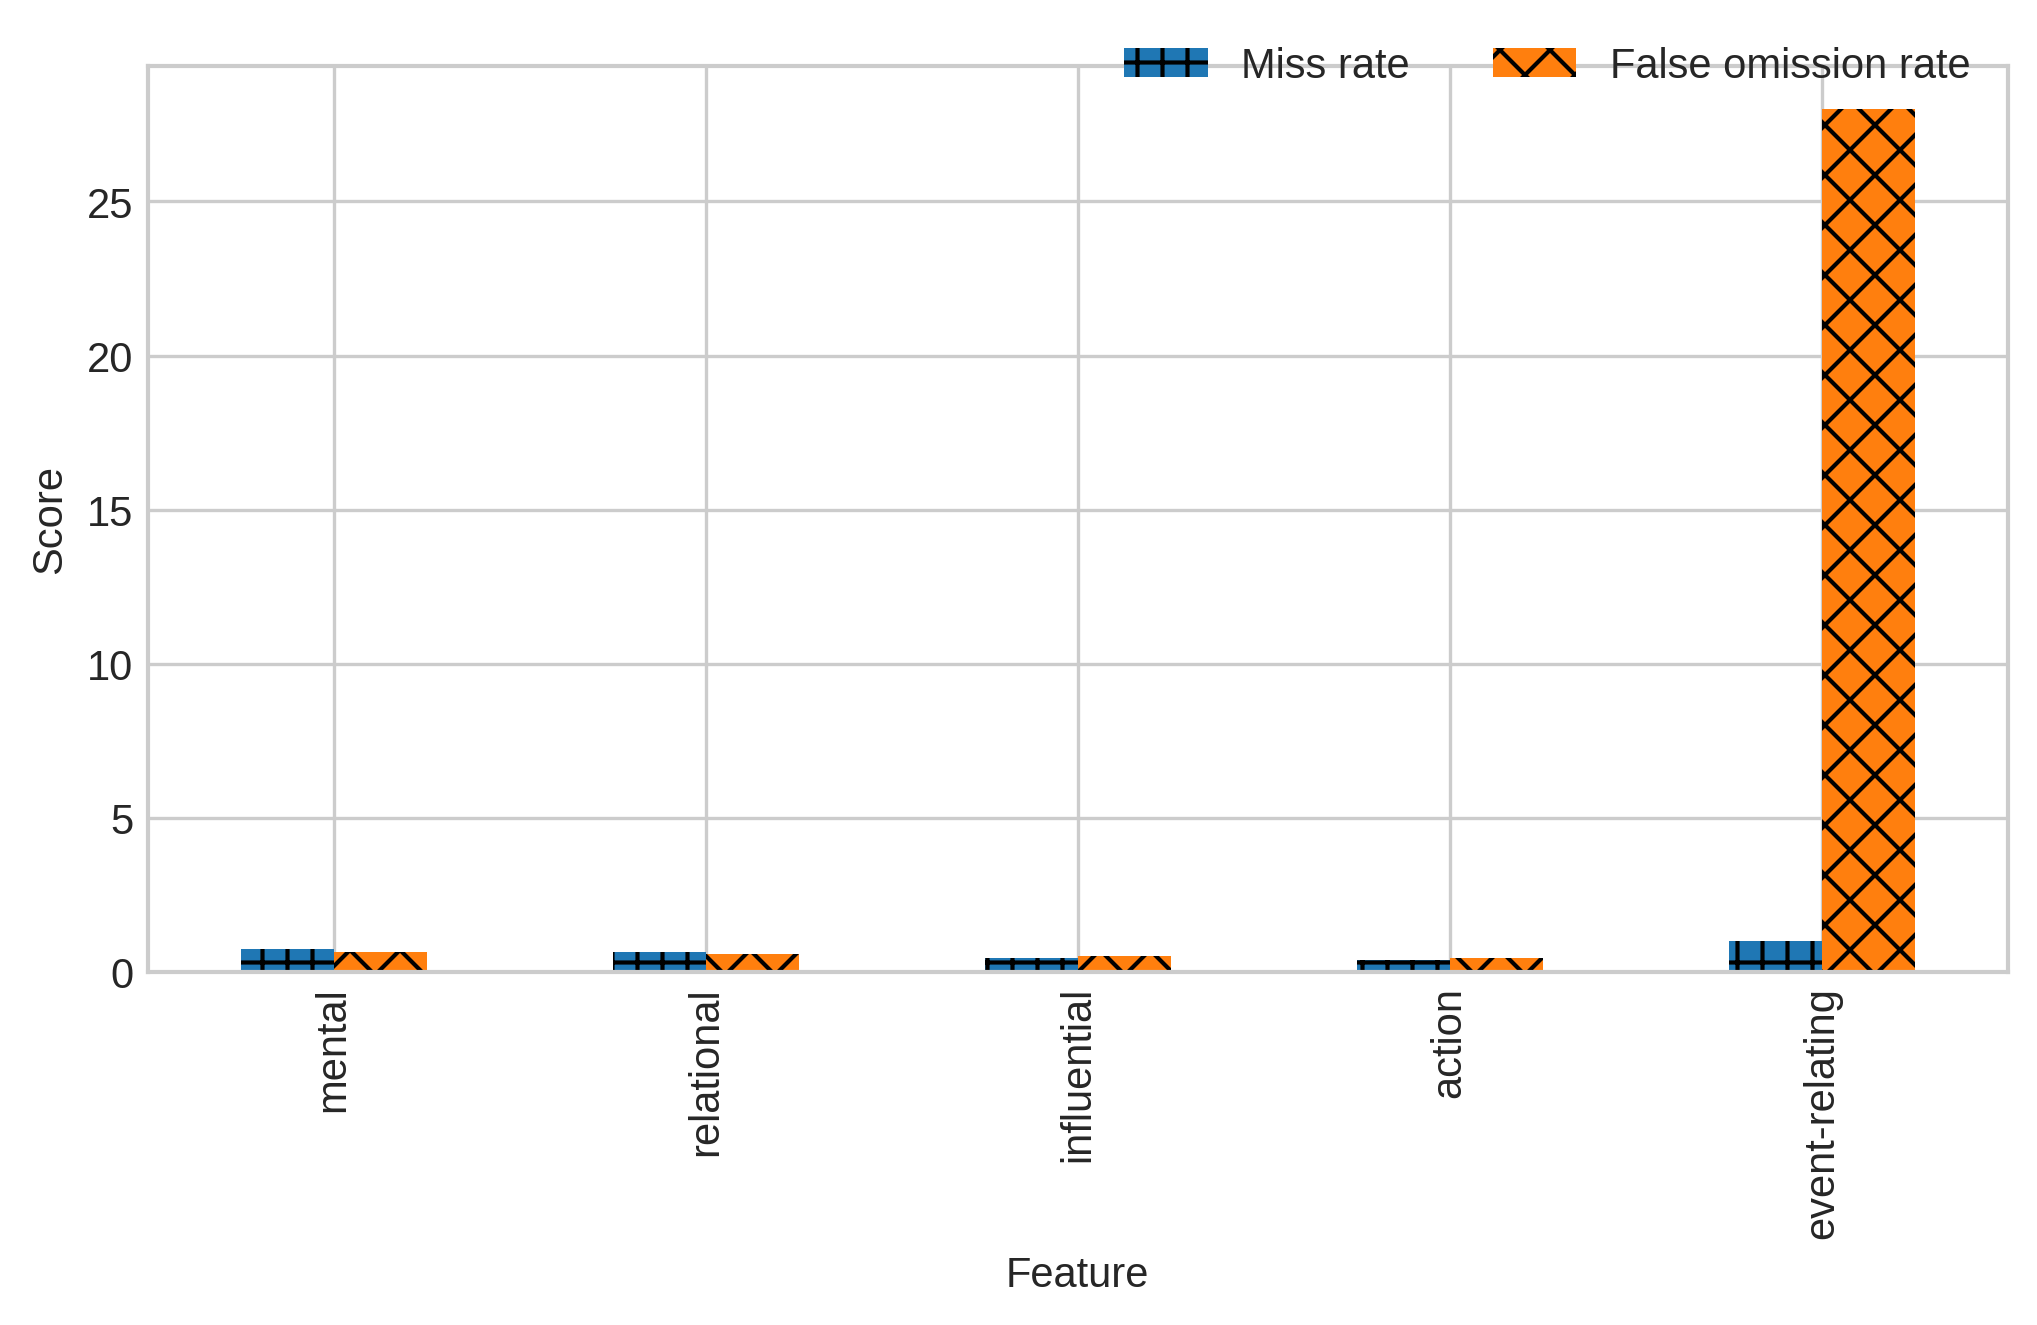

<Figure size 2400x1200 with 0 Axes>

In [42]:
make_stats2(aggregate, "PROCESS_TYPE-oe", filters=PROCESS_TYPE)

## ACTION

In [43]:
# make_stats2(aggregate, "ACTION-oe", filters=ACTION)

## RELATIONAL

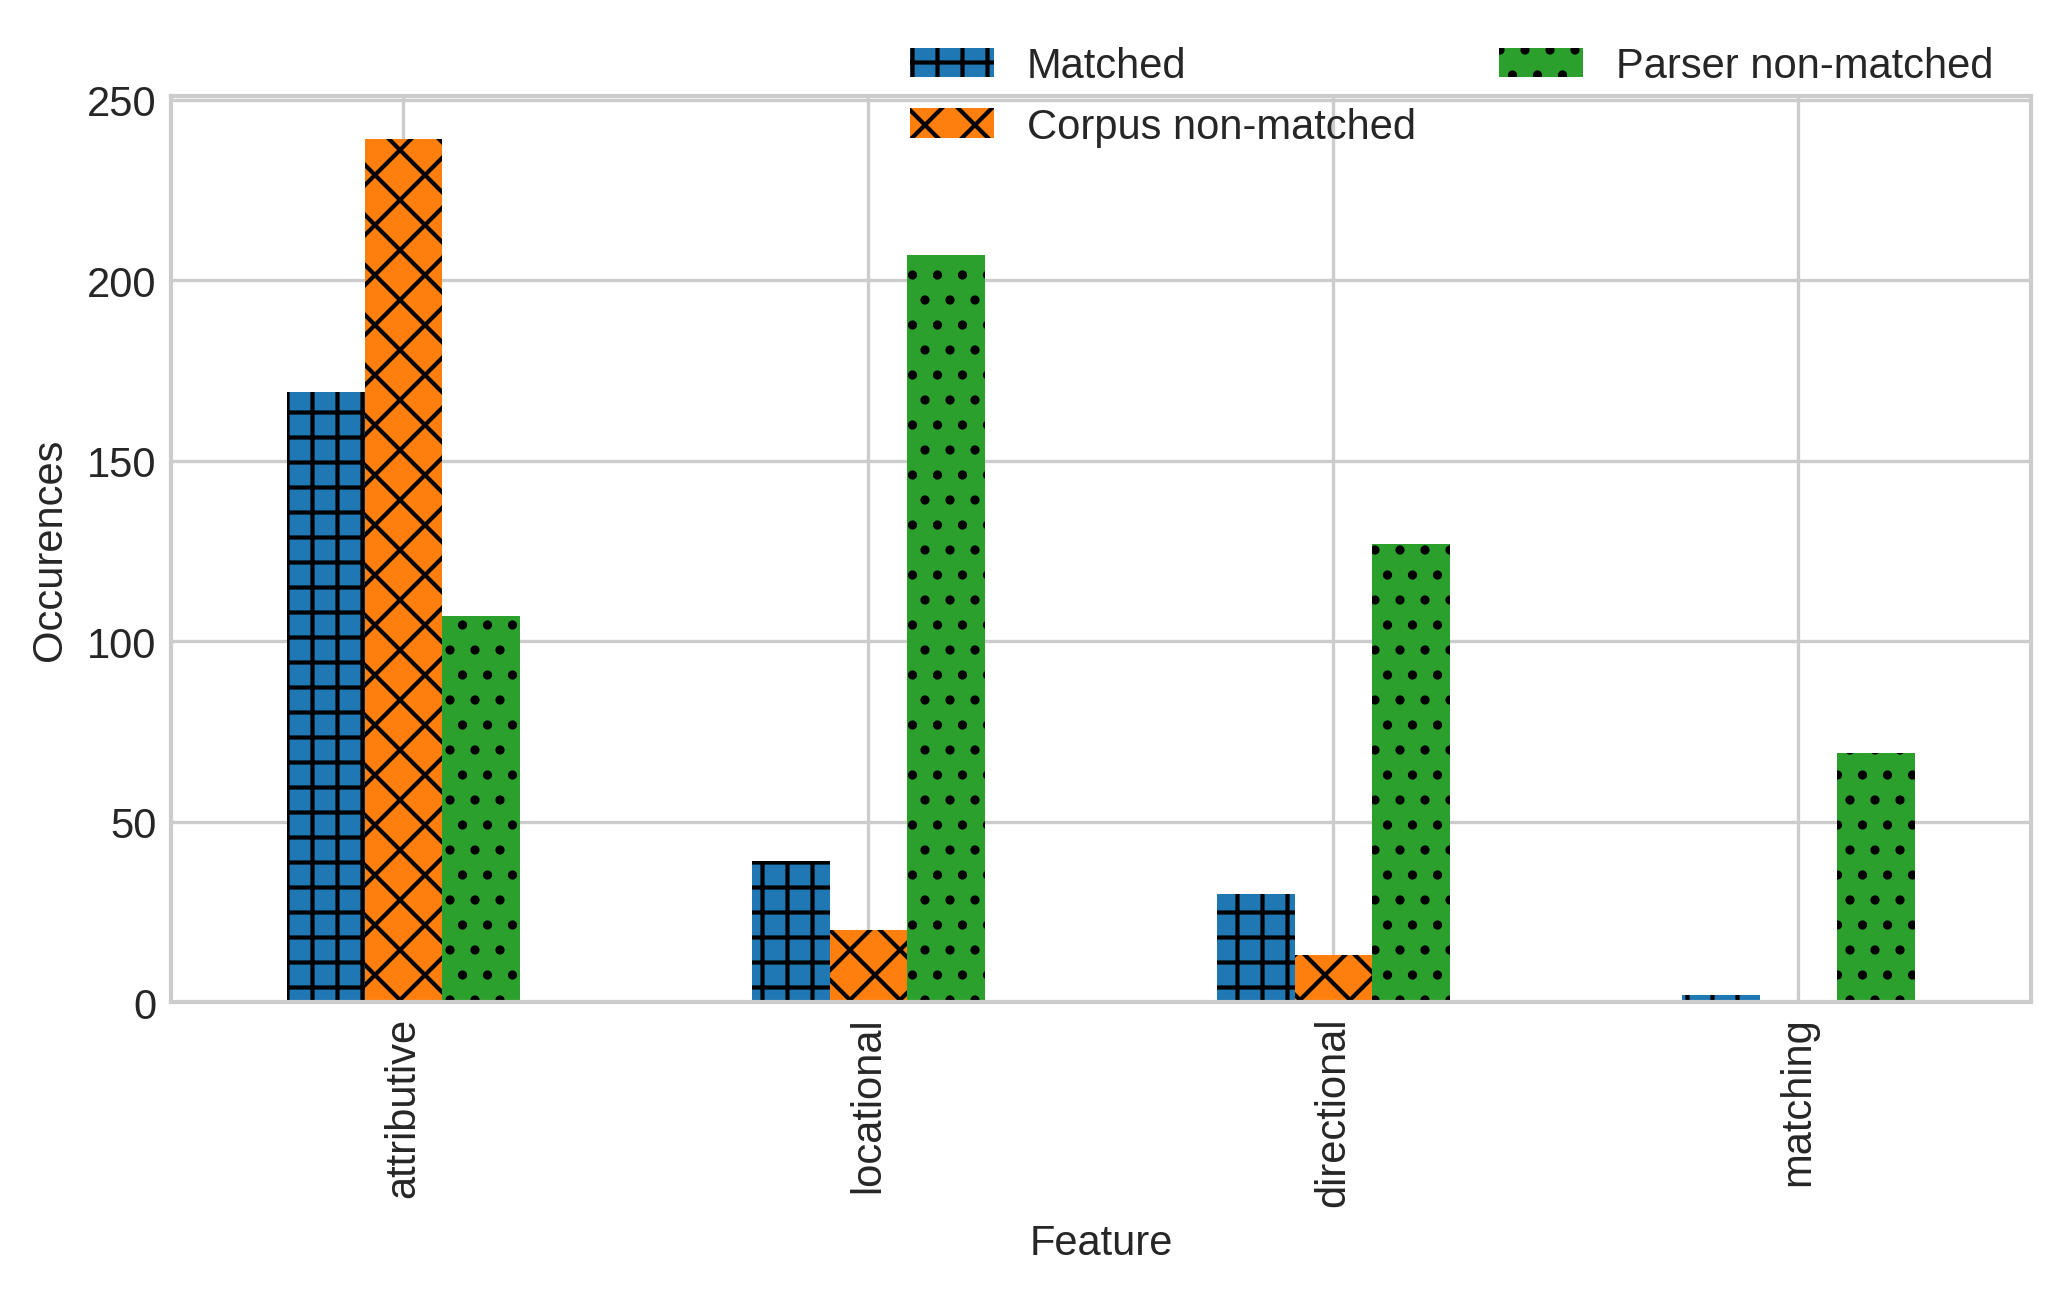

<Figure size 2400x1200 with 0 Axes>

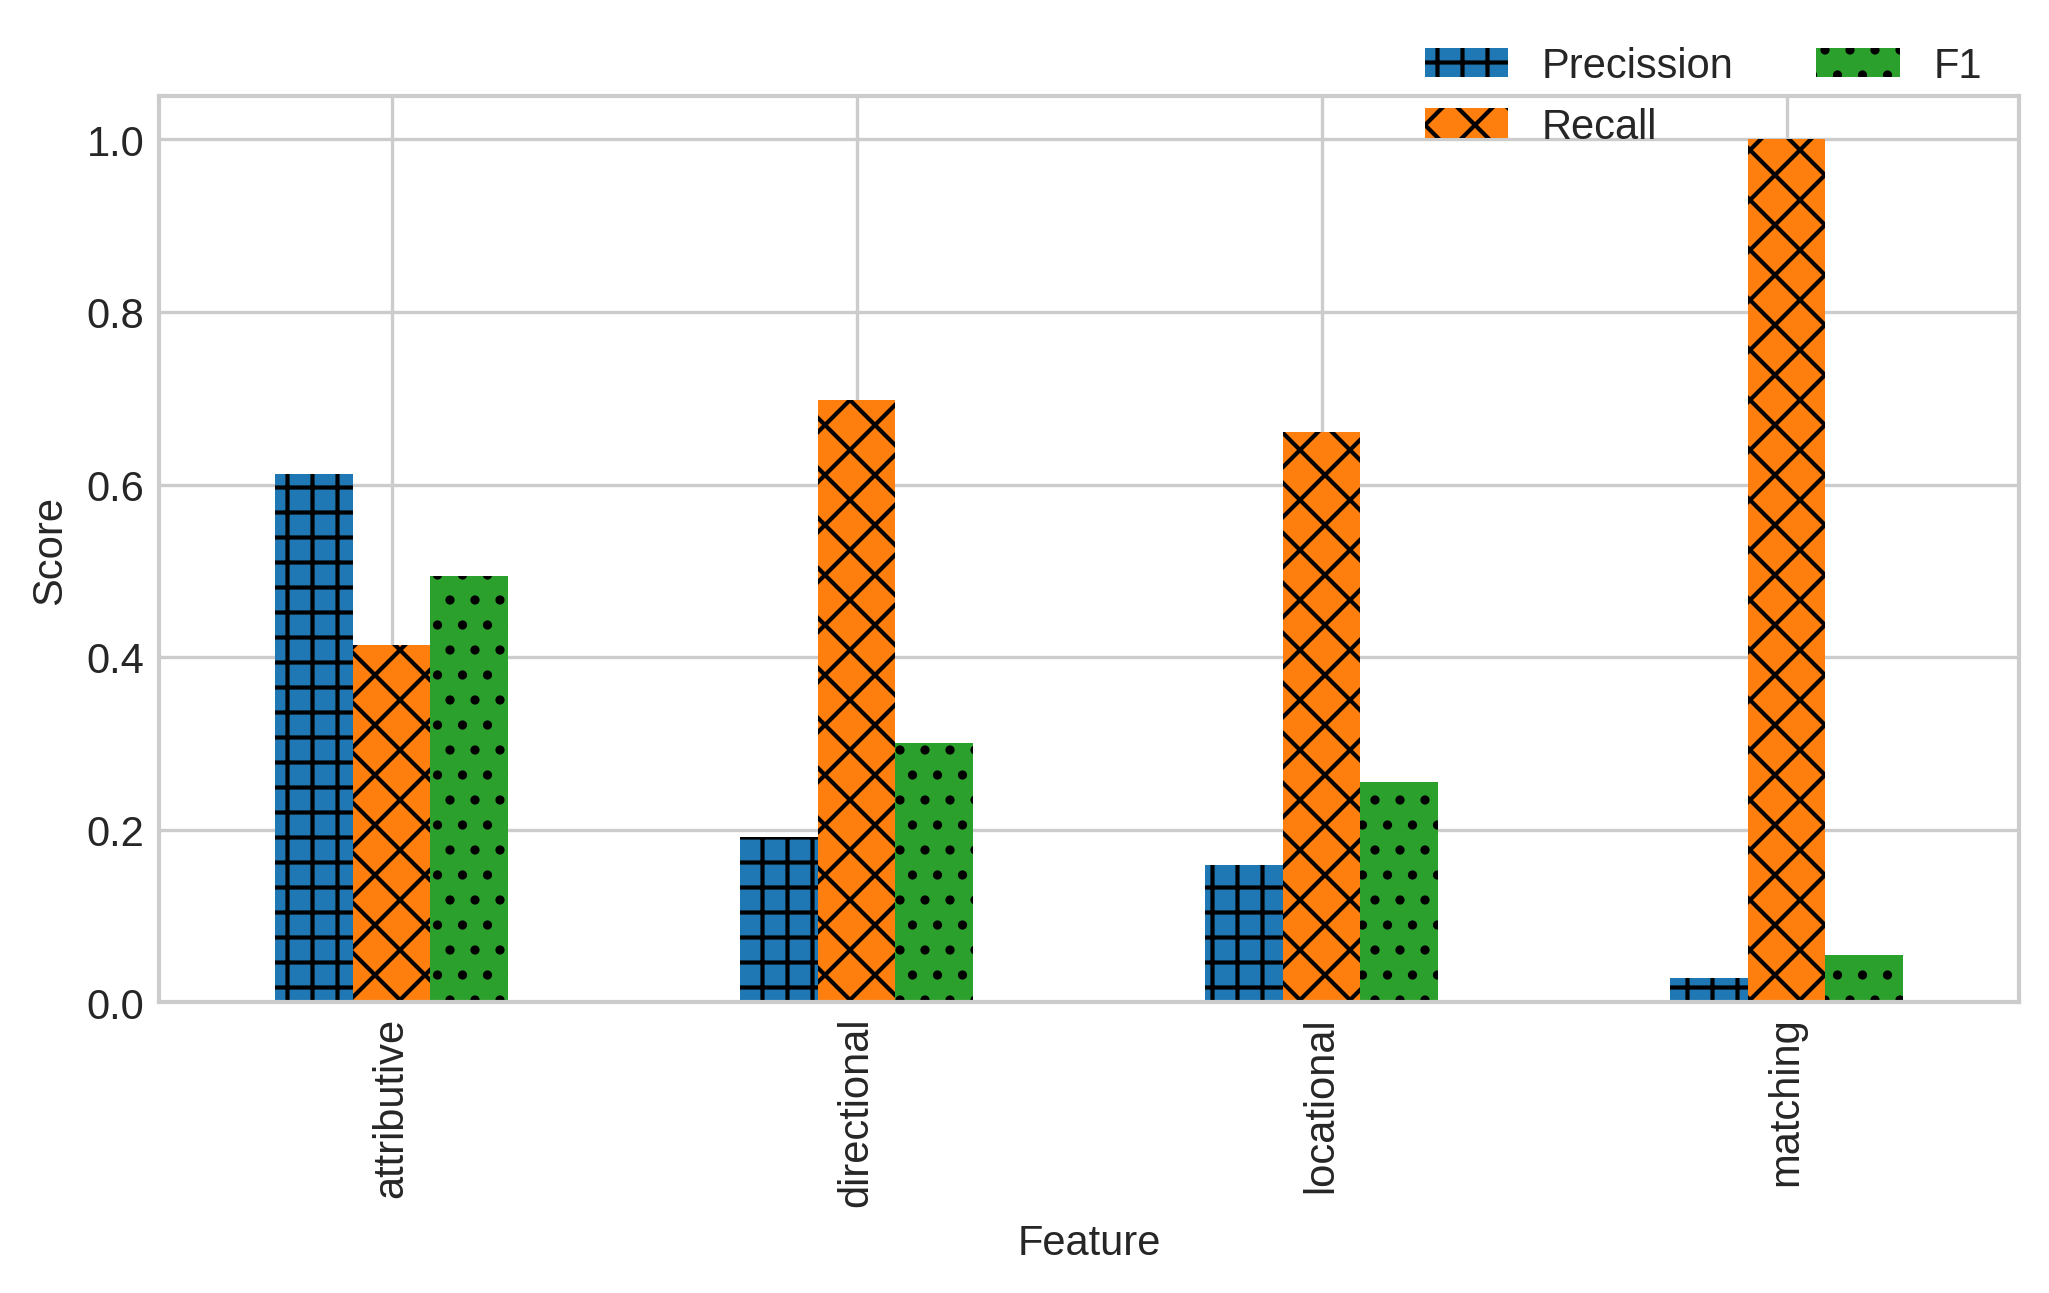

<Figure size 2400x1200 with 0 Axes>

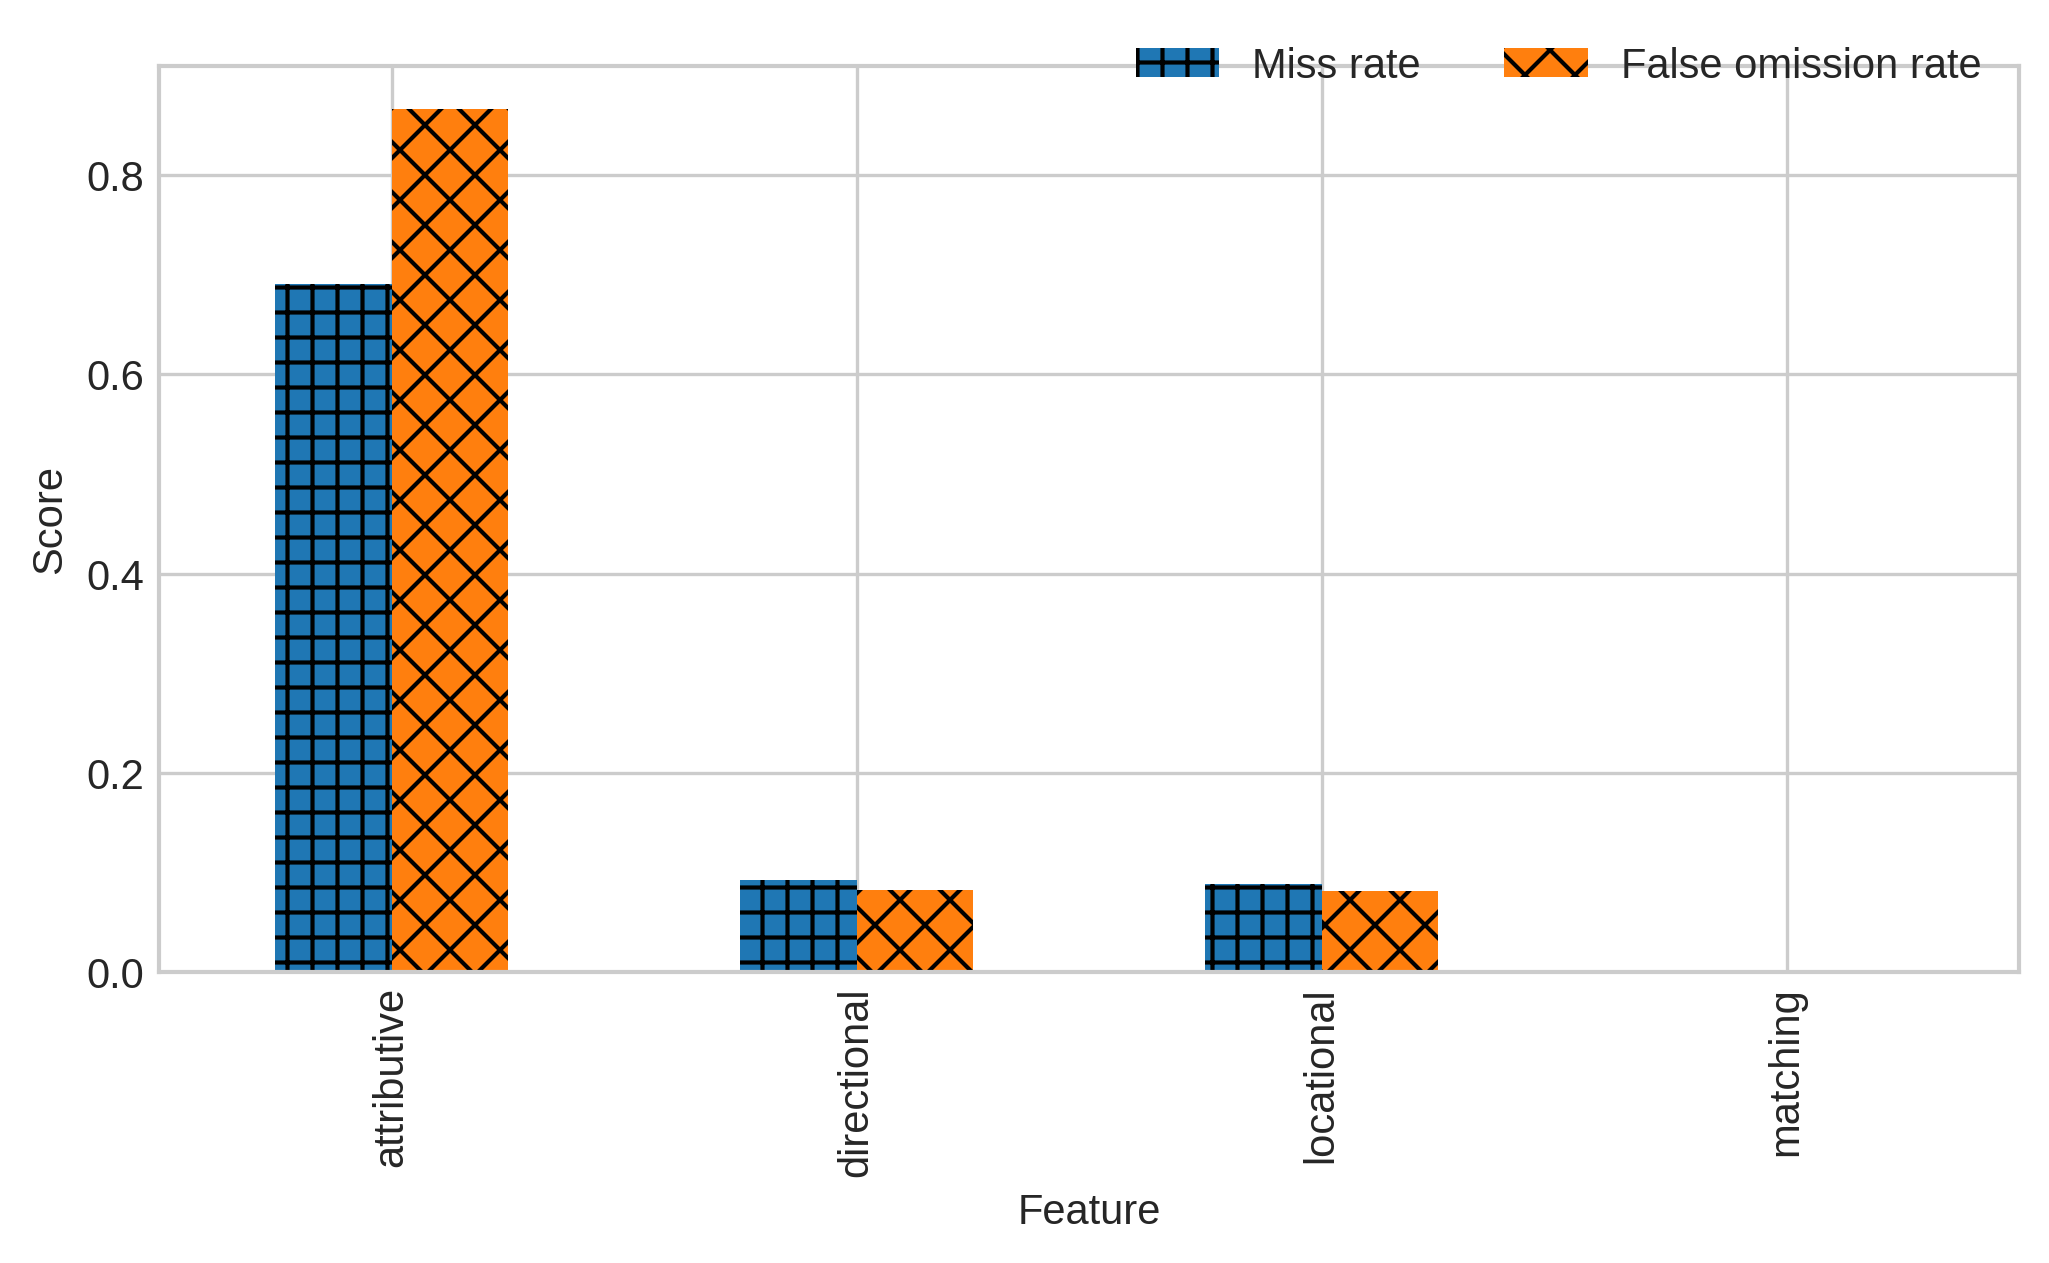

<Figure size 2400x1200 with 0 Axes>

In [44]:
make_stats2(aggregate, "RELATIONAL-oe", filters=RELATIONAL)

## MENTAL

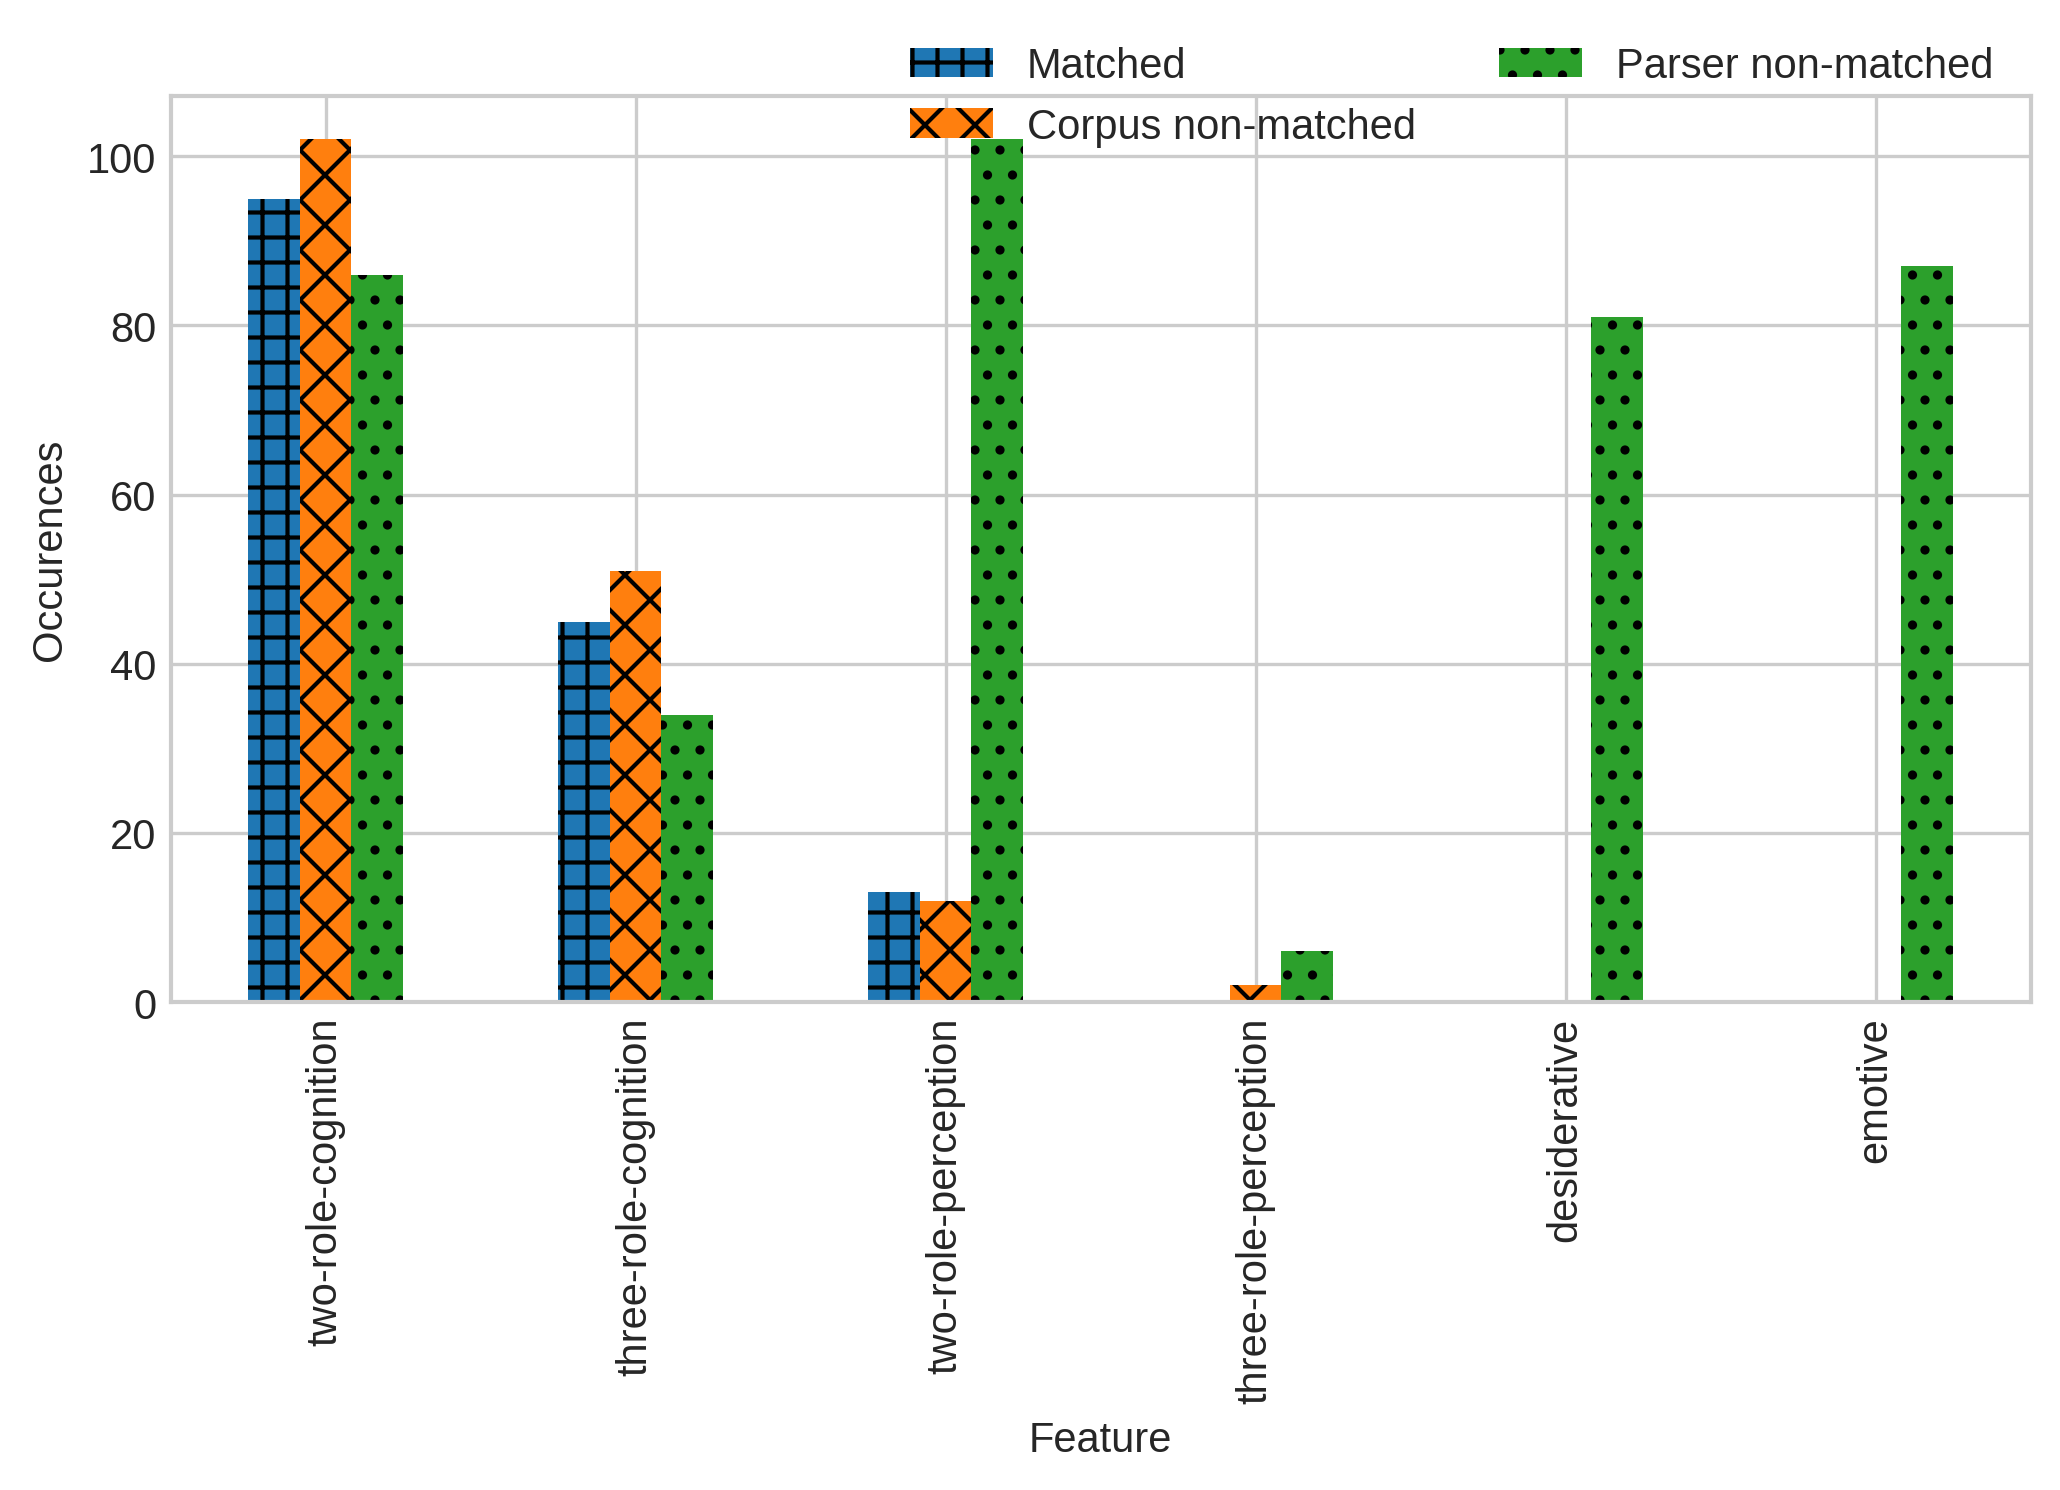

<Figure size 2400x1200 with 0 Axes>

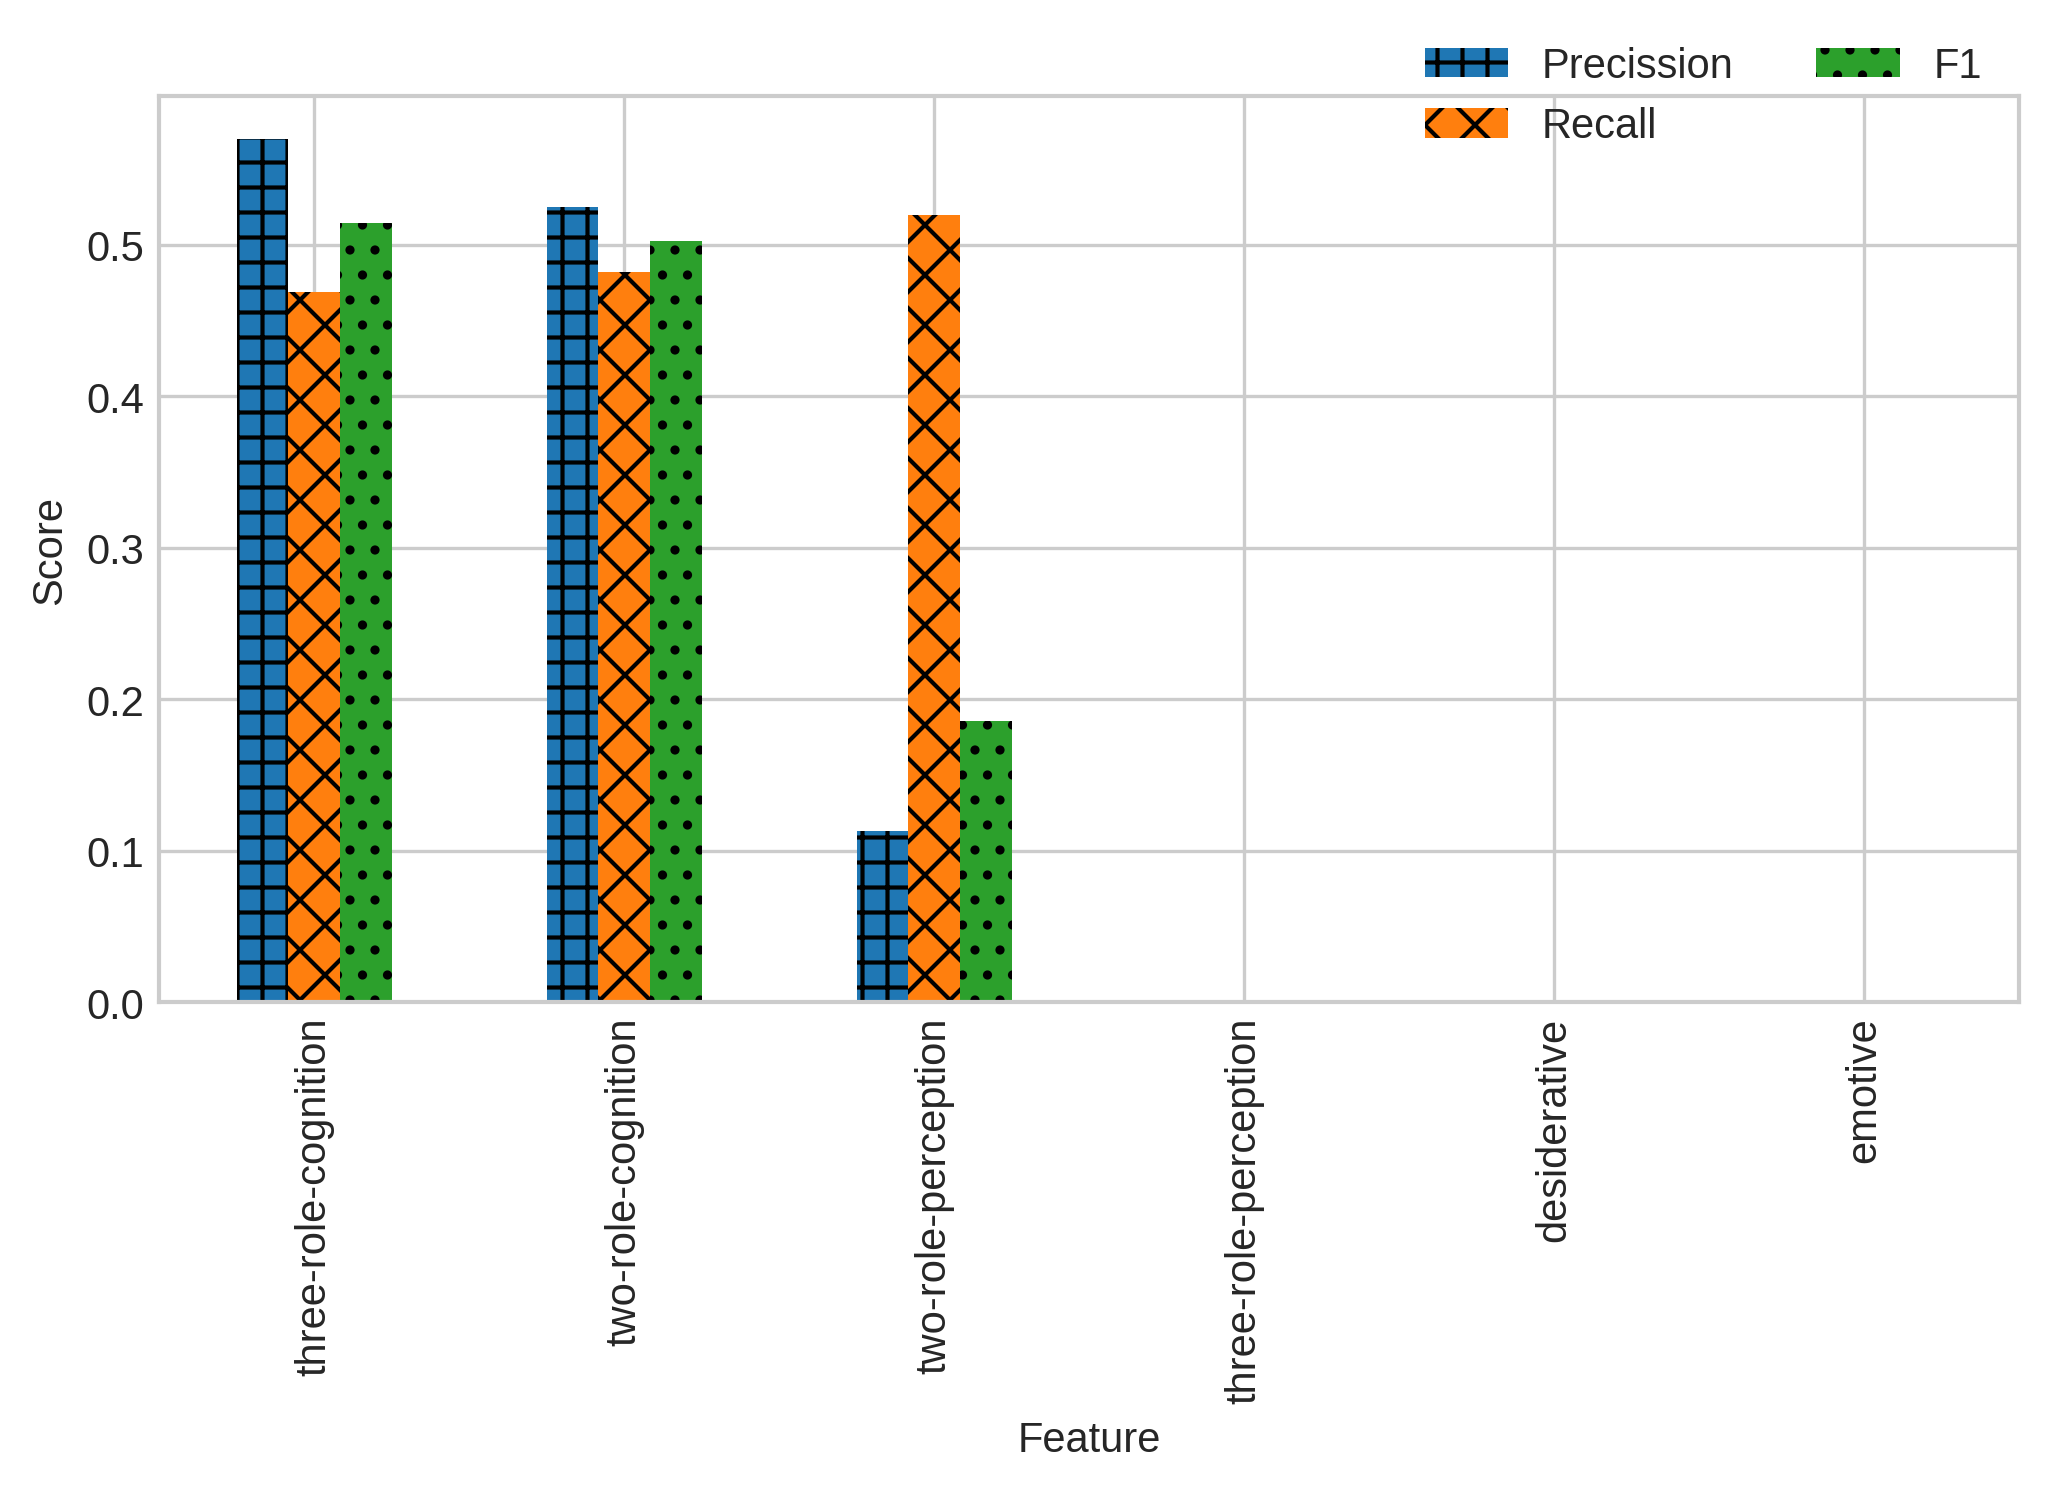

<Figure size 2400x1200 with 0 Axes>

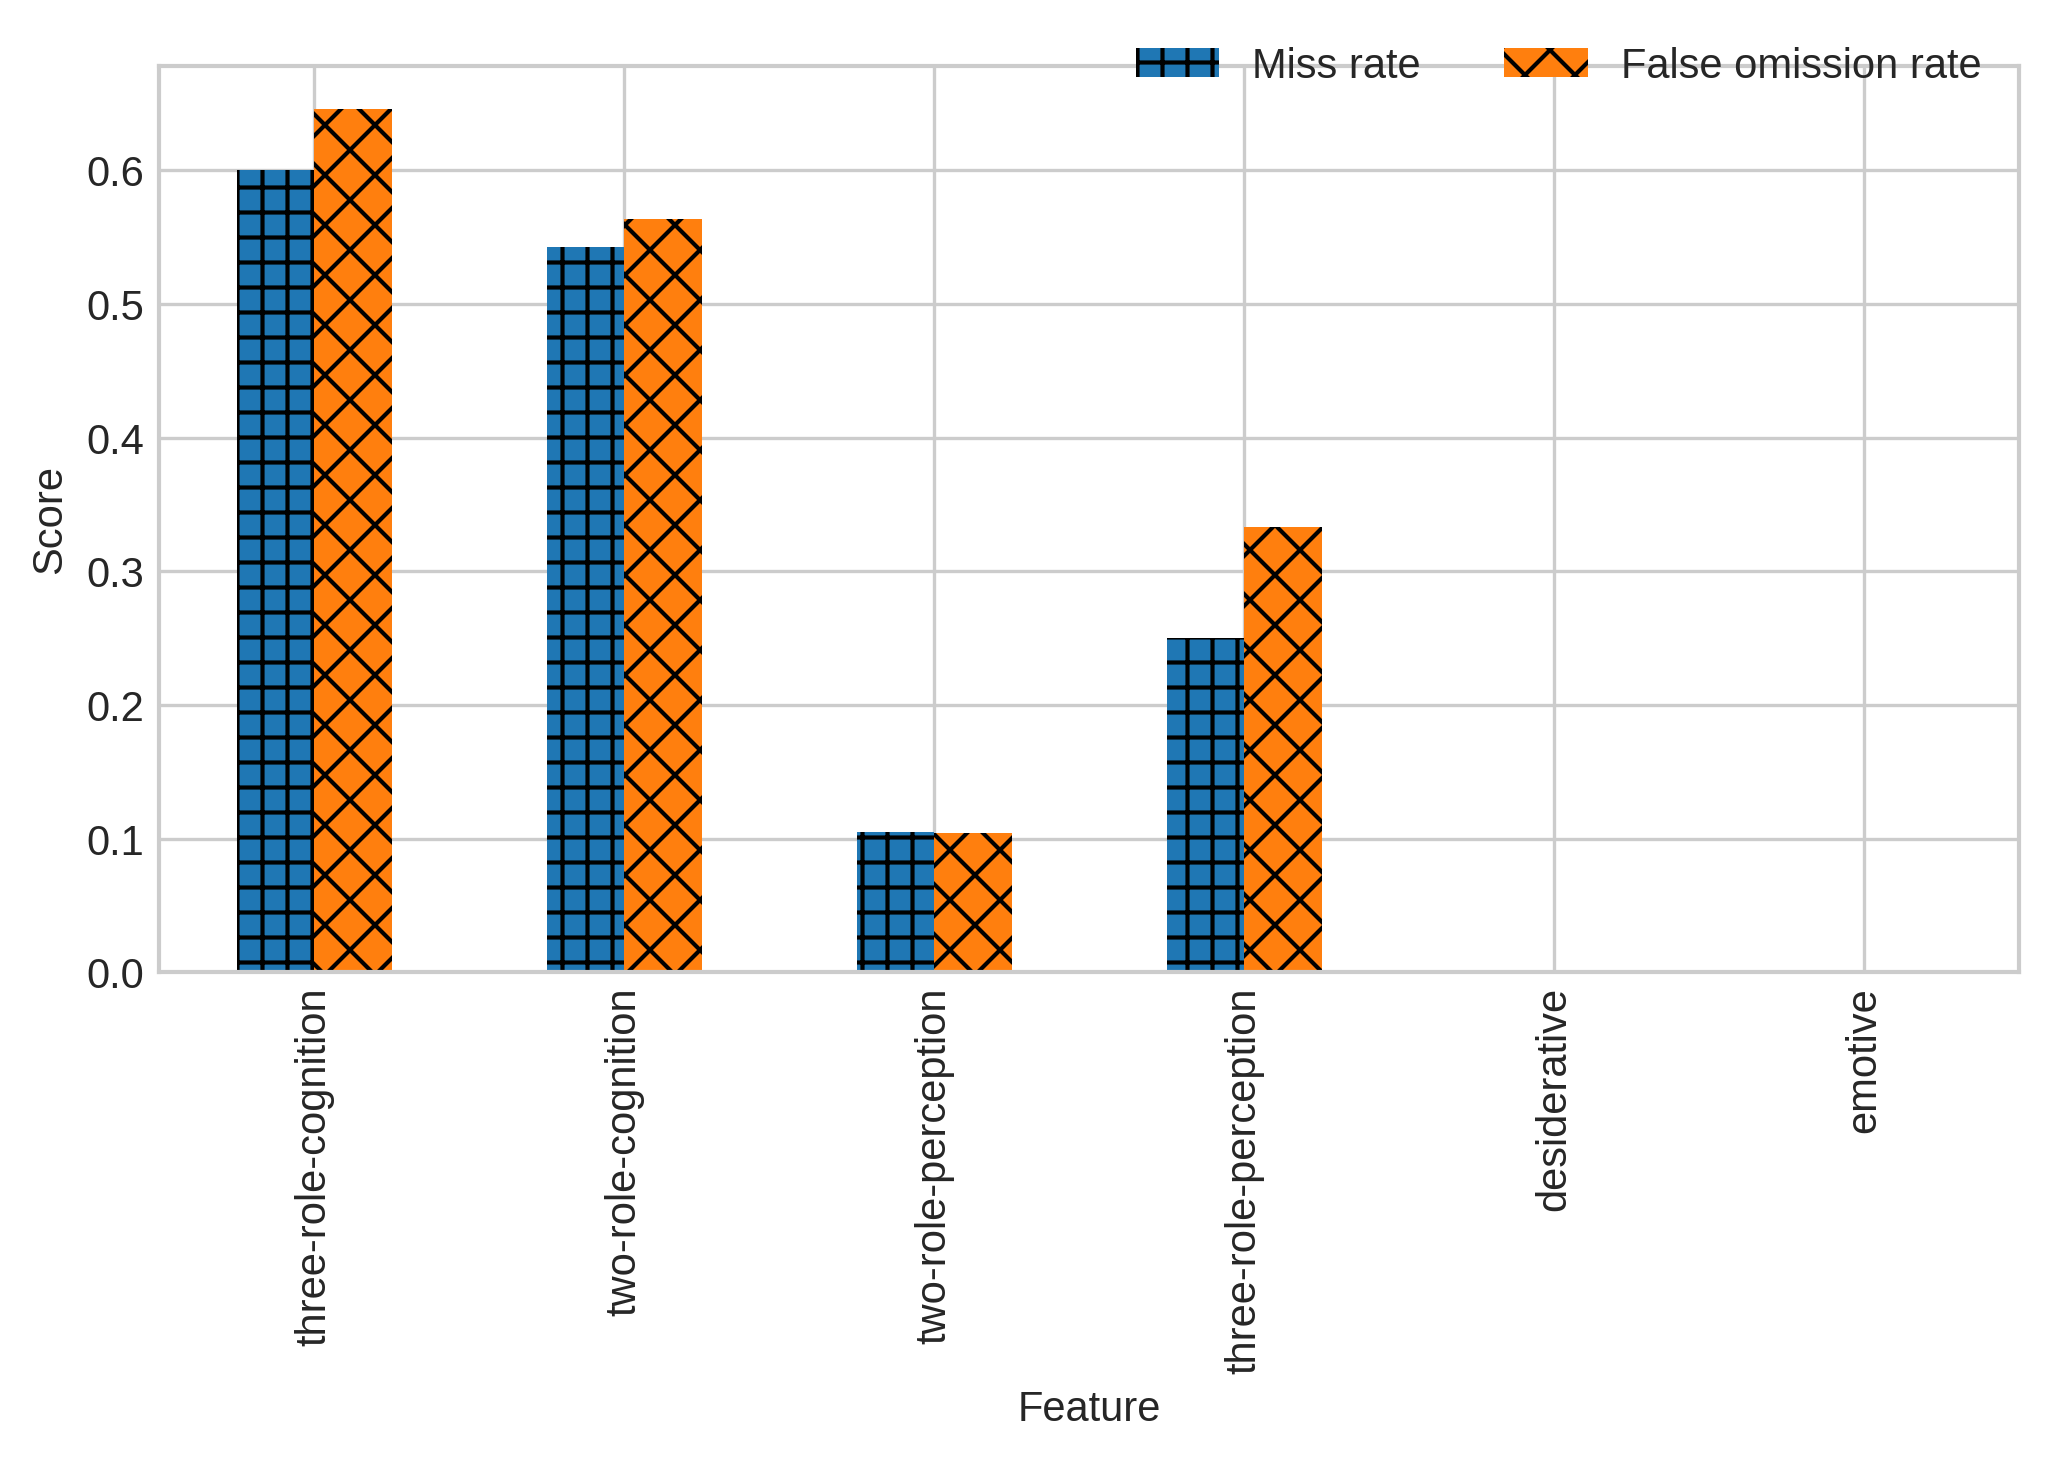

<Figure size 2400x1200 with 0 Axes>

In [45]:
make_stats2(aggregate, "MENTAL-oe", filters=MENTAL)

## INFLUENTIAL

In [46]:
# make_stats2(aggregate, "INFLUENTIAL-oe", filters=INFLUENTIAL)

## PARTICIPANT_ROLE

In [47]:
make_stats2(aggregate, "PARTICIPANT_ROLE_MOST_USED-oe", filters=PARTICIPANT_ROLE_MOST_USED)

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>